In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
from tqdm import tqdm
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
%matplotlib inline

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

# MA Filter Implementation

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Algorithm to transfer data in tabular format

In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# ESN Model Library

In [ ]:
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# DIRMO Strategy

In [ ]:
def dirmo_strategy(X, Y, s, num_hidden_nodes, learning_rate, batch_size, epochs, model):
    n = Y.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    number_of_models = int(n/s)
    models = []  # Liste pour stocker les modèles entraînés
    total_training_elapsed_time = 0

    if model=='lstm':

        for i in range(number_of_models):
            y = Y[:, i:i+s]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prédiction i
            model = Sequential()
            model.add(LSTM(num_hidden_nodes))
            model.add(Dense(s))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)


            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time

            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")

    elif model=='gru':

        for i in range(number_of_models):
            y = Y[:, i:i+s]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prédiction i
            model = Sequential()
            model.add(GRU(num_hidden_nodes))
            model.add(Dense(s))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)


            # Record the starting time to training the model
            training_start_time = time.time()

            # Train and test our model
            model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time

            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model=='rnn':

        for i in range(number_of_models):
            y = Y[:, i:i+s]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prédiction i
            model = Sequential()
            model.add(SimpleRNN(num_hidden_nodes))
            model.add(Dense(s))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)


            # Record the starting time to training the model
            training_start_time = time.time()

            # Train and test our model
            model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time

            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    return models, total_training_elapsed_time

In [ ]:
def predict_using_models(models, X, s):
    n = len(models)  # Nombre de modèles

    # Initialisation d'une matrice pour stocker les prédictions
    predictions = np.zeros((X.shape[0], n*s))

    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    for i, model in enumerate(models):
        # Effectue les prédictions pour le modèle i
        y_pred = model.predict(X, verbose=0)
        predictions[:, s*i:s*i+s] = np.squeeze(y_pred)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time
    return predictions, predictions_elapsed_time

## Finding Best HyperParameters

In [ ]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_nodes = trial.suggest_int('num_hidden_nodes', 8, 256)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

    models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

    # make predictions
    testPredict, predictions_elapsed_time = predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-06 06:41:00,573] A new study created in memory with name: no-name-0a1e84c2-9b36-429c-80d2-2a792389175f


Window Size:  10
17991 16192 1799 2000


<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 06:44:00,263] Trial 0 finished with value: 0.030466708226619104 and parameters: {'look_back': 239, 'num_hidden_nodes': 228, 'learning_rate': 0.00817027011500078, 'batch_size': 210, 'epochs': 56}. Best is trial 0 with value: 0.030466708226619104.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 06:46:37,022] Trial 1 finished with value: 0.03805862616413322 and parameters: {'look_back': 194, 'num_hidden_nodes': 146, 'learning_rate': 1.3144731966844544e-05, 'batch_size': 150, 'epochs': 63}. Best is trial 0 with value: 0.030466708226619104.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 06:48:47,689] Trial 2 finished with value: 0.04624031185864665 and parameters: {'look_back': 155, 'num_hidden_nodes': 201, 'learning_rate': 0.06480907726975564, 'batch_size': 198, 'epochs': 38}. Best is trial 0 with value: 0.030466708226619104.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 06:51:38,016] Trial 3 finished with value: 0.045721047686735274 and parameters: {'look_back': 201, 'num_hidden_nodes': 173, 'learning_rate': 0.04207008153030515, 'batch_size': 228, 'epochs': 43}. Best is trial 0 with value: 0.030466708226619104.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:09:27,894] Trial 4 finished with value: 0.02824406349358104 and parameters: {'look_back': 279, 'num_hidden_nodes': 245, 'learning_rate': 0.0028137656112345957, 'batch_size': 24, 'epochs': 100}. Best is trial 4 with value: 0.02824406349358104.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:11:43,277] Trial 5 finished with value: 0.028232284732774036 and parameters: {'look_back': 103, 'num_hidden_nodes': 126, 'learning_rate': 0.011251289264492727, 'batch_size': 155, 'epochs': 77}. Best is trial 5 with value: 0.028232284732774036.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:12:24,870] Trial 6 finished with value: 0.03621200421820798 and parameters: {'look_back': 216, 'num_hidden_nodes': 206, 'learning_rate': 0.00013163292934507002, 'batch_size': 203, 'epochs': 14}. Best is trial 5 with value: 0.028232284732774036.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:13:37,032] Trial 7 finished with value: 0.03303395964681396 and parameters: {'look_back': 200, 'num_hidden_nodes': 14, 'learning_rate': 0.0036277078170720415, 'batch_size': 115, 'epochs': 53}. Best is trial 5 with value: 0.028232284732774036.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:14:58,233] Trial 8 finished with value: 0.029308532622776287 and parameters: {'look_back': 17, 'num_hidden_nodes': 175, 'learning_rate': 0.0015881098403465153, 'batch_size': 153, 'epochs': 41}. Best is trial 5 with value: 0.028232284732774036.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:17:22,581] Trial 9 finished with value: 0.02806889136476697 and parameters: {'look_back': 53, 'num_hidden_nodes': 227, 'learning_rate': 0.0006481568758801455, 'batch_size': 246, 'epochs': 64}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:18:39,602] Trial 10 finished with value: 0.031631885552894395 and parameters: {'look_back': 8, 'num_hidden_nodes': 94, 'learning_rate': 0.0003339120877570085, 'batch_size': 297, 'epochs': 80}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:20:02,800] Trial 11 finished with value: 0.028293971754384577 and parameters: {'look_back': 79, 'num_hidden_nodes': 84, 'learning_rate': 0.01312243708945264, 'batch_size': 282, 'epochs': 79}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:23:31,383] Trial 12 finished with value: 0.03131771916876766 and parameters: {'look_back': 95, 'num_hidden_nodes': 99, 'learning_rate': 0.0005295855538297793, 'batch_size': 71, 'epochs': 77}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:24:52,633] Trial 13 finished with value: 0.030859791329138127 and parameters: {'look_back': 80, 'num_hidden_nodes': 43, 'learning_rate': 0.011421574946233658, 'batch_size': 255, 'epochs': 98}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:27:24,379] Trial 14 finished with value: 0.028947349356447688 and parameters: {'look_back': 121, 'num_hidden_nodes': 135, 'learning_rate': 0.0008276029383330271, 'batch_size': 158, 'epochs': 68}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:31:55,779] Trial 15 finished with value: 0.029247197500274668 and parameters: {'look_back': 48, 'num_hidden_nodes': 163, 'learning_rate': 0.08059907420746515, 'batch_size': 93, 'epochs': 91}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:34:11,120] Trial 16 finished with value: 0.02911974586301797 and parameters: {'look_back': 141, 'num_hidden_nodes': 111, 'learning_rate': 0.0001482492316575061, 'batch_size': 55, 'epochs': 29}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:35:11,792] Trial 17 finished with value: 0.02819116647745224 and parameters: {'look_back': 44, 'num_hidden_nodes': 61, 'learning_rate': 0.020804696916020098, 'batch_size': 247, 'epochs': 69}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:36:26,490] Trial 18 finished with value: 0.028117792548386804 and parameters: {'look_back': 43, 'num_hidden_nodes': 53, 'learning_rate': 0.030436516083537264, 'batch_size': 252, 'epochs': 66}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:37:04,576] Trial 19 finished with value: 0.02895956466673073 and parameters: {'look_back': 44, 'num_hidden_nodes': 12, 'learning_rate': 0.0038989322888284927, 'batch_size': 267, 'epochs': 56}. Best is trial 9 with value: 0.02806889136476697.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:39:14,644] Trial 20 finished with value: 0.02774748983455039 and parameters: {'look_back': 63, 'num_hidden_nodes': 57, 'learning_rate': 0.03154175653027043, 'batch_size': 185, 'epochs': 89}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:41:27,479] Trial 21 finished with value: 0.029847825907324967 and parameters: {'look_back': 59, 'num_hidden_nodes': 55, 'learning_rate': 0.032634733311410806, 'batch_size': 184, 'epochs': 86}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:42:07,857] Trial 22 finished with value: 0.028450754984841016 and parameters: {'look_back': 25, 'num_hidden_nodes': 33, 'learning_rate': 0.07795868430865982, 'batch_size': 238, 'epochs': 66}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:42:55,980] Trial 23 finished with value: 0.031434422263802046 and parameters: {'look_back': 75, 'num_hidden_nodes': 53, 'learning_rate': 0.028231519011652478, 'batch_size': 224, 'epochs': 49}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:44:43,592] Trial 24 finished with value: 0.03096884916301887 and parameters: {'look_back': 124, 'num_hidden_nodes': 72, 'learning_rate': 0.028661890347925396, 'batch_size': 181, 'epochs': 90}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:45:06,098] Trial 25 finished with value: 0.028868224550440066 and parameters: {'look_back': 28, 'num_hidden_nodes': 26, 'learning_rate': 0.0956708161023356, 'batch_size': 278, 'epochs': 29}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:46:05,027] Trial 26 finished with value: 0.029474102880465907 and parameters: {'look_back': 103, 'num_hidden_nodes': 74, 'learning_rate': 0.006035960417361409, 'batch_size': 257, 'epochs': 61}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:48:35,703] Trial 27 finished with value: 0.029126551964696653 and parameters: {'look_back': 59, 'num_hidden_nodes': 110, 'learning_rate': 0.0017365573968406043, 'batch_size': 132, 'epochs': 84}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:51:28,099] Trial 28 finished with value: 0.02836382910274526 and parameters: {'look_back': 146, 'num_hidden_nodes': 196, 'learning_rate': 0.019089940443625487, 'batch_size': 176, 'epochs': 72}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:55:20,704] Trial 29 finished with value: 0.030735930772487385 and parameters: {'look_back': 173, 'num_hidden_nodes': 251, 'learning_rate': 0.005597082694825454, 'batch_size': 218, 'epochs': 60}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:57:55,808] Trial 30 finished with value: 0.02993912295297135 and parameters: {'look_back': 297, 'num_hidden_nodes': 216, 'learning_rate': 0.010727531323911963, 'batch_size': 209, 'epochs': 48}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 07:59:02,767] Trial 31 finished with value: 0.02822599673087629 and parameters: {'look_back': 34, 'num_hidden_nodes': 63, 'learning_rate': 0.046179838907447965, 'batch_size': 245, 'epochs': 72}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:00:12,909] Trial 32 finished with value: 0.031099532035489156 and parameters: {'look_back': 54, 'num_hidden_nodes': 37, 'learning_rate': 0.017405614120838218, 'batch_size': 241, 'epochs': 71}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:01:06,548] Trial 33 finished with value: 0.03356584628235603 and parameters: {'look_back': 6, 'num_hidden_nodes': 77, 'learning_rate': 0.021374420430952622, 'batch_size': 287, 'epochs': 64}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:02:34,336] Trial 34 finished with value: 0.03264003414624594 and parameters: {'look_back': 68, 'num_hidden_nodes': 149, 'learning_rate': 0.04689664972923658, 'batch_size': 266, 'epochs': 57}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:04:03,144] Trial 35 finished with value: 0.028866634194474744 and parameters: {'look_back': 37, 'num_hidden_nodes': 54, 'learning_rate': 0.007645225845210117, 'batch_size': 198, 'epochs': 94}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:06:07,654] Trial 36 finished with value: 0.03154481092315378 and parameters: {'look_back': 92, 'num_hidden_nodes': 236, 'learning_rate': 0.05742522191794532, 'batch_size': 232, 'epochs': 50}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:07:35,912] Trial 37 finished with value: 0.030143722867700177 and parameters: {'look_back': 118, 'num_hidden_nodes': 90, 'learning_rate': 0.03484020669566136, 'batch_size': 297, 'epochs': 83}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:22:38,648] Trial 38 finished with value: 0.04166544724532834 and parameters: {'look_back': 234, 'num_hidden_nodes': 23, 'learning_rate': 0.01491983280876665, 'batch_size': 8, 'epochs': 75}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:24:53,197] Trial 39 finished with value: 0.02902390560202363 and parameters: {'look_back': 21, 'num_hidden_nodes': 110, 'learning_rate': 0.006900293644393932, 'batch_size': 193, 'epochs': 67}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:25:53,661] Trial 40 finished with value: 0.04498896873696339 and parameters: {'look_back': 164, 'num_hidden_nodes': 134, 'learning_rate': 0.049833467036854845, 'batch_size': 210, 'epochs': 35}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:27:12,271] Trial 41 finished with value: 0.030058776792673336 and parameters: {'look_back': 35, 'num_hidden_nodes': 68, 'learning_rate': 0.04718688431654995, 'batch_size': 239, 'epochs': 74}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:28:16,905] Trial 42 finished with value: 0.02798995774335442 and parameters: {'look_back': 65, 'num_hidden_nodes': 58, 'learning_rate': 0.022268600996876508, 'batch_size': 252, 'epochs': 69}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:29:05,112] Trial 43 finished with value: 0.031877985278733985 and parameters: {'look_back': 66, 'num_hidden_nodes': 45, 'learning_rate': 0.022407466725429807, 'batch_size': 259, 'epochs': 61}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:31:01,882] Trial 44 finished with value: 0.029323564458987438 and parameters: {'look_back': 93, 'num_hidden_nodes': 180, 'learning_rate': 0.09383702369015827, 'batch_size': 273, 'epochs': 69}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:32:16,673] Trial 45 finished with value: 0.03594812527132461 and parameters: {'look_back': 82, 'num_hidden_nodes': 84, 'learning_rate': 0.00979200027167974, 'batch_size': 251, 'epochs': 54}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:32:34,108] Trial 46 finished with value: 0.030388327070426782 and parameters: {'look_back': 48, 'num_hidden_nodes': 59, 'learning_rate': 0.014223214964131033, 'batch_size': 167, 'epochs': 11}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
All Models Done !


[I 2023-09-06 08:33:33,707] Trial 47 finished with value: 0.031214407889209473 and parameters: {'look_back': 10, 'num_hidden_nodes': 45, 'learning_rate': 0.0025869874240569755, 'batch_size': 227, 'epochs': 80}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:34:33,995] Trial 48 finished with value: 0.029254156061900218 and parameters: {'look_back': 109, 'num_hidden_nodes': 123, 'learning_rate': 0.02480510752414982, 'batch_size': 285, 'epochs': 45}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:36:13,977] Trial 49 finished with value: 0.04193805993342775 and parameters: {'look_back': 68, 'num_hidden_nodes': 103, 'learning_rate': 0.06073314910430005, 'batch_size': 137, 'epochs': 58}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:37:00,704] Trial 50 finished with value: 0.028098629169788225 and parameters: {'look_back': 42, 'num_hidden_nodes': 28, 'learning_rate': 0.03750990510146821, 'batch_size': 264, 'epochs': 87}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:37:56,796] Trial 51 finished with value: 0.030078611085096234 and parameters: {'look_back': 43, 'num_hidden_nodes': 21, 'learning_rate': 0.03104415044621132, 'batch_size': 218, 'epochs': 96}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:38:41,156] Trial 52 finished with value: 0.029145855880752514 and parameters: {'look_back': 84, 'num_hidden_nodes': 9, 'learning_rate': 0.015988983569936464, 'batch_size': 261, 'epochs': 88}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:39:25,832] Trial 53 finished with value: 0.032684534386686344 and parameters: {'look_back': 20, 'num_hidden_nodes': 35, 'learning_rate': 0.036837155962197846, 'batch_size': 272, 'epochs': 78}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:40:43,702] Trial 54 finished with value: 0.028436497821566264 and parameters: {'look_back': 59, 'num_hidden_nodes': 48, 'learning_rate': 0.058575442313107545, 'batch_size': 247, 'epochs': 93}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:41:27,757] Trial 55 finished with value: 0.028051449532551773 and parameters: {'look_back': 46, 'num_hidden_nodes': 27, 'learning_rate': 0.008799650073815298, 'batch_size': 286, 'epochs': 83}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:42:15,345] Trial 56 finished with value: 0.028227205450430747 and parameters: {'look_back': 31, 'num_hidden_nodes': 33, 'learning_rate': 0.009543382643288316, 'batch_size': 292, 'epochs': 99}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:42:55,851] Trial 57 finished with value: 0.028559619990085067 and parameters: {'look_back': 52, 'num_hidden_nodes': 18, 'learning_rate': 0.07134586443585188, 'batch_size': 278, 'epochs': 83}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:43:50,696] Trial 58 finished with value: 0.03108255523475266 and parameters: {'look_back': 70, 'num_hidden_nodes': 31, 'learning_rate': 0.013092766345781931, 'batch_size': 267, 'epochs': 87}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:45:01,197] Trial 59 finished with value: 0.029656297451252114 and parameters: {'look_back': 133, 'num_hidden_nodes': 42, 'learning_rate': 0.02517088575121477, 'batch_size': 300, 'epochs': 65}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:48:17,635] Trial 60 finished with value: 0.029814000185817025 and parameters: {'look_back': 17, 'num_hidden_nodes': 148, 'learning_rate': 0.0007026899141916632, 'batch_size': 88, 'epochs': 81}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:49:35,377] Trial 61 finished with value: 0.028245121139372366 and parameters: {'look_back': 44, 'num_hidden_nodes': 67, 'learning_rate': 0.03635058361729324, 'batch_size': 251, 'epochs': 90}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:50:43,997] Trial 62 finished with value: 0.028587468855592726 and parameters: {'look_back': 59, 'num_hidden_nodes': 59, 'learning_rate': 0.02122012222362589, 'batch_size': 234, 'epochs': 75}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:51:26,659] Trial 63 finished with value: 0.02840128716470422 and parameters: {'look_back': 41, 'num_hidden_nodes': 8, 'learning_rate': 0.017587237081861457, 'batch_size': 221, 'epochs': 69}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:52:26,503] Trial 64 finished with value: 0.02996983435397551 and parameters: {'look_back': 26, 'num_hidden_nodes': 84, 'learning_rate': 0.029615578499033342, 'batch_size': 282, 'epochs': 63}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:53:35,309] Trial 65 finished with value: 0.029263426661684817 and parameters: {'look_back': 85, 'num_hidden_nodes': 51, 'learning_rate': 0.005125471235498222, 'batch_size': 258, 'epochs': 84}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:54:23,596] Trial 66 finished with value: 0.02876504983572317 and parameters: {'look_back': 55, 'num_hidden_nodes': 28, 'learning_rate': 0.012067967224770715, 'batch_size': 246, 'epochs': 77}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:55:31,003] Trial 67 finished with value: 0.028048890632995285 and parameters: {'look_back': 73, 'num_hidden_nodes': 78, 'learning_rate': 0.008217344761438273, 'batch_size': 271, 'epochs': 72}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:56:51,870] Trial 68 finished with value: 0.03197329066672436 and parameters: {'look_back': 188, 'num_hidden_nodes': 79, 'learning_rate': 0.008419322348969707, 'batch_size': 290, 'epochs': 72}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 08:57:20,586] Trial 69 finished with value: 0.03465550198795772 and parameters: {'look_back': 102, 'num_hidden_nodes': 93, 'learning_rate': 0.0003760225987084431, 'batch_size': 275, 'epochs': 20}. Best is trial 20 with value: 0.02774748983455039.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:00:23,349] Trial 70 finished with value: 0.02763554179317444 and parameters: {'look_back': 76, 'num_hidden_nodes': 215, 'learning_rate': 0.004073849468149317, 'batch_size': 264, 'epochs': 92}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:03:55,733] Trial 71 finished with value: 0.027849540095724757 and parameters: {'look_back': 77, 'num_hidden_nodes': 240, 'learning_rate': 0.007124720029499037, 'batch_size': 267, 'epochs': 96}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:07:13,123] Trial 72 finished with value: 0.030068726926693257 and parameters: {'look_back': 76, 'num_hidden_nodes': 223, 'learning_rate': 0.007264339962158986, 'batch_size': 267, 'epochs': 95}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:10:39,999] Trial 73 finished with value: 0.027949160813422982 and parameters: {'look_back': 64, 'num_hidden_nodes': 232, 'learning_rate': 0.004809866714281796, 'batch_size': 284, 'epochs': 100}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:14:54,023] Trial 74 finished with value: 0.02800885349785804 and parameters: {'look_back': 92, 'num_hidden_nodes': 239, 'learning_rate': 0.00501687881300591, 'batch_size': 292, 'epochs': 100}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:18:48,384] Trial 75 finished with value: 0.028569291276640787 and parameters: {'look_back': 112, 'num_hidden_nodes': 242, 'learning_rate': 0.004482260406621083, 'batch_size': 292, 'epochs': 100}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:23:06,727] Trial 76 finished with value: 0.028160588544309098 and parameters: {'look_back': 90, 'num_hidden_nodes': 255, 'learning_rate': 0.0036821453251039285, 'batch_size': 284, 'epochs': 92}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:26:14,007] Trial 77 finished with value: 0.03420023332392751 and parameters: {'look_back': 101, 'num_hidden_nodes': 214, 'learning_rate': 0.006150045096996658, 'batch_size': 297, 'epochs': 96}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:29:44,096] Trial 78 finished with value: 0.02880006627861818 and parameters: {'look_back': 74, 'num_hidden_nodes': 234, 'learning_rate': 0.002843917801873959, 'batch_size': 279, 'epochs': 97}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:32:27,966] Trial 79 finished with value: 0.02831107972920274 and parameters: {'look_back': 65, 'num_hidden_nodes': 203, 'learning_rate': 0.004996993257306064, 'batch_size': 274, 'epochs': 89}. Best is trial 70 with value: 0.02763554179317444.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:38:37,067] Trial 80 finished with value: 0.027372623667490936 and parameters: {'look_back': 80, 'num_hidden_nodes': 246, 'learning_rate': 0.008943579566094106, 'batch_size': 111, 'epochs': 100}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:43:58,696] Trial 81 finished with value: 0.030228502582486654 and parameters: {'look_back': 81, 'num_hidden_nodes': 242, 'learning_rate': 0.00884680319990012, 'batch_size': 120, 'epochs': 100}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:53:53,485] Trial 82 finished with value: 0.034155589020112835 and parameters: {'look_back': 98, 'num_hidden_nodes': 229, 'learning_rate': 0.006654822306704079, 'batch_size': 43, 'epochs': 93}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 09:59:37,778] Trial 83 finished with value: 0.027487282785943614 and parameters: {'look_back': 62, 'num_hidden_nodes': 221, 'learning_rate': 0.010263979432595908, 'batch_size': 82, 'epochs': 98}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:05:49,790] Trial 84 finished with value: 0.0285788851388978 and parameters: {'look_back': 87, 'num_hidden_nodes': 188, 'learning_rate': 0.010986891561675826, 'batch_size': 74, 'epochs': 96}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:11:07,752] Trial 85 finished with value: 0.027913571206063345 and parameters: {'look_back': 64, 'num_hidden_nodes': 246, 'learning_rate': 0.004358932915825282, 'batch_size': 109, 'epochs': 98}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:17:04,202] Trial 86 finished with value: 0.028761148458571383 and parameters: {'look_back': 63, 'num_hidden_nodes': 216, 'learning_rate': 0.003960562134997506, 'batch_size': 100, 'epochs': 98}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:21:57,694] Trial 87 finished with value: 0.03061971362373865 and parameters: {'look_back': 111, 'num_hidden_nodes': 236, 'learning_rate': 0.005394492638904019, 'batch_size': 115, 'epochs': 91}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:26:35,730] Trial 88 finished with value: 0.028900805879391814 and parameters: {'look_back': 78, 'num_hidden_nodes': 248, 'learning_rate': 0.012853861505400688, 'batch_size': 145, 'epochs': 94}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:31:48,301] Trial 89 finished with value: 0.030098585516228366 and parameters: {'look_back': 52, 'num_hidden_nodes': 225, 'learning_rate': 0.0027889814945747863, 'batch_size': 98, 'epochs': 99}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:38:00,903] Trial 90 finished with value: 0.027420736816468946 and parameters: {'look_back': 92, 'num_hidden_nodes': 213, 'learning_rate': 0.002001024267237451, 'batch_size': 76, 'epochs': 97}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:44:51,827] Trial 91 finished with value: 0.02897394332873301 and parameters: {'look_back': 91, 'num_hidden_nodes': 212, 'learning_rate': 0.002301450673822067, 'batch_size': 66, 'epochs': 97}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:50:41,805] Trial 92 finished with value: 0.027862116098101134 and parameters: {'look_back': 131, 'num_hidden_nodes': 208, 'learning_rate': 0.003635000275209946, 'batch_size': 89, 'epochs': 100}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 10:55:28,333] Trial 93 finished with value: 0.029393476612845144 and parameters: {'look_back': 125, 'num_hidden_nodes': 208, 'learning_rate': 0.0034832740257616647, 'batch_size': 109, 'epochs': 91}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:01:12,892] Trial 94 finished with value: 0.03034298481513208 and parameters: {'look_back': 261, 'num_hidden_nodes': 194, 'learning_rate': 0.0017343894905551217, 'batch_size': 88, 'epochs': 94}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:07:24,228] Trial 95 finished with value: 0.027647380191099198 and parameters: {'look_back': 63, 'num_hidden_nodes': 230, 'learning_rate': 0.0014334061384285075, 'batch_size': 78, 'epochs': 97}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:14:00,115] Trial 96 finished with value: 0.029393939236784697 and parameters: {'look_back': 162, 'num_hidden_nodes': 222, 'learning_rate': 0.0020298467800123924, 'batch_size': 76, 'epochs': 98}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:22:48,410] Trial 97 finished with value: 0.028412831232946648 and parameters: {'look_back': 139, 'num_hidden_nodes': 230, 'learning_rate': 0.003429983181225156, 'batch_size': 47, 'epochs': 95}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:30:07,266] Trial 98 finished with value: 0.027682406961167815 and parameters: {'look_back': 71, 'num_hidden_nodes': 253, 'learning_rate': 0.0016346712773430774, 'batch_size': 62, 'epochs': 92}. Best is trial 80 with value: 0.027372623667490936.
<ipython-input-37-b13ce5e23735>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:38:26,602] Trial 99 finished with value: 0.02784714175505019 and parameters: {'look_back': 106, 'num_hidden_nodes': 256, 'learning_rate': 0.0011840425995303348, 'batch_size': 63, 'epochs': 89}. Best is trial 80 with value: 0.027372623667490936.


done
LSTM HyperParameters Tuning Elapsed Time : 17846.02895 seconds
Best Parameters:  {'look_back': 80, 'num_hidden_nodes': 246, 'learning_rate': 0.008943579566094106, 'batch_size': 111, 'epochs': 100}
Best Loss:  0.027372623667490936


In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_nodes = trial.suggest_int('num_hidden_nodes', 8, 256)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

    models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

    # make predictions
    testPredict, predictions_elapsed_time = predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=50)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-06 11:38:29,381] A new study created in memory with name: no-name-5d2cd80d-2b69-40e9-a15b-9ef9b6f74525


Window Size:  10
17991 16192 1799 2000


<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:39:39,044] Trial 0 finished with value: 0.034755730843892434 and parameters: {'look_back': 46, 'num_hidden_nodes': 15, 'learning_rate': 0.00023365126759169696, 'batch_size': 264, 'epochs': 97}. Best is trial 0 with value: 0.034755730843892434.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:41:23,151] Trial 1 finished with value: 0.03529997086415315 and parameters: {'look_back': 65, 'num_hidden_nodes': 229, 'learning_rate': 0.010653245707952709, 'batch_size': 206, 'epochs': 23}. Best is trial 0 with value: 0.034755730843892434.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:43:24,709] Trial 2 finished with value: 0.035533926920353835 and parameters: {'look_back': 144, 'num_hidden_nodes': 137, 'learning_rate': 0.002953461303581898, 'batch_size': 150, 'epochs': 38}. Best is trial 0 with value: 0.034755730843892434.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:49:11,185] Trial 3 finished with value: 0.03542645635750031 and parameters: {'look_back': 194, 'num_hidden_nodes': 193, 'learning_rate': 0.0075819114565330616, 'batch_size': 165, 'epochs': 95}. Best is trial 0 with value: 0.034755730843892434.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 11:53:13,059] Trial 4 finished with value: 0.03468521695754531 and parameters: {'look_back': 30, 'num_hidden_nodes': 177, 'learning_rate': 0.0006124520558822168, 'batch_size': 45, 'epochs': 32}. Best is trial 4 with value: 0.03468521695754531.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:02:20,998] Trial 5 finished with value: 0.034538570347048214 and parameters: {'look_back': 188, 'num_hidden_nodes': 181, 'learning_rate': 4.700554989453135e-05, 'batch_size': 46, 'epochs': 68}. Best is trial 5 with value: 0.034538570347048214.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:05:33,319] Trial 6 finished with value: 0.03405442451460264 and parameters: {'look_back': 120, 'num_hidden_nodes': 123, 'learning_rate': 0.00015133729329556175, 'batch_size': 194, 'epochs': 64}. Best is trial 6 with value: 0.03405442451460264.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:06:09,595] Trial 7 finished with value: 0.05407774758968801 and parameters: {'look_back': 14, 'num_hidden_nodes': 178, 'learning_rate': 5.330930162849601e-05, 'batch_size': 300, 'epochs': 12}. Best is trial 6 with value: 0.03405442451460264.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:09:51,939] Trial 8 finished with value: 0.04459535451460258 and parameters: {'look_back': 251, 'num_hidden_nodes': 67, 'learning_rate': 0.01561022849679624, 'batch_size': 138, 'epochs': 67}. Best is trial 6 with value: 0.03405442451460264.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:15:23,808] Trial 9 finished with value: 0.040997421645115474 and parameters: {'look_back': 170, 'num_hidden_nodes': 164, 'learning_rate': 1.0710658412296317e-05, 'batch_size': 202, 'epochs': 99}. Best is trial 6 with value: 0.03405442451460264.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:18:26,858] Trial 10 finished with value: 0.04120310468380284 and parameters: {'look_back': 114, 'num_hidden_nodes': 88, 'learning_rate': 0.059363537406032944, 'batch_size': 109, 'epochs': 53}. Best is trial 6 with value: 0.03405442451460264.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 12:46:09,084] Trial 11 finished with value: 0.03373131667858479 and parameters: {'look_back': 230, 'num_hidden_nodes': 108, 'learning_rate': 8.187171093382023e-05, 'batch_size': 9, 'epochs': 70}. Best is trial 11 with value: 0.03373131667858479.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:08:23,878] Trial 12 finished with value: 0.03622534416072549 and parameters: {'look_back': 298, 'num_hidden_nodes': 99, 'learning_rate': 0.000249509107650881, 'batch_size': 15, 'epochs': 75}. Best is trial 11 with value: 0.03373131667858479.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:12:12,254] Trial 13 finished with value: 0.03421032865882648 and parameters: {'look_back': 235, 'num_hidden_nodes': 120, 'learning_rate': 0.0006040065329663287, 'batch_size': 89, 'epochs': 52}. Best is trial 11 with value: 0.03373131667858479.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:14:09,916] Trial 14 finished with value: 0.03567510660963549 and parameters: {'look_back': 100, 'num_hidden_nodes': 43, 'learning_rate': 0.00010048345644358432, 'batch_size': 224, 'epochs': 82}. Best is trial 11 with value: 0.03373131667858479.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:18:17,964] Trial 15 finished with value: 0.03800490742261178 and parameters: {'look_back': 244, 'num_hidden_nodes': 129, 'learning_rate': 1.3511738737783224e-05, 'batch_size': 88, 'epochs': 57}. Best is trial 11 with value: 0.03373131667858479.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:21:14,023] Trial 16 finished with value: 0.03310646005183288 and parameters: {'look_back': 132, 'num_hidden_nodes': 56, 'learning_rate': 0.0013024134601075756, 'batch_size': 180, 'epochs': 82}. Best is trial 16 with value: 0.03310646005183288.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:23:31,036] Trial 17 finished with value: 0.03586183439798317 and parameters: {'look_back': 299, 'num_hidden_nodes': 50, 'learning_rate': 0.002041674216938226, 'batch_size': 249, 'epochs': 86}. Best is trial 16 with value: 0.03310646005183288.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:27:15,477] Trial 18 finished with value: 0.03869610795329593 and parameters: {'look_back': 213, 'num_hidden_nodes': 80, 'learning_rate': 0.0010220973835021897, 'batch_size': 120, 'epochs': 84}. Best is trial 16 with value: 0.03310646005183288.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:28:13,608] Trial 19 finished with value: 0.035684739798889704 and parameters: {'look_back': 147, 'num_hidden_nodes': 11, 'learning_rate': 0.0004144050346904738, 'batch_size': 178, 'epochs': 43}. Best is trial 16 with value: 0.03310646005183288.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 13:43:48,618] Trial 20 finished with value: 0.03359763353389688 and parameters: {'look_back': 83, 'num_hidden_nodes': 38, 'learning_rate': 0.0012026185970611053, 'batch_size': 13, 'epochs': 76}. Best is trial 16 with value: 0.03310646005183288.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:02:31,271] Trial 21 finished with value: 0.03308684605941857 and parameters: {'look_back': 84, 'num_hidden_nodes': 39, 'learning_rate': 0.0013174584346042034, 'batch_size': 12, 'epochs': 82}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:06:27,451] Trial 22 finished with value: 0.033368710738131815 and parameters: {'look_back': 69, 'num_hidden_nodes': 37, 'learning_rate': 0.0014156374237709348, 'batch_size': 71, 'epochs': 78}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:12:35,489] Trial 23 finished with value: 0.035453551184436445 and parameters: {'look_back': 67, 'num_hidden_nodes': 62, 'learning_rate': 0.0026475383663025166, 'batch_size': 46, 'epochs': 90}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:16:23,698] Trial 24 finished with value: 0.0416836188567797 and parameters: {'look_back': 129, 'num_hidden_nodes': 30, 'learning_rate': 0.004533268357732402, 'batch_size': 72, 'epochs': 78}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:21:19,822] Trial 25 finished with value: 0.03604054394026162 and parameters: {'look_back': 85, 'num_hidden_nodes': 67, 'learning_rate': 0.0014247319972963053, 'batch_size': 67, 'epochs': 91}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:22:56,067] Trial 26 finished with value: 0.033145291952361 and parameters: {'look_back': 46, 'num_hidden_nodes': 26, 'learning_rate': 0.0007250853050086961, 'batch_size': 132, 'epochs': 57}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:24:53,643] Trial 27 finished with value: 0.03347568805678143 and parameters: {'look_back': 48, 'num_hidden_nodes': 17, 'learning_rate': 0.0006039941770761109, 'batch_size': 129, 'epochs': 60}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:26:29,148] Trial 28 finished with value: 0.03418900799135334 and parameters: {'look_back': 19, 'num_hidden_nodes': 57, 'learning_rate': 0.0041902549629022, 'batch_size': 172, 'epochs': 46}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:27:29,154] Trial 29 finished with value: 0.036121723173623825 and parameters: {'look_back': 40, 'num_hidden_nodes': 8, 'learning_rate': 0.0003080108029805903, 'batch_size': 277, 'epochs': 72}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:29:20,661] Trial 30 finished with value: 0.03342886123895587 and parameters: {'look_back': 99, 'num_hidden_nodes': 27, 'learning_rate': 0.0008131550309446874, 'batch_size': 230, 'epochs': 63}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:32:30,751] Trial 31 finished with value: 0.033767646055271626 and parameters: {'look_back': 58, 'num_hidden_nodes': 35, 'learning_rate': 0.0015552111765938911, 'batch_size': 98, 'epochs': 82}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:40:07,693] Trial 32 finished with value: 0.03380615744558382 and parameters: {'look_back': 82, 'num_hidden_nodes': 78, 'learning_rate': 0.0004055508972997231, 'batch_size': 38, 'epochs': 91}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:46:46,361] Trial 33 finished with value: 0.034726254408963174 and parameters: {'look_back': 71, 'num_hidden_nodes': 255, 'learning_rate': 0.001520000863318776, 'batch_size': 148, 'epochs': 80}. Best is trial 21 with value: 0.03308684605941857.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 14:56:27,257] Trial 34 finished with value: 0.03293292053633314 and parameters: {'look_back': 100, 'num_hidden_nodes': 29, 'learning_rate': 0.000927017410303423, 'batch_size': 28, 'epochs': 100}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:06:45,085] Trial 35 finished with value: 0.03326047603241268 and parameters: {'look_back': 140, 'num_hidden_nodes': 19, 'learning_rate': 0.0006880118530004157, 'batch_size': 27, 'epochs': 99}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:08:05,463] Trial 36 finished with value: 0.03564502073716154 and parameters: {'look_back': 168, 'num_hidden_nodes': 145, 'learning_rate': 0.002640141895749184, 'batch_size': 188, 'epochs': 26}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:10:46,297] Trial 37 finished with value: 0.03356353241058664 and parameters: {'look_back': 105, 'num_hidden_nodes': 49, 'learning_rate': 0.0009008265301292031, 'batch_size': 160, 'epochs': 94}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:15:50,259] Trial 38 finished with value: 0.03343093142859149 and parameters: {'look_back': 129, 'num_hidden_nodes': 217, 'learning_rate': 0.0001956617631655366, 'batch_size': 225, 'epochs': 86}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:17:48,380] Trial 39 finished with value: 0.033537110441485316 and parameters: {'look_back': 29, 'num_hidden_nodes': 22, 'learning_rate': 0.004216652748096334, 'batch_size': 62, 'epochs': 37}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:27:35,779] Trial 40 finished with value: 0.03614087699767947 and parameters: {'look_back': 7, 'num_hidden_nodes': 72, 'learning_rate': 0.0003930606892597208, 'batch_size': 28, 'epochs': 100}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:34:31,457] Trial 41 finished with value: 0.03339514538942209 and parameters: {'look_back': 166, 'num_hidden_nodes': 23, 'learning_rate': 0.0006953967394400784, 'batch_size': 40, 'epochs': 95}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 15:50:28,457] Trial 42 finished with value: 0.0332454156839363 and parameters: {'look_back': 134, 'num_hidden_nodes': 53, 'learning_rate': 0.0009248185558452952, 'batch_size': 20, 'epochs': 97}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 16:42:22,091] Trial 43 finished with value: 0.03482430048228805 and parameters: {'look_back': 119, 'num_hidden_nodes': 53, 'learning_rate': 0.002192272393684368, 'batch_size': 5, 'epochs': 89}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 16:50:43,123] Trial 44 finished with value: 0.03334719097010253 and parameters: {'look_back': 158, 'num_hidden_nodes': 85, 'learning_rate': 0.0009852514890969857, 'batch_size': 54, 'epochs': 94}. Best is trial 34 with value: 0.03293292053633314.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:00:15,094] Trial 45 finished with value: 0.032791460288978724 and parameters: {'look_back': 94, 'num_hidden_nodes': 94, 'learning_rate': 0.0004258649277073723, 'batch_size': 28, 'epochs': 96}. Best is trial 45 with value: 0.032791460288978724.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:04:27,532] Trial 46 finished with value: 0.03366030420780261 and parameters: {'look_back': 91, 'num_hidden_nodes': 100, 'learning_rate': 0.00020336315915502192, 'batch_size': 86, 'epochs': 73}. Best is trial 45 with value: 0.032791460288978724.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:06:52,482] Trial 47 finished with value: 0.03338864954187425 and parameters: {'look_back': 110, 'num_hidden_nodes': 94, 'learning_rate': 0.000547512947108109, 'batch_size': 29, 'epochs': 20}. Best is trial 45 with value: 0.032791460288978724.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:08:54,365] Trial 48 finished with value: 0.033257283926055314 and parameters: {'look_back': 47, 'num_hidden_nodes': 43, 'learning_rate': 0.0003119969820241237, 'batch_size': 144, 'epochs': 68}. Best is trial 45 with value: 0.032791460288978724.
<ipython-input-38-be267c3f56fb>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:11:56,719] Trial 49 finished with value: 0.03356034059372533 and parameters: {'look_back': 54, 'num_hidden_nodes': 112, 'learning_rate': 0.00013925094207338485, 'batch_size': 206, 'epochs': 87}. Best is trial 45 with value: 0.032791460288978724.


done
LSTM HyperParameters Tuning Elapsed Time : 20007.33414 seconds
Best Parameters:  {'look_back': 94, 'num_hidden_nodes': 94, 'learning_rate': 0.0004258649277073723, 'batch_size': 28, 'epochs': 96}
Best Loss:  0.032791460288978724


In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_nodes = trial.suggest_int('num_hidden_nodes', 8, 256)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

    models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

    # make predictions
    testPredict, predictions_elapsed_time = predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=30)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-06 17:41:47,467] A new study created in memory with name: no-name-c04ea457-ba57-4785-be39-f6a2c8b612d3


Window Size:  10
17991 16192 1799 2000


<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:45:08,292] Trial 0 finished with value: 0.039236872375671084 and parameters: {'look_back': 130, 'num_hidden_nodes': 190, 'learning_rate': 0.0193511728063055, 'batch_size': 76, 'epochs': 19}. Best is trial 0 with value: 0.039236872375671084.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:50:05,390] Trial 1 finished with value: 0.03853833012050281 and parameters: {'look_back': 107, 'num_hidden_nodes': 167, 'learning_rate': 0.00046608446718112323, 'batch_size': 207, 'epochs': 69}. Best is trial 1 with value: 0.03853833012050281.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 17:52:41,370] Trial 2 finished with value: 0.05334705534480787 and parameters: {'look_back': 211, 'num_hidden_nodes': 60, 'learning_rate': 0.08732190731806233, 'batch_size': 290, 'epochs': 75}. Best is trial 1 with value: 0.03853833012050281.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:03:27,733] Trial 3 finished with value: 0.07560802750332464 and parameters: {'look_back': 277, 'num_hidden_nodes': 181, 'learning_rate': 0.08277613046568004, 'batch_size': 112, 'epochs': 97}. Best is trial 1 with value: 0.03853833012050281.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:06:07,935] Trial 4 finished with value: 0.03821625678823773 and parameters: {'look_back': 92, 'num_hidden_nodes': 11, 'learning_rate': 0.0074657646248015045, 'batch_size': 107, 'epochs': 68}. Best is trial 4 with value: 0.03821625678823773.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:10:42,202] Trial 5 finished with value: 0.041504700067305104 and parameters: {'look_back': 243, 'num_hidden_nodes': 197, 'learning_rate': 0.02966098135118501, 'batch_size': 258, 'epochs': 45}. Best is trial 4 with value: 0.03821625678823773.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:15:02,691] Trial 6 finished with value: 0.04689688255906081 and parameters: {'look_back': 182, 'num_hidden_nodes': 191, 'learning_rate': 0.05798357725933048, 'batch_size': 201, 'epochs': 59}. Best is trial 4 with value: 0.03821625678823773.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:19:11,510] Trial 7 finished with value: 0.03811105788784921 and parameters: {'look_back': 215, 'num_hidden_nodes': 22, 'learning_rate': 0.0025317162240852805, 'batch_size': 112, 'epochs': 96}. Best is trial 7 with value: 0.03811105788784921.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:31:57,798] Trial 8 finished with value: 0.03848002075511962 and parameters: {'look_back': 142, 'num_hidden_nodes': 213, 'learning_rate': 2.9039968128790705e-05, 'batch_size': 105, 'epochs': 93}. Best is trial 7 with value: 0.03811105788784921.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:34:48,501] Trial 9 finished with value: 0.038250302850741505 and parameters: {'look_back': 51, 'num_hidden_nodes': 92, 'learning_rate': 0.0030853016551847245, 'batch_size': 55, 'epochs': 33}. Best is trial 7 with value: 0.03811105788784921.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:43:27,598] Trial 10 finished with value: 0.038754340572972876 and parameters: {'look_back': 32, 'num_hidden_nodes': 254, 'learning_rate': 0.0006336017032353479, 'batch_size': 169, 'epochs': 86}. Best is trial 7 with value: 0.03811105788784921.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 18:57:06,361] Trial 11 finished with value: 0.03807781919788591 and parameters: {'look_back': 90, 'num_hidden_nodes': 9, 'learning_rate': 0.0046985172698966165, 'batch_size': 16, 'epochs': 71}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 19:06:25,985] Trial 12 finished with value: 0.03828484412222233 and parameters: {'look_back': 187, 'num_hidden_nodes': 10, 'learning_rate': 0.002891020803381866, 'batch_size': 32, 'epochs': 81}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 19:34:53,700] Trial 13 finished with value: 0.041010111743903704 and parameters: {'look_back': 294, 'num_hidden_nodes': 68, 'learning_rate': 0.0021359142756755623, 'batch_size': 14, 'epochs': 100}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 19:37:07,109] Trial 14 finished with value: 0.041434346402196356 and parameters: {'look_back': 75, 'num_hidden_nodes': 42, 'learning_rate': 0.01069464225250907, 'batch_size': 147, 'epochs': 52}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:33:09,500] Trial 15 finished with value: 0.038391597142953426 and parameters: {'look_back': 248, 'num_hidden_nodes': 114, 'learning_rate': 0.0003073015579122029, 'batch_size': 7, 'epochs': 84}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:37:12,220] Trial 16 finished with value: 0.039676026879131035 and parameters: {'look_back': 169, 'num_hidden_nodes': 37, 'learning_rate': 0.0013250847168821257, 'batch_size': 66, 'epochs': 60}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:39:40,679] Trial 17 finished with value: 0.038619696172899565 and parameters: {'look_back': 16, 'num_hidden_nodes': 143, 'learning_rate': 0.006743452717184191, 'batch_size': 135, 'epochs': 37}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:42:21,237] Trial 18 finished with value: 0.03967817192350779 and parameters: {'look_back': 216, 'num_hidden_nodes': 94, 'learning_rate': 0.00015279313571362705, 'batch_size': 44, 'epochs': 12}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:44:36,141] Trial 19 finished with value: 0.04046644341138541 and parameters: {'look_back': 119, 'num_hidden_nodes': 35, 'learning_rate': 0.0012697511662709297, 'batch_size': 180, 'epochs': 72}. Best is trial 11 with value: 0.03807781919788591.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:49:18,314] Trial 20 finished with value: 0.03803428012947403 and parameters: {'look_back': 68, 'num_hidden_nodes': 65, 'learning_rate': 0.004219598717648654, 'batch_size': 86, 'epochs': 88}. Best is trial 20 with value: 0.03803428012947403.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:54:10,249] Trial 21 finished with value: 0.0379429299649539 and parameters: {'look_back': 66, 'num_hidden_nodes': 66, 'learning_rate': 0.004816851478679739, 'batch_size': 80, 'epochs': 89}. Best is trial 21 with value: 0.0379429299649539.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 20:59:29,453] Trial 22 finished with value: 0.03823819845882418 and parameters: {'look_back': 72, 'num_hidden_nodes': 76, 'learning_rate': 0.005932519459823368, 'batch_size': 84, 'epochs': 88}. Best is trial 21 with value: 0.0379429299649539.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:12:34,593] Trial 23 finished with value: 0.03868082433037719 and parameters: {'look_back': 52, 'num_hidden_nodes': 115, 'learning_rate': 0.014138992097679095, 'batch_size': 34, 'epochs': 77}. Best is trial 21 with value: 0.0379429299649539.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:17:05,885] Trial 24 finished with value: 0.03757104752999571 and parameters: {'look_back': 91, 'num_hidden_nodes': 49, 'learning_rate': 0.00514732706312191, 'batch_size': 81, 'epochs': 89}. Best is trial 24 with value: 0.03757104752999571.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:21:44,189] Trial 25 finished with value: 0.041187813758262394 and parameters: {'look_back': 5, 'num_hidden_nodes': 55, 'learning_rate': 0.030747301526603512, 'batch_size': 87, 'epochs': 90}. Best is trial 24 with value: 0.03757104752999571.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:24:44,010] Trial 26 finished with value: 0.03785856451722679 and parameters: {'look_back': 53, 'num_hidden_nodes': 88, 'learning_rate': 0.01059054365309428, 'batch_size': 134, 'epochs': 64}. Best is trial 24 with value: 0.03757104752999571.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:28:57,809] Trial 27 finished with value: 0.03920271872202851 and parameters: {'look_back': 50, 'num_hidden_nodes': 87, 'learning_rate': 0.0171019588432698, 'batch_size': 138, 'epochs': 61}. Best is trial 24 with value: 0.03757104752999571.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:31:42,513] Trial 28 finished with value: 0.04092528735274474 and parameters: {'look_back': 30, 'num_hidden_nodes': 112, 'learning_rate': 0.009403752420988646, 'batch_size': 131, 'epochs': 49}. Best is trial 24 with value: 0.03757104752999571.
<ipython-input-11-ed35261aa116>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:34:34,095] Trial 29 finished with value: 0.03810090439342962 and parameters: {'look_back': 126, 'num_hidden_nodes': 134, 'learning_rate': 0.02546256753693356, 'batch_size': 68, 'epochs': 26}. Best is trial 24 with value: 0.03757104752999571.


done
LSTM HyperParameters Tuning Elapsed Time : 13966.62674 seconds
Best Parameters:  {'look_back': 91, 'num_hidden_nodes': 49, 'learning_rate': 0.00514732706312191, 'batch_size': 81, 'epochs': 89}
Best Loss:  0.03757104752999571


In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_nodes = trial.suggest_int('num_hidden_nodes', 8, 256)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

    models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

    # make predictions
    testPredict, predictions_elapsed_time = predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=30)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-06 21:34:34,145] A new study created in memory with name: no-name-a91beb39-e166-4856-a746-1191969997d2
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Window Size:  10
17991 16192 1799 2000
Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:37:53,770] Trial 0 finished with value: 0.05036699039780735 and parameters: {'look_back': 275, 'num_hidden_nodes': 195, 'learning_rate': 2.2528257061037897e-05, 'batch_size': 268, 'epochs': 34}. Best is trial 0 with value: 0.05036699039780735.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:38:47,913] Trial 1 finished with value: 0.046232061948121864 and parameters: {'look_back': 160, 'num_hidden_nodes': 80, 'learning_rate': 0.0010898402681365235, 'batch_size': 118, 'epochs': 10}. Best is trial 1 with value: 0.046232061948121864.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:42:13,975] Trial 2 finished with value: 0.042356632332690984 and parameters: {'look_back': 33, 'num_hidden_nodes': 49, 'learning_rate': 0.01240031542543833, 'batch_size': 217, 'epochs': 92}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:53:04,192] Trial 3 finished with value: 0.04305451072702904 and parameters: {'look_back': 151, 'num_hidden_nodes': 243, 'learning_rate': 0.015969876378580695, 'batch_size': 68, 'epochs': 49}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 21:56:07,437] Trial 4 finished with value: 0.05160649560277026 and parameters: {'look_back': 85, 'num_hidden_nodes': 14, 'learning_rate': 0.09155288535972023, 'batch_size': 151, 'epochs': 65}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:11:53,801] Trial 5 finished with value: 0.04409370162588724 and parameters: {'look_back': 233, 'num_hidden_nodes': 188, 'learning_rate': 0.000407332489261367, 'batch_size': 96, 'epochs': 100}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:13:39,872] Trial 6 finished with value: 0.0538328490356568 and parameters: {'look_back': 182, 'num_hidden_nodes': 50, 'learning_rate': 0.03546622003797463, 'batch_size': 94, 'epochs': 22}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:29:39,893] Trial 7 finished with value: 0.052342345565835155 and parameters: {'look_back': 218, 'num_hidden_nodes': 83, 'learning_rate': 0.04972798308767758, 'batch_size': 32, 'epochs': 79}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:38:06,854] Trial 8 finished with value: 0.04250028900326945 and parameters: {'look_back': 18, 'num_hidden_nodes': 230, 'learning_rate': 8.004224213245668e-05, 'batch_size': 176, 'epochs': 75}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:41:26,601] Trial 9 finished with value: 0.04294128565366637 and parameters: {'look_back': 253, 'num_hidden_nodes': 177, 'learning_rate': 0.0005917415926765555, 'batch_size': 233, 'epochs': 33}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:47:10,060] Trial 10 finished with value: 0.04276110884572033 and parameters: {'look_back': 20, 'num_hidden_nodes': 125, 'learning_rate': 0.005250474680138128, 'batch_size': 200, 'epochs': 98}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 22:55:41,628] Trial 11 finished with value: 0.042723600325692467 and parameters: {'look_back': 44, 'num_hidden_nodes': 254, 'learning_rate': 4.507975413898371e-05, 'batch_size': 201, 'epochs': 80}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:01:05,792] Trial 12 finished with value: 0.04255541709053891 and parameters: {'look_back': 87, 'num_hidden_nodes': 131, 'learning_rate': 9.059593397637344e-05, 'batch_size': 297, 'epochs': 81}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:02:50,350] Trial 13 finished with value: 0.05187833767971426 and parameters: {'look_back': 6, 'num_hidden_nodes': 21, 'learning_rate': 1.530925684221846e-05, 'batch_size': 176, 'epochs': 63}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:07:05,766] Trial 14 finished with value: 0.04239332524465086 and parameters: {'look_back': 73, 'num_hidden_nodes': 98, 'learning_rate': 0.002903895117298822, 'batch_size': 240, 'epochs': 88}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:11:47,817] Trial 15 finished with value: 0.04236801070466867 and parameters: {'look_back': 83, 'num_hidden_nodes': 89, 'learning_rate': 0.004613365420478215, 'batch_size': 246, 'epochs': 91}. Best is trial 2 with value: 0.042356632332690984.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:15:05,929] Trial 16 finished with value: 0.041832816470195 and parameters: {'look_back': 117, 'num_hidden_nodes': 45, 'learning_rate': 0.006203241662130155, 'batch_size': 247, 'epochs': 91}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:16:55,232] Trial 17 finished with value: 0.0454277898702116 and parameters: {'look_back': 122, 'num_hidden_nodes': 47, 'learning_rate': 0.011955979191992818, 'batch_size': 291, 'epochs': 51}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:20:20,106] Trial 18 finished with value: 0.04360104850603356 and parameters: {'look_back': 125, 'num_hidden_nodes': 48, 'learning_rate': 0.014372343082679925, 'batch_size': 215, 'epochs': 68}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:23:11,777] Trial 19 finished with value: 0.04224946533070122 and parameters: {'look_back': 52, 'num_hidden_nodes': 35, 'learning_rate': 0.001233067949730896, 'batch_size': 265, 'epochs': 90}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:24:43,822] Trial 20 finished with value: 0.04224298766319934 and parameters: {'look_back': 60, 'num_hidden_nodes': 9, 'learning_rate': 0.001615046430993568, 'batch_size': 257, 'epochs': 71}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:26:34,426] Trial 21 finished with value: 0.04184129400066588 and parameters: {'look_back': 115, 'num_hidden_nodes': 11, 'learning_rate': 0.001843290182613967, 'batch_size': 272, 'epochs': 87}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:28:20,131] Trial 22 finished with value: 0.041931127424963466 and parameters: {'look_back': 117, 'num_hidden_nodes': 12, 'learning_rate': 0.002144062945334016, 'batch_size': 269, 'epochs': 70}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:31:14,068] Trial 23 finished with value: 0.042042879005483674 and parameters: {'look_back': 117, 'num_hidden_nodes': 69, 'learning_rate': 0.0028478646834492025, 'batch_size': 278, 'epochs': 58}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:34:20,220] Trial 24 finished with value: 0.043063062144464814 and parameters: {'look_back': 188, 'num_hidden_nodes': 28, 'learning_rate': 0.00044361291331645824, 'batch_size': 295, 'epochs': 83}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:38:52,431] Trial 25 finished with value: 0.041924828612126326 and parameters: {'look_back': 114, 'num_hidden_nodes': 109, 'learning_rate': 0.005322128308480138, 'batch_size': 233, 'epochs': 72}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:48:46,827] Trial 26 finished with value: 0.04566574135907438 and parameters: {'look_back': 152, 'num_hidden_nodes': 159, 'learning_rate': 0.0064762527344628, 'batch_size': 165, 'epochs': 96}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:54:13,225] Trial 27 finished with value: 0.043577836221845224 and parameters: {'look_back': 97, 'num_hidden_nodes': 117, 'learning_rate': 0.003759134467926748, 'batch_size': 229, 'epochs': 87}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-06 23:58:00,954] Trial 28 finished with value: 0.042888149446149694 and parameters: {'look_back': 177, 'num_hidden_nodes': 67, 'learning_rate': 0.007971341264428649, 'batch_size': 196, 'epochs': 76}. Best is trial 16 with value: 0.041832816470195.
<ipython-input-12-ee2027ea30f1>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !


[I 2023-09-07 00:03:52,306] Trial 29 finished with value: 0.04225094752999718 and parameters: {'look_back': 130, 'num_hidden_nodes': 149, 'learning_rate': 0.0007176992192940528, 'batch_size': 137, 'epochs': 59}. Best is trial 16 with value: 0.041832816470195.


done
LSTM HyperParameters Tuning Elapsed Time : 8958.16046 seconds
Best Parameters:  {'look_back': 117, 'num_hidden_nodes': 45, 'learning_rate': 0.006203241662130155, 'batch_size': 247, 'epochs': 91}
Best Loss:  0.041832816470195


#### Horizon = 4

In [ ]:
look_back = 80
num_hidden_nodes = 246
learning_rate = 0.008943579566094106
batch_size = 111
epochs = 100
# Best Loss:  0.027372623667490936

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 229.66953 seconds
LSTM Model Generate predictions Elapsed Time : 0.83705 seconds
LSTM Test RMSE : 0.02784
LSTM Test MAE : 0.02212


#### Horizon = 6

In [ ]:
look_back = 94
num_hidden_nodes = 94
learning_rate = 0.0004258649277073723
batch_size = 28
epochs = 96
# Best Loss:  0.032791460288978724

In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 284.02866 seconds
LSTM Model Generate predictions Elapsed Time : 2.24353 seconds
LSTM Test RMSE : 0.03281
LSTM Test MAE : 0.02555


#### Horizon = 8

In [ ]:
look_back = 91
num_hidden_nodes = 49
learning_rate = 0.00514732706312191
batch_size = 81
epochs = 89
# Best Loss: 0.03757104752999571

In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 144.28235 seconds
LSTM Model Generate predictions Elapsed Time : 1.60486 seconds
LSTM Test RMSE : 0.03760
LSTM Test MAE : 0.02910


#### Horizon = 10

In [ ]:
look_back = 117
num_hidden_nodes = 45
learning_rate = 0.006203241662130155
batch_size = 247
epochs = 91
# Best Loss:  0.041832816470195

In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='lstm')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 121.73754 seconds
LSTM Model Generate predictions Elapsed Time : 2.14036 seconds
LSTM Test RMSE : 0.04160
LSTM Test MAE : 0.03226


## GRU Model

#### Horizon = 4

In [ ]:
look_back = 80
num_hidden_nodes = 246
learning_rate = 0.008943579566094106
batch_size = 111
epochs = 100
# Best Loss:  0.027372623667490936

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='gru')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !
GRU Model Training Elapsed Time : 177.47386 seconds
GRU Model Generate predictions Elapsed Time : 0.81719 seconds
GRU Test RMSE : 0.02759
GRU Test MAE : 0.02192


#### Horizon = 6

In [ ]:
look_back = 94
num_hidden_nodes = 94
learning_rate = 0.0004258649277073723
batch_size = 28
epochs = 96
# Best Loss:  0.032791460288978724

In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='gru')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !
GRU Model Training Elapsed Time : 380.22341 seconds
GRU Model Generate predictions Elapsed Time : 1.56735 seconds
GRU Test RMSE : 0.03277
GRU Test MAE : 0.02553


#### Horizon = 8

In [ ]:
look_back = 91
num_hidden_nodes = 49
learning_rate = 0.00514732706312191
batch_size = 81
epochs = 89
# Best Loss: 0.03757104752999571

In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='gru')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
GRU Model Training Elapsed Time : 149.68066 seconds
GRU Model Generate predictions Elapsed Time : 1.48651 seconds
GRU Test RMSE : 0.03759
GRU Test MAE : 0.02914


#### Horizon = 10

In [ ]:
look_back = 117
num_hidden_nodes = 45
learning_rate = 0.006203241662130155
batch_size = 247
epochs = 91
# Best Loss:  0.041832816470195

In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='gru')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
GRU Model Training Elapsed Time : 86.46238 seconds
GRU Model Generate predictions Elapsed Time : 2.21265 seconds
GRU Test RMSE : 0.04179
GRU Test MAE : 0.03243


## RNN Model

#### Horizon = 4

In [ ]:
look_back = 80
num_hidden_nodes = 246
learning_rate = 0.008943579566094106
batch_size = 111
epochs = 200
# Best Loss:  0.027372623667490936

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='rnn')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
All Models Done !
RNN Model Training Elapsed Time : 166.54311 seconds
RNN Model Generate predictions Elapsed Time : 0.55423 seconds
RNN Test RMSE : 0.02842
RNN Test MAE : 0.02260


#### Horizon = 6

In [ ]:
look_back = 94
num_hidden_nodes = 94
learning_rate = 0.0004258649277073723
batch_size = 28
epochs = 96
# Best Loss:  0.032791460288978724

In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='rnn')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
All Models Done !
RNN Model Training Elapsed Time : 306.92912 seconds
RNN Model Generate predictions Elapsed Time : 0.88241 seconds
RNN Test RMSE : 0.03282
RNN Test MAE : 0.02559


#### Horizon = 8

In [ ]:
look_back = 91
num_hidden_nodes = 49
learning_rate = 0.00514732706312191
batch_size = 81
epochs = 89
# Best Loss: 0.03757104752999571

In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='rnn')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
RNN Model Training Elapsed Time : 152.43318 seconds
RNN Model Generate predictions Elapsed Time : 0.92432 seconds
RNN Test RMSE : 0.03918
RNN Test MAE : 0.03052


#### Horizon = 10

In [ ]:
look_back = 117
num_hidden_nodes = 45
learning_rate = 0.006203241662130155
batch_size = 247
epochs = 91
# Best Loss:  0.041832816470195

In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = dirmo_strategy(trainX, trainY, s, num_hidden_nodes, learning_rate, batch_size, epochs, model='rnn')

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model Done !
Model Done !
Model Done !
Model Done !
Model Done !
All Models Done !
RNN Model Training Elapsed Time : 66.63897 seconds
RNN Model Generate predictions Elapsed Time : 1.18872 seconds
RNN Test RMSE : 0.04195
RNN Test MAE : 0.03253


#### ESN Model

In [ ]:
def esn_dirmo_strategy(X, Y, s, look_back, n_reservoir, sparsity, spectral_radius, noise):
    n = Y.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    number_of_models = int(n/s)
    models = []  # Liste pour stocker les modèles entraînés
    total_training_elapsed_time = 0

    for i in range(number_of_models):
        y = Y[:, i:i+s]  # Sélectionne la colonne i de Y

        # Crée et entraîne le modèle pour l'horizon de prédiction i
        model = ESN(n_inputs = look_back,
            n_outputs = s,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
        )


        # Record the starting time to training the model
        training_start_time = time.time()

        pred_train = model.fit(X, y)

        # Record the ending time of training the model
        training_end_time = time.time()
        training_elapsed_time = training_end_time - training_start_time
        total_training_elapsed_time += training_elapsed_time

        models.append(model)  # Ajoute le modèle à la liste

        print("Model Done !")
    print("All Models Done !")

    return models, total_training_elapsed_time

In [ ]:
def esn_predict_using_models(models, X, s):
    n = len(models)  # Nombre de modèles

    # Initialisation d'une matrice pour stocker les prédictions
    predictions = np.zeros((X.shape[0], n*s))

    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    for i, model in enumerate(models):
        # Effectue les prédictions pour le modèle i
        y_pred = model.predict(X)
        predictions[:, s*i:s*i+s] = np.squeeze(y_pred)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time
    return predictions, predictions_elapsed_time

##### Finding best Hyperparameters

In [ ]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

    # make predictions
    testPredict, predictions_elapsed_time = esn_predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-07 08:16:25,934] A new study created in memory with name: no-name-94e6d756-218d-4c73-8226-ef6e78749d8e


Window Size:  10
17991 16192 1799 2000
harvesting states...
fitting...
training error:
0.013223166282709796
Model Done !
harvesting states...
fitting...
training error:
0.013484036402533968
Model Done !
All Models Done !


[I 2023-09-07 08:16:46,783] Trial 0 finished with value: 0.04416223124233235 and parameters: {'n_reservoir': 713, 'sparsity': 0.1, 'spectral_radius': 1.1, 'noise': 0.003, 'look_back': 255}. Best is trial 0 with value: 0.04416223124233235.


harvesting states...
fitting...
training error:
0.01629223468849679
Model Done !
harvesting states...
fitting...
training error:
0.018250860540709457
Model Done !
All Models Done !


[I 2023-09-07 08:17:02,295] Trial 1 finished with value: 0.03486546739105562 and parameters: {'n_reservoir': 560, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.001, 'look_back': 457}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.012004297978175881
Model Done !
harvesting states...
fitting...
training error:
0.012129161751154966
Model Done !
All Models Done !


[I 2023-09-07 08:17:17,443] Trial 2 finished with value: 0.060887487991001826 and parameters: {'n_reservoir': 673, 'sparsity': 0.2, 'spectral_radius': 0.5, 'noise': 0.003, 'look_back': 220}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.013864845739900444
Model Done !
harvesting states...
fitting...
training error:
0.014091186251447866
Model Done !
All Models Done !


[I 2023-09-07 08:17:29,766] Trial 3 finished with value: 0.043975099213671376 and parameters: {'n_reservoir': 566, 'sparsity': 0.2, 'spectral_radius': 1, 'noise': 0.003, 'look_back': 274}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.014393968528290387
Model Done !
harvesting states...
fitting...
training error:
0.015003181292728695
Model Done !
All Models Done !


[I 2023-09-07 08:17:45,284] Trial 4 finished with value: 0.04158592348818268 and parameters: {'n_reservoir': 631, 'sparsity': 0.4, 'spectral_radius': 1.25, 'noise': 0.009, 'look_back': 311}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.011427209340475255
Model Done !
harvesting states...
fitting...
training error:
0.011466676022780009
Model Done !
All Models Done !


[I 2023-09-07 08:18:00,690] Trial 5 finished with value: 0.09373189581540238 and parameters: {'n_reservoir': 727, 'sparsity': 0.4, 'spectral_radius': 0.1, 'noise': 0.008, 'look_back': 181}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.01546019305098821
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:18:02,644] Trial 6 finished with value: 0.04875529678043452 and parameters: {'n_reservoir': 76, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.003, 'look_back': 183}. Best is trial 1 with value: 0.03486546739105562.


training error:
0.015978757742381763
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.011032914184847352
Model Done !
harvesting states...
fitting...
training error:
0.011020917419749874
Model Done !
All Models Done !


[I 2023-09-07 08:18:21,167] Trial 7 finished with value: 0.05791019755912514 and parameters: {'n_reservoir': 852, 'sparsity': 0.3, 'spectral_radius': 0.2, 'noise': 0.002, 'look_back': 147}. Best is trial 1 with value: 0.03486546739105562.


harvesting states...
fitting...
training error:
0.016964715631125556
Model Done !
harvesting states...
fitting...
training error:
0.019368342141611847
Model Done !
All Models Done !


[I 2023-09-07 08:18:27,780] Trial 8 finished with value: 0.031829531342124455 and parameters: {'n_reservoir': 229, 'sparsity': 0.01, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 427}. Best is trial 8 with value: 0.031829531342124455.


harvesting states...
fitting...
training error:
0.017192513942068333
Model Done !
harvesting states...
fitting...
training error:
0.020341458087675374
Model Done !
All Models Done !


[I 2023-09-07 08:18:33,895] Trial 9 finished with value: 0.031252403598835396 and parameters: {'n_reservoir': 147, 'sparsity': 0.4, 'spectral_radius': 0.2, 'noise': 0.003, 'look_back': 465}. Best is trial 9 with value: 0.031252403598835396.


harvesting states...
fitting...
training error:
0.011925948560690207
Model Done !
harvesting states...
fitting...
training error:
0.011761521211742416
Model Done !
All Models Done !


[I 2023-09-07 08:18:37,891] Trial 10 finished with value: 0.41654000721237155 and parameters: {'n_reservoir': 322, 'sparsity': 0.4, 'spectral_radius': 0.2, 'noise': 0.004, 'look_back': 28}. Best is trial 9 with value: 0.031252403598835396.


harvesting states...
fitting...
training error:
0.017621511830629388
Model Done !
harvesting states...
fitting...
training error:
0.021730425072155633
Model Done !
All Models Done !


[I 2023-09-07 08:18:44,760] Trial 11 finished with value: 0.029192897661353925 and parameters: {'n_reservoir': 203, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.007, 'look_back': 490}. Best is trial 11 with value: 0.029192897661353925.


harvesting states...
fitting...
training error:
0.01836355225015535
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:18:48,540] Trial 12 finished with value: 0.02744594689642427 and parameters: {'n_reservoir': 10, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.007, 'look_back': 498}. Best is trial 12 with value: 0.02744594689642427.


training error:
0.023497001554717532
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018390884897975076
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:18:50,986] Trial 13 finished with value: 0.02765840284974854 and parameters: {'n_reservoir': 20, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.007, 'look_back': 387}. Best is trial 12 with value: 0.02744594689642427.


training error:
0.023428485761252386
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018600411290493113
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:18:53,288] Trial 14 finished with value: 0.027338639186997582 and parameters: {'n_reservoir': 18, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.007, 'look_back': 371}. Best is trial 14 with value: 0.027338639186997582.


training error:
0.023846292613212687
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01553014862089865
Model Done !
harvesting states...
fitting...
training error:
0.01690429778199376
Model Done !
All Models Done !


[I 2023-09-07 08:19:03,036] Trial 15 finished with value: 0.034977379829133876 and parameters: {'n_reservoir': 398, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.005, 'look_back': 363}. Best is trial 14 with value: 0.027338639186997582.


harvesting states...
fitting...
training error:
0.013284993048901206
Model Done !
harvesting states...
fitting...
training error:
0.013525828012582387
Model Done !
All Models Done !


[I 2023-09-07 08:19:32,668] Trial 16 finished with value: 0.04817992457293737 and parameters: {'n_reservoir': 997, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.006, 'look_back': 356}. Best is trial 14 with value: 0.027338639186997582.


harvesting states...
fitting...
training error:
0.018425622295295
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:19:36,462] Trial 17 finished with value: 0.027683690703337174 and parameters: {'n_reservoir': 26, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.007, 'look_back': 410}. Best is trial 14 with value: 0.027338639186997582.


training error:
0.02347785372584408
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.015106079020340592
Model Done !
harvesting states...
fitting...
training error:
0.01574028940762474
Model Done !
All Models Done !


[I 2023-09-07 08:19:44,417] Trial 18 finished with value: 0.04030432285513391 and parameters: {'n_reservoir': 357, 'sparsity': 0.5, 'spectral_radius': 0.3, 'noise': 0.007, 'look_back': 334}. Best is trial 14 with value: 0.027338639186997582.


harvesting states...
fitting...
training error:
0.016118333851342558
Model Done !
harvesting states...
fitting...
training error:
0.01780557857600113
Model Done !
All Models Done !


[I 2023-09-07 08:19:57,093] Trial 19 finished with value: 0.034407351794313756 and parameters: {'n_reservoir': 452, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 489}. Best is trial 14 with value: 0.027338639186997582.


harvesting states...
fitting...
training error:
0.018501179497876247
Model Done !
harvesting states...
fitting...
training error:
0.0239239414411614
Model Done !
All Models Done !


[I 2023-09-07 08:20:05,156] Trial 20 finished with value: 0.027225334334544597 and parameters: {'n_reservoir': 273, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 424}. Best is trial 20 with value: 0.027225334334544597.


harvesting states...
fitting...
training error:
0.018546249769416875
Model Done !
harvesting states...
fitting...
training error:
0.023986510932869354
Model Done !
All Models Done !


[I 2023-09-07 08:20:10,437] Trial 21 finished with value: 0.027242249202897174 and parameters: {'n_reservoir': 143, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 428}. Best is trial 20 with value: 0.027225334334544597.


harvesting states...
fitting...
training error:
0.018482887674112453
Model Done !
harvesting states...
fitting...
training error:
0.02393537505753597
Model Done !
All Models Done !


[I 2023-09-07 08:20:17,866] Trial 22 finished with value: 0.027373306189284893 and parameters: {'n_reservoir': 263, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 424}. Best is trial 20 with value: 0.027225334334544597.


harvesting states...
fitting...
training error:
0.01869060304695707
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:20:21,364] Trial 23 finished with value: 0.027144233300139334 and parameters: {'n_reservoir': 126, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 314}. Best is trial 23 with value: 0.027144233300139334.


training error:
0.02416423001426577
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018702680857026397
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:20:26,105] Trial 24 finished with value: 0.027228842183109087 and parameters: {'n_reservoir': 135, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 303}. Best is trial 23 with value: 0.027144233300139334.


training error:
0.024168344115636595
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018703975446067663
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:20:29,984] Trial 25 finished with value: 0.027183766938817387 and parameters: {'n_reservoir': 154, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 293}. Best is trial 23 with value: 0.027144233300139334.


training error:
0.02417837602172697
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.011900827708760485
Model Done !
harvesting states...
fitting...
training error:
0.012168390166870114
Model Done !
All Models Done !


[I 2023-09-07 08:20:33,488] Trial 26 finished with value: 0.04730468241959278 and parameters: {'n_reservoir': 251, 'sparsity': 0.1, 'spectral_radius': 0.9, 'noise': 0.009, 'look_back': 90}. Best is trial 23 with value: 0.027144233300139334.


harvesting states...
fitting...
training error:
0.014640854078542079
Model Done !
harvesting states...
fitting...
training error:
0.015169496178651131
Model Done !
All Models Done !


[I 2023-09-07 08:20:40,506] Trial 27 finished with value: 0.04303105675206295 and parameters: {'n_reservoir': 312, 'sparsity': 0.5, 'spectral_radius': 0.6, 'noise': 0.009, 'look_back': 275}. Best is trial 23 with value: 0.027144233300139334.


harvesting states...
fitting...
training error:
0.01864952685971422
Model Done !
harvesting states...
fitting...
training error:
0.02410924049378569
Model Done !
All Models Done !


[I 2023-09-07 08:20:49,735] Trial 28 finished with value: 0.02738168045001233 and parameters: {'n_reservoir': 462, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 228}. Best is trial 23 with value: 0.027144233300139334.


harvesting states...
fitting...
training error:
0.018710214465906597
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:20:52,984] Trial 29 finished with value: 0.027138129495117184 and parameters: {'n_reservoir': 102, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 313}. Best is trial 29 with value: 0.027138129495117184.


training error:
0.024160477347918884
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018838276571620616
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:20:55,656] Trial 30 finished with value: 0.02713016168020063 and parameters: {'n_reservoir': 107, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 236}. Best is trial 30 with value: 0.02713016168020063.


training error:
0.024371833276783474
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018836978125928362
Model Done !
harvesting states...
fitting...
training error:
0.024332158511873626
Model Done !
All Models Done !


[I 2023-09-07 08:20:58,549] Trial 31 finished with value: 0.027215933680088834 and parameters: {'n_reservoir': 96, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 247}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.018652070743553326
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:21:03,696] Trial 32 finished with value: 0.02728650277195252 and parameters: {'n_reservoir': 175, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 310}. Best is trial 30 with value: 0.02713016168020063.


training error:
0.024138656413118645
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018789233706128818
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:21:06,472] Trial 33 finished with value: 0.027275635993224894 and parameters: {'n_reservoir': 96, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 269}. Best is trial 30 with value: 0.02713016168020063.


training error:
0.024295506954480905
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01621661512111512
Model Done !
harvesting states...
fitting...
training error:
0.016864980733755405
Model Done !
All Models Done !


[I 2023-09-07 08:21:10,239] Trial 34 finished with value: 0.04047147910567456 and parameters: {'n_reservoir': 189, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.006, 'look_back': 225}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.01750109470684526
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:21:14,273] Trial 35 finished with value: 0.028527979130356564 and parameters: {'n_reservoir': 84, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.006, 'look_back': 327}. Best is trial 30 with value: 0.02713016168020063.


training error:
0.021458600987759837
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.015602724595968582
Model Done !
harvesting states...
fitting...
training error:
0.016745657644092655
Model Done !
All Models Done !


[I 2023-09-07 08:21:21,884] Trial 36 finished with value: 0.035554517923068935 and parameters: {'n_reservoir': 387, 'sparsity': 0.2, 'spectral_radius': 1.25, 'noise': 0.005, 'look_back': 291}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.01871990855557421
Model Done !
harvesting states...
fitting...
training error:
0.024134373700895564
Model Done !
All Models Done !


[I 2023-09-07 08:21:33,345] Trial 37 finished with value: 0.027606668344881874 and parameters: {'n_reservoir': 556, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 197}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.01534454791025321
Model Done !
harvesting states...
fitting...
training error:
0.016425237475855097
Model Done !
All Models Done !


[I 2023-09-07 08:21:35,795] Trial 38 finished with value: 0.0356981426809429 and parameters: {'n_reservoir': 80, 'sparsity': 0.1, 'spectral_radius': 0.6, 'noise': 0.002, 'look_back': 161}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.01684467501665973
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:21:41,156] Trial 39 finished with value: 0.03248898921960976 and parameters: {'n_reservoir': 201, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.001, 'look_back': 336}. Best is trial 30 with value: 0.02713016168020063.


training error:
0.019413937531125358
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.012384858983858807
Model Done !
harvesting states...
fitting...
training error:
0.012466784365756918
Model Done !
All Models Done !


[I 2023-09-07 08:21:57,115] Trial 40 finished with value: 0.05803351960241901 and parameters: {'n_reservoir': 726, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.006, 'look_back': 241}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.018794757981717078
Model Done !
harvesting states...
fitting...
training error:
0.024305251577569534
Model Done !
All Models Done !


[I 2023-09-07 08:22:01,158] Trial 41 finished with value: 0.027238753769625274 and parameters: {'n_reservoir': 114, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 260}. Best is trial 30 with value: 0.02713016168020063.


harvesting states...
fitting...
training error:
0.018770082105981033
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:03,673] Trial 42 finished with value: 0.027091986198094536 and parameters: {'n_reservoir': 64, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 288}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.02427439176905403
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017575742996009808
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:06,103] Trial 43 finished with value: 0.03088949034087032 and parameters: {'n_reservoir': 52, 'sparsity': 0.3, 'spectral_radius': 0.3, 'noise': 0.006, 'look_back': 287}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.020019608551515033
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018913406303421528
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:09,115] Trial 44 finished with value: 0.027439007015345063 and parameters: {'n_reservoir': 149, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 198}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.024461095577198222
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016575051663252557
Model Done !
harvesting states...
fitting...
training error:
0.01818605734045209
Model Done !
All Models Done !


[I 2023-09-07 08:22:15,205] Trial 45 finished with value: 0.03479353142268948 and parameters: {'n_reservoir': 225, 'sparsity': 0.4, 'spectral_radius': 0.8, 'noise': 0.008, 'look_back': 319}. Best is trial 42 with value: 0.027091986198094536.


harvesting states...
fitting...
training error:
0.013902902447657548
Model Done !
harvesting states...
fitting...
training error:
0.014289584931021216
Model Done !
All Models Done !


[I 2023-09-07 08:22:36,334] Trial 46 finished with value: 0.04433395270625862 and parameters: {'n_reservoir': 817, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.002, 'look_back': 344}. Best is trial 42 with value: 0.027091986198094536.


harvesting states...
fitting...
training error:
0.014775373985202123
Model Done !
harvesting states...
fitting...
training error:
0.015086499972488631
Model Done !
All Models Done !


[I 2023-09-07 08:22:43,394] Trial 47 finished with value: 0.044932070255102825 and parameters: {'n_reservoir': 311, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.004, 'look_back': 291}. Best is trial 42 with value: 0.027091986198094536.


harvesting states...
fitting...
training error:
0.017951970385539594
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:46,644] Trial 48 finished with value: 0.028518372420695475 and parameters: {'n_reservoir': 64, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.003, 'look_back': 387}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.02211322076391506
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.019165476555819592
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:50,228] Trial 49 finished with value: 0.02762155839879179 and parameters: {'n_reservoir': 169, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 123}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.024756512228174925
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01690545263281578
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:53,293] Trial 50 finished with value: 0.03365983024968414 and parameters: {'n_reservoir': 127, 'sparsity': 0.3, 'spectral_radius': 1.25, 'noise': 0.005, 'look_back': 253}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.01841978825619699
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018848952251620678
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:55,539] Trial 51 finished with value: 0.02718474993382681 and parameters: {'n_reservoir': 57, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 250}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.024382527485944466
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01893909419741427
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:57,457] Trial 52 finished with value: 0.027288282705773582 and parameters: {'n_reservoir': 57, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 203}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.024489833449621648
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018801659349252514
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:22:59,129] Trial 53 finished with value: 0.02711138884290091 and parameters: {'n_reservoir': 13, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 276}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.024285859456117723
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018121878348698602
Model Done !
harvesting states...
fitting...
training error:
0.02213092580377021
Model Done !
All Models Done !


[I 2023-09-07 08:23:02,308] Trial 54 finished with value: 0.028763844303247743 and parameters: {'n_reservoir': 37, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.006, 'look_back': 279}. Best is trial 42 with value: 0.027091986198094536.


harvesting states...
fitting...
training error:
0.01660425058314487
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:05,622] Trial 55 finished with value: 0.03395790580020647 and parameters: {'n_reservoir': 116, 'sparsity': 0.3, 'spectral_radius': 0.2, 'noise': 0.009, 'look_back': 306}. Best is trial 42 with value: 0.027091986198094536.


training error:
0.018534414383681076
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018547010847859407
Model Done !
harvesting states...
fitting...
training error:
0.024016937828999028
Model Done !
All Models Done !


[I 2023-09-07 08:23:11,630] Trial 56 finished with value: 0.027224200172801243 and parameters: {'n_reservoir': 224, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 379}. Best is trial 42 with value: 0.027091986198094536.


harvesting states...
fitting...
training error:
0.018425086123042275
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:15,247] Trial 57 finished with value: 0.027070690492982268 and parameters: {'n_reservoir': 19, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 353}. Best is trial 57 with value: 0.027070690492982268.


training error:
0.023337306378855355
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018502899649812082
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:17,513] Trial 58 finished with value: 0.02706111468772972 and parameters: {'n_reservoir': 10, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 352}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02393429724666332
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018331169756610286
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:19,687] Trial 59 finished with value: 0.02741376603349361 and parameters: {'n_reservoir': 13, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 353}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023369933275409194
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01489559592748856
Model Done !
harvesting states...
fitting...
training error:
0.015422777045319523
Model Done !
All Models Done !


[I 2023-09-07 08:23:37,577] Trial 60 finished with value: 0.045103571897032194 and parameters: {'n_reservoir': 676, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 410}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.017907057771736696
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:41,080] Trial 61 finished with value: 0.028369280606011585 and parameters: {'n_reservoir': 38, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 325}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.022585995714364048
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017742705587995112
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:47,034] Trial 62 finished with value: 0.029039933361735402 and parameters: {'n_reservoir': 99, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 367}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.021613699391801064
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018401146764701906
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:49,707] Trial 63 finished with value: 0.0277297467484517 and parameters: {'n_reservoir': 23, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 399}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023242712754150987
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017374042615188254
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:53,682] Trial 64 finished with value: 0.0312393270070687 and parameters: {'n_reservoir': 78, 'sparsity': 0.01, 'spectral_radius': 0.3, 'noise': 0.008, 'look_back': 310}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02032040894654464
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018595045776749128
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:23:55,858] Trial 65 finished with value: 0.02749187798377627 and parameters: {'n_reservoir': 10, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 354}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023661920935982114
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017547134389182262
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:00,792] Trial 66 finished with value: 0.029530857849795557 and parameters: {'n_reservoir': 125, 'sparsity': 0.4, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 447}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02152196001288417
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.015629758236342634
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:05,600] Trial 67 finished with value: 0.04000993933644589 and parameters: {'n_reservoir': 172, 'sparsity': 0.01, 'spectral_radius': 0.8, 'noise': 0.006, 'look_back': 235}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.01652411078385266
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017932092647671496
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:07,997] Trial 68 finished with value: 0.02925506854219202 and parameters: {'n_reservoir': 53, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.002, 'look_back': 266}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02202779828436659
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018682368396931322
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:11,468] Trial 69 finished with value: 0.0271315735318461 and parameters: {'n_reservoir': 98, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 340}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.024128997410286134
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016911594313925506
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:13,774] Trial 70 finished with value: 0.034303145689712315 and parameters: {'n_reservoir': 85, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 214}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.018909810388370273
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018625750035809203
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:18,946] Trial 71 finished with value: 0.02712349269644598 and parameters: {'n_reservoir': 144, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 343}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02412688300413222
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01871906004766953
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:21,601] Trial 72 finished with value: 0.02706899235469513 and parameters: {'n_reservoir': 40, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 336}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.024205890607506313
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018708129973048323
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:24,329] Trial 73 finished with value: 0.02706778188938608 and parameters: {'n_reservoir': 37, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 344}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02418893386815792
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018287855834433486
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:27,301] Trial 74 finished with value: 0.027655167728851716 and parameters: {'n_reservoir': 34, 'sparsity': 0.3, 'spectral_radius': 0.6, 'noise': 0.008, 'look_back': 373}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023301514502266845
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018684084094874973
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:31,133] Trial 75 finished with value: 0.027082641592949975 and parameters: {'n_reservoir': 55, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 348}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02417276265387247
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01862906672320811
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:34,563] Trial 76 finished with value: 0.027216111502993013 and parameters: {'n_reservoir': 65, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 392}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02410058796298196
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018502791180425228
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:36,680] Trial 77 finished with value: 0.027373671687505242 and parameters: {'n_reservoir': 12, 'sparsity': 0.3, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 345}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023683132545453667
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017909692702000265
Model Done !
harvesting states...
fitting...
training error:
0.021613732942312596
Model Done !
All Models Done !


[I 2023-09-07 08:24:39,663] Trial 78 finished with value: 0.02910474380826274 and parameters: {'n_reservoir': 41, 'sparsity': 0.1, 'spectral_radius': 0.2, 'noise': 0.008, 'look_back': 358}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.0186595739464851
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:44,546] Trial 79 finished with value: 0.027139070982751895 and parameters: {'n_reservoir': 152, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 330}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.024153266474102503
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017887526678207782
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:47,291] Trial 80 finished with value: 0.029751008402631122 and parameters: {'n_reservoir': 71, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.008, 'look_back': 300}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.021608041407193277
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01865904504174547
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:50,254] Trial 81 finished with value: 0.027210565217046706 and parameters: {'n_reservoir': 41, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 370}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02413987070178891
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01874859115947238
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:24:54,287] Trial 82 finished with value: 0.027135651459926316 and parameters: {'n_reservoir': 108, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 282}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.024244397899015682
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018419562270408217
Model Done !
harvesting states...
fitting...
training error:
0.023749008588502173
Model Done !
All Models Done !


[I 2023-09-07 08:25:08,401] Trial 83 finished with value: 0.027348313984014196 and parameters: {'n_reservoir': 588, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 324}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.01712027609614898
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:25:11,618] Trial 84 finished with value: 0.02970462788106771 and parameters: {'n_reservoir': 76, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.007, 'look_back': 348}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02039195406725384
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018572818618016806
Model Done !
harvesting states...
fitting...
training error:
0.024007068591345406
Model Done !
All Models Done !


[I 2023-09-07 08:25:16,519] Trial 85 finished with value: 0.02721574875090542 and parameters: {'n_reservoir': 132, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 404}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018245249370251904
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:25:20,264] Trial 86 finished with value: 0.02887901105224533 and parameters: {'n_reservoir': 46, 'sparsity': 0.3, 'spectral_radius': 1.25, 'noise': 0.008, 'look_back': 381}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.022112654279783088
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01864136646233426
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:25:25,198] Trial 87 finished with value: 0.02721074562015081 and parameters: {'n_reservoir': 196, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 334}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02408393367316146
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01685068599804484
Model Done !
harvesting states...
fitting...
training error:
0.019531697567154355
Model Done !
All Models Done !


[I 2023-09-07 08:25:29,765] Trial 88 finished with value: 0.03308994132554691 and parameters: {'n_reservoir': 153, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.003, 'look_back': 297}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018644818541110025
Model Done !
harvesting states...
fitting...
training error:
0.024132205429673793
Model Done !
All Models Done !


[I 2023-09-07 08:25:35,793] Trial 89 finished with value: 0.02739992354319368 and parameters: {'n_reservoir': 287, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 269}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018131135700944042
Model Done !
harvesting states...
fitting...
training error:
0.023320346623519592
Model Done !
All Models Done !


[I 2023-09-07 08:26:14,789] Trial 90 finished with value: 0.02752887919990582 and parameters: {'n_reservoir': 971, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 416}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018682368396931322
Model Done !
harvesting states...
fitting...
training error:
0.024128997410286134
Model Done !
All Models Done !


[I 2023-09-07 08:26:21,701] Trial 91 finished with value: 0.0271315735318461 and parameters: {'n_reservoir': 98, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 340}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018674091678082025
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:25,698] Trial 92 finished with value: 0.027113368331785896 and parameters: {'n_reservoir': 10, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 366}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.0241313739521603
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.019831338170067072
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:29,165] Trial 93 finished with value: 0.027132737099200194 and parameters: {'n_reservoir': 20, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 363}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.025617149426016953
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.020684547647997077
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:30,603] Trial 94 finished with value: 0.02912876130785705 and parameters: {'n_reservoir': 66, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 34}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.026708219876858286
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018527846383197887
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:33,512] Trial 95 finished with value: 0.027410292555418495 and parameters: {'n_reservoir': 36, 'sparsity': 0.3, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 320}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023446615511087527
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017875572421783913
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:37,087] Trial 96 finished with value: 0.028301441609558733 and parameters: {'n_reservoir': 80, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 388}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.022074418522554207
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01740907867374558
Model Done !
harvesting states...
fitting...
training error:
0.020157968967911177
Model Done !
All Models Done !


[I 2023-09-07 08:26:41,910] Trial 97 finished with value: 0.03175517384458983 and parameters: {'n_reservoir': 116, 'sparsity': 0.1, 'spectral_radius': 0.3, 'noise': 0.004, 'look_back': 439}. Best is trial 58 with value: 0.02706111468772972.


harvesting states...
fitting...
training error:
0.018579173173289682
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:44,619] Trial 98 finished with value: 0.02755600565351017 and parameters: {'n_reservoir': 14, 'sparsity': 0.3, 'spectral_radius': 0.6, 'noise': 0.002, 'look_back': 313}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.023775578665743046
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01814260925901369
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:26:47,728] Trial 99 finished with value: 0.028963470336089408 and parameters: {'n_reservoir': 62, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.006, 'look_back': 364}. Best is trial 58 with value: 0.02706111468772972.


training error:
0.02260881435577013
Model Done !
All Models Done !
done
LSTM HyperParameters Tuning Elapsed Time : 621.79382 seconds
Best Parameters:  {'n_reservoir': 10, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.008, 'look_back': 352}
Best Loss:  0.02706111468772972


In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

    # make predictions
    testPredict, predictions_elapsed_time = esn_predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-07 08:26:47,838] A new study created in memory with name: no-name-3f0f611a-18f5-4483-9e38-f1d7c96abd55


Window Size:  10
17991 16192 1799 2000
harvesting states...
fitting...
training error:
0.013291805206056979
Model Done !
harvesting states...
fitting...
training error:
0.0134385678908824
Model Done !
harvesting states...
fitting...
training error:
0.01350588921849903
Model Done !
All Models Done !


[I 2023-09-07 08:27:17,787] Trial 0 finished with value: 0.06727976806280765 and parameters: {'n_reservoir': 749, 'sparsity': 0.4, 'spectral_radius': 0.1, 'noise': 0.008, 'look_back': 327}. Best is trial 0 with value: 0.06727976806280765.


harvesting states...
fitting...
training error:
0.014596786740745448
Model Done !
harvesting states...
fitting...
training error:
0.015275280276305078
Model Done !
harvesting states...
fitting...
training error:
0.015397536123882219
Model Done !
All Models Done !


[I 2023-09-07 08:27:48,096] Trial 1 finished with value: 0.054327956168449376 and parameters: {'n_reservoir': 759, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.006, 'look_back': 355}. Best is trial 1 with value: 0.054327956168449376.


harvesting states...
fitting...
training error:
0.013903506642224284
Model Done !
harvesting states...
fitting...
training error:
0.014300739714112687
Model Done !
harvesting states...
fitting...
training error:
0.014422054499176495
Model Done !
All Models Done !


[I 2023-09-07 08:28:01,669] Trial 2 finished with value: 0.05175083098826193 and parameters: {'n_reservoir': 421, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.003, 'look_back': 291}. Best is trial 2 with value: 0.05175083098826193.


harvesting states...
fitting...
training error:
0.011466294548817743
Model Done !
harvesting states...
fitting...
training error:
0.011496086108568775
Model Done !
harvesting states...
fitting...
training error:
0.011486252443822636
Model Done !
All Models Done !


[I 2023-09-07 08:28:34,182] Trial 3 finished with value: 0.06979365703931906 and parameters: {'n_reservoir': 900, 'sparsity': 0.3, 'spectral_radius': 0.1, 'noise': 0.008, 'look_back': 216}. Best is trial 2 with value: 0.05175083098826193.


harvesting states...
fitting...
training error:
0.012609541285784186
Model Done !
harvesting states...
fitting...
training error:
0.012816547690286966
Model Done !
harvesting states...
fitting...
training error:
0.012807693829853386
Model Done !
All Models Done !


[I 2023-09-07 08:28:52,589] Trial 4 finished with value: 0.06490790593818703 and parameters: {'n_reservoir': 554, 'sparsity': 0.4, 'spectral_radius': 0.2, 'noise': 0.002, 'look_back': 258}. Best is trial 2 with value: 0.05175083098826193.


harvesting states...
fitting...
training error:
0.011560309662822664
Model Done !
harvesting states...
fitting...
training error:
0.011694996499321025
Model Done !
harvesting states...
fitting...
training error:
0.01156417196745794
Model Done !
All Models Done !


[I 2023-09-07 08:29:11,933] Trial 5 finished with value: 0.2572503957093818 and parameters: {'n_reservoir': 730, 'sparsity': 0.4, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 34}. Best is trial 2 with value: 0.05175083098826193.


harvesting states...
fitting...
training error:
0.01832965613335658
Model Done !
harvesting states...
fitting...
training error:
0.02265887153533086
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:29:14,397] Trial 6 finished with value: 0.03440222401347285 and parameters: {'n_reservoir': 23, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 248}. Best is trial 6 with value: 0.03440222401347285.


training error:
0.025360380805560617
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.013140295047788247
Model Done !
harvesting states...
fitting...
training error:
0.013251270777050263
Model Done !
harvesting states...
fitting...
training error:
0.013264962749273919
Model Done !
All Models Done !


[I 2023-09-07 08:29:30,057] Trial 7 finished with value: 0.06760075026843453 and parameters: {'n_reservoir': 506, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.006, 'look_back': 254}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.015664476104375005
Model Done !
harvesting states...
fitting...
training error:
0.01676230357657468
Model Done !
harvesting states...
fitting...
training error:
0.017090672980534054
Model Done !
All Models Done !


[I 2023-09-07 08:29:46,900] Trial 8 finished with value: 0.04745945896747561 and parameters: {'n_reservoir': 435, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.002, 'look_back': 416}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.01743591160842222
Model Done !
harvesting states...
fitting...
training error:
0.020292579071787904
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:29:52,635] Trial 9 finished with value: 0.0384660326463873 and parameters: {'n_reservoir': 101, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 326}. Best is trial 6 with value: 0.03440222401347285.


training error:
0.021730487198375375
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016135349454971172
Model Done !
harvesting states...
fitting...
training error:
0.020929884984301105
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:29:54,228] Trial 10 finished with value: 0.0352983070805625 and parameters: {'n_reservoir': 26, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 136}. Best is trial 6 with value: 0.03440222401347285.


training error:
0.023234166601765402
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017195623580851666
Model Done !
harvesting states...
fitting...
training error:
0.019019726931527536
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:29:55,976] Trial 11 finished with value: 0.038721228249693394 and parameters: {'n_reservoir': 42, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 137}. Best is trial 6 with value: 0.03440222401347285.


training error:
0.020181823211406845
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.013416727365087526
Model Done !
harvesting states...
fitting...
training error:
0.013445264660603097
Model Done !
harvesting states...
fitting...
training error:
0.013512071990216654
Model Done !
All Models Done !


[I 2023-09-07 08:30:02,195] Trial 12 finished with value: 0.053707449616999144 and parameters: {'n_reservoir': 221, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 140}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.01769657175186637
Model Done !
harvesting states...
fitting...
training error:
0.02159290866011142
Model Done !
harvesting states...
fitting...
training error:
0.02394093089490171
Model Done !
All Models Done !


[I 2023-09-07 08:30:13,962] Trial 13 finished with value: 0.03526823491871041 and parameters: {'n_reservoir': 233, 'sparsity': 0.5, 'spectral_radius': 0.4, 'noise': 0.005, 'look_back': 497}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.016919037055872693
Model Done !
harvesting states...
fitting...
training error:
0.019415661121048988
Model Done !
harvesting states...
fitting...
training error:
0.020689518032285206
Model Done !
All Models Done !


[I 2023-09-07 08:30:25,623] Trial 14 finished with value: 0.0409048471803638 and parameters: {'n_reservoir': 255, 'sparsity': 0.5, 'spectral_radius': 0.4, 'noise': 0.009, 'look_back': 456}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.016911519427116026
Model Done !
harvesting states...
fitting...
training error:
0.019518171902827054
Model Done !
harvesting states...
fitting...
training error:
0.020801967285386223
Model Done !
All Models Done !


[I 2023-09-07 08:30:37,739] Trial 15 finished with value: 0.038402231060950975 and parameters: {'n_reservoir': 241, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 497}. Best is trial 6 with value: 0.03440222401347285.


harvesting states...
fitting...
training error:
0.018606012806691625
Model Done !
harvesting states...
fitting...
training error:
0.02403648969026194
Model Done !
harvesting states...
fitting...
training error:
0.028496260620263898
Model Done !
All Models Done !


[I 2023-09-07 08:30:44,568] Trial 16 finished with value: 0.0329480997386487 and parameters: {'n_reservoir': 139, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 396}. Best is trial 16 with value: 0.0329480997386487.


harvesting states...
fitting...
training error:
0.01859493835495997
Model Done !
harvesting states...
fitting...
training error:
0.024051139535327993
Model Done !
harvesting states...
fitting...
training error:
0.028516184103571953
Model Done !
All Models Done !


[I 2023-09-07 08:30:51,484] Trial 17 finished with value: 0.03295088858895844 and parameters: {'n_reservoir': 125, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 395}. Best is trial 16 with value: 0.0329480997386487.


harvesting states...
fitting...
training error:
0.018438249623936954
Model Done !
harvesting states...
fitting...
training error:
0.02387014722593332
Model Done !
harvesting states...
fitting...
training error:
0.028311624095715787
Model Done !
All Models Done !


[I 2023-09-07 08:31:05,138] Trial 18 finished with value: 0.0329140911214145 and parameters: {'n_reservoir': 342, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 404}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018438988526277914
Model Done !
harvesting states...
fitting...
training error:
0.023854078910723848
Model Done !
harvesting states...
fitting...
training error:
0.028286178450833022
Model Done !
All Models Done !


[I 2023-09-07 08:31:18,521] Trial 19 finished with value: 0.032986444510327444 and parameters: {'n_reservoir': 351, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 401}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018297424074958518
Model Done !
harvesting states...
fitting...
training error:
0.02362067637590691
Model Done !
harvesting states...
fitting...
training error:
0.027997428103249965
Model Done !
All Models Done !


[I 2023-09-07 08:31:43,232] Trial 20 finished with value: 0.033221172758396 and parameters: {'n_reservoir': 609, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 441}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018509724164658115
Model Done !
harvesting states...
fitting...
training error:
0.023930327524634976
Model Done !
harvesting states...
fitting...
training error:
0.028386665523173656
Model Done !
All Models Done !


[I 2023-09-07 08:31:56,098] Trial 21 finished with value: 0.03301703462115016 and parameters: {'n_reservoir': 353, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 374}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018599525961497877
Model Done !
harvesting states...
fitting...
training error:
0.02407072654128792
Model Done !
harvesting states...
fitting...
training error:
0.028528980332447964
Model Done !
All Models Done !


[I 2023-09-07 08:32:03,579] Trial 22 finished with value: 0.03292452108875946 and parameters: {'n_reservoir': 141, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 386}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.017267869599569535
Model Done !
harvesting states...
fitting...
training error:
0.020832882444665322
Model Done !
harvesting states...
fitting...
training error:
0.02275169769735348
Model Done !
All Models Done !


[I 2023-09-07 08:32:12,428] Trial 23 finished with value: 0.036732263454101174 and parameters: {'n_reservoir': 154, 'sparsity': 0.01, 'spectral_radius': 0.6, 'noise': 0.007, 'look_back': 460}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.01583178173811785
Model Done !
harvesting states...
fitting...
training error:
0.017315037356698437
Model Done !
harvesting states...
fitting...
training error:
0.017808997206233076
Model Done !
All Models Done !


[I 2023-09-07 08:32:24,648] Trial 24 finished with value: 0.04342022812665646 and parameters: {'n_reservoir': 362, 'sparsity': 0.01, 'spectral_radius': 1.1, 'noise': 0.007, 'look_back': 343}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.01854740734370728
Model Done !
harvesting states...
fitting...
training error:
0.023976680976539384
Model Done !
harvesting states...
fitting...
training error:
0.028439875994269167
Model Done !
All Models Done !


[I 2023-09-07 08:32:33,563] Trial 25 finished with value: 0.03293309973737547 and parameters: {'n_reservoir': 175, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 429}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018482655782876934
Model Done !
harvesting states...
fitting...
training error:
0.023854846725025226
Model Done !
harvesting states...
fitting...
training error:
0.02825624342993193
Model Done !
All Models Done !


[I 2023-09-07 08:32:46,456] Trial 26 finished with value: 0.03302157684460589 and parameters: {'n_reservoir': 314, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 436}. Best is trial 18 with value: 0.0329140911214145.


harvesting states...
fitting...
training error:
0.018653950000492987
Model Done !
harvesting states...
fitting...
training error:
0.02412696116561855
Model Done !
harvesting states...
fitting...
training error:
0.0285927395121715
Model Done !
All Models Done !


[I 2023-09-07 08:32:53,374] Trial 27 finished with value: 0.03271530775384584 and parameters: {'n_reservoir': 187, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 319}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.015989133021928136
Model Done !
harvesting states...
fitting...
training error:
0.01745109536521878
Model Done !
harvesting states...
fitting...
training error:
0.01807436108652856
Model Done !
All Models Done !


[I 2023-09-07 08:33:03,003] Trial 28 finished with value: 0.0439250978566539 and parameters: {'n_reservoir': 279, 'sparsity': 0.01, 'spectral_radius': 1.25, 'noise': 0.004, 'look_back': 305}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.01218717220657666
Model Done !
harvesting states...
fitting...
training error:
0.012282587695230841
Model Done !
harvesting states...
fitting...
training error:
0.01233074423446655
Model Done !
All Models Done !


[I 2023-09-07 08:33:15,364] Trial 29 finished with value: 0.05813262958313755 and parameters: {'n_reservoir': 462, 'sparsity': 0.01, 'spectral_radius': 0.3, 'noise': 0.004, 'look_back': 194}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.017514570424416658
Model Done !
harvesting states...
fitting...
training error:
0.021478648697771843
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:33:21,111] Trial 30 finished with value: 0.036779143567681714 and parameters: {'n_reservoir': 76, 'sparsity': 0.01, 'spectral_radius': 0.8, 'noise': 0.009, 'look_back': 372}. Best is trial 27 with value: 0.03271530775384584.


training error:
0.023896160801131227
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01868880434598446
Model Done !
harvesting states...
fitting...
training error:
0.024139769477067797
Model Done !
harvesting states...
fitting...
training error:
0.02862481559804107
Model Done !
All Models Done !


[I 2023-09-07 08:33:27,507] Trial 31 finished with value: 0.032815801594474836 and parameters: {'n_reservoir': 174, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 313}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.018665012394134314
Model Done !
harvesting states...
fitting...
training error:
0.02412110589024537
Model Done !
harvesting states...
fitting...
training error:
0.028622263755344778
Model Done !
All Models Done !


[I 2023-09-07 08:33:34,930] Trial 32 finished with value: 0.03275521123105089 and parameters: {'n_reservoir': 184, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 315}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.0186875610144036
Model Done !
harvesting states...
fitting...
training error:
0.024171926840930776
Model Done !
harvesting states...
fitting...
training error:
0.028649551548714108
Model Done !
All Models Done !


[I 2023-09-07 08:33:42,134] Trial 33 finished with value: 0.03274241037616072 and parameters: {'n_reservoir': 183, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 293}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.016173667339323922
Model Done !
harvesting states...
fitting...
training error:
0.018230169753712326
Model Done !
harvesting states...
fitting...
training error:
0.01905138703962441
Model Done !
All Models Done !


[I 2023-09-07 08:33:48,598] Trial 34 finished with value: 0.043515478916916636 and parameters: {'n_reservoir': 192, 'sparsity': 0.1, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 292}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.01140008572666105
Model Done !
harvesting states...
fitting...
training error:
0.011422102264568136
Model Done !
harvesting states...
fitting...
training error:
0.011449355134462888
Model Done !
All Models Done !


[I 2023-09-07 08:34:30,006] Trial 35 finished with value: 0.07912908308095658 and parameters: {'n_reservoir': 982, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.001, 'look_back': 221}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.015339794795560264
Model Done !
harvesting states...
fitting...
training error:
0.016359502989777397
Model Done !
harvesting states...
fitting...
training error:
0.0167436618277021
Model Done !
All Models Done !


[I 2023-09-07 08:34:40,451] Trial 36 finished with value: 0.04906906313771211 and parameters: {'n_reservoir': 296, 'sparsity': 0.1, 'spectral_radius': 0.2, 'noise': 0.001, 'look_back': 321}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.01745260114461126
Model Done !
harvesting states...
fitting...
training error:
0.02044743718080808
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:34:44,410] Trial 37 finished with value: 0.036880102507346836 and parameters: {'n_reservoir': 74, 'sparsity': 0.1, 'spectral_radius': 0.6, 'noise': 0.003, 'look_back': 273}. Best is trial 27 with value: 0.03271530775384584.


training error:
0.022008691183581005
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.012200965990929532
Model Done !
harvesting states...
fitting...
training error:
0.012329793792372687
Model Done !
harvesting states...
fitting...
training error:
0.012369754212677676
Model Done !
All Models Done !


[I 2023-09-07 08:35:03,714] Trial 38 finished with value: 0.05366977788764492 and parameters: {'n_reservoir': 614, 'sparsity': 0.1, 'spectral_radius': 0.9, 'noise': 0.001, 'look_back': 222}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.015811216886731042
Model Done !
harvesting states...
fitting...
training error:
0.017006383489707483
Model Done !
harvesting states...
fitting...
training error:
0.01744576796018193
Model Done !
All Models Done !


[I 2023-09-07 08:35:18,345] Trial 39 finished with value: 0.04648084965143887 and parameters: {'n_reservoir': 403, 'sparsity': 0.4, 'spectral_radius': 1.1, 'noise': 0.001, 'look_back': 341}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.013492012837998564
Model Done !
harvesting states...
fitting...
training error:
0.013860352573171074
Model Done !
harvesting states...
fitting...
training error:
0.01401988561081867
Model Done !
All Models Done !


[I 2023-09-07 08:35:45,131] Trial 40 finished with value: 0.052774716293467895 and parameters: {'n_reservoir': 760, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.006, 'look_back': 279}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.01863729614478108
Model Done !
harvesting states...
fitting...
training error:
0.024110232931285162
Model Done !
harvesting states...
fitting...
training error:
0.028604461241445403
Model Done !
All Models Done !


[I 2023-09-07 08:35:53,153] Trial 41 finished with value: 0.03297411181590914 and parameters: {'n_reservoir': 208, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 310}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.015949156699281437
Model Done !
harvesting states...
fitting...
training error:
0.016973987268870835
Model Done !
harvesting states...
fitting...
training error:
0.017242317812040466
Model Done !
All Models Done !


[I 2023-09-07 08:36:04,982] Trial 42 finished with value: 0.046801683988210975 and parameters: {'n_reservoir': 325, 'sparsity': 0.1, 'spectral_radius': 0.7, 'noise': 0.004, 'look_back': 360}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.018773957542187206
Model Done !
harvesting states...
fitting...
training error:
0.024271567789715193
Model Done !
harvesting states...
fitting...
training error:
0.028819231469868974
Model Done !
All Models Done !


[I 2023-09-07 08:36:11,211] Trial 43 finished with value: 0.032989278317039 and parameters: {'n_reservoir': 189, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 243}. Best is trial 27 with value: 0.03271530775384584.


harvesting states...
fitting...
training error:
0.018689767717377074
Model Done !
harvesting states...
fitting...
training error:
0.024165087754952942
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:16,396] Trial 44 finished with value: 0.03266201301989902 and parameters: {'n_reservoir': 81, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 341}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02863355632806964
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.015653336918798118
Model Done !
harvesting states...
fitting...
training error:
0.017719174539193496
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:19,606] Trial 45 finished with value: 0.04079804396140293 and parameters: {'n_reservoir': 88, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.003, 'look_back': 188}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.018444409253099536
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018729119376433397
Model Done !
harvesting states...
fitting...
training error:
0.024224859367177675
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:23,178] Trial 46 finished with value: 0.03268846194633581 and parameters: {'n_reservoir': 19, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 337}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.028753081752119363
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01819033077936725
Model Done !
harvesting states...
fitting...
training error:
0.021752548580273475
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:26,466] Trial 47 finished with value: 0.035555926944746616 and parameters: {'n_reservoir': 14, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.003, 'look_back': 346}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.023902618445042843
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.0167349865462703
Model Done !
harvesting states...
fitting...
training error:
0.019107418362883356
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:30,174] Trial 48 finished with value: 0.04032837243332501 and parameters: {'n_reservoir': 68, 'sparsity': 0.1, 'spectral_radius': 0.2, 'noise': 0.003, 'look_back': 271}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02017031103518197
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01964134794377838
Model Done !
harvesting states...
fitting...
training error:
0.02536423931783966
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:32,790] Trial 49 finished with value: 0.03352395321481009 and parameters: {'n_reservoir': 120, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 73}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.030078699797806287
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01843073382283958
Model Done !
harvesting states...
fitting...
training error:
0.023445512821272135
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:36,123] Trial 50 finished with value: 0.03354116307992056 and parameters: {'n_reservoir': 13, 'sparsity': 0.1, 'spectral_radius': 0.3, 'noise': 0.002, 'look_back': 299}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.027331486113068418
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01872080629256686
Model Done !
harvesting states...
fitting...
training error:
0.02419922319446134
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:40,143] Trial 51 finished with value: 0.03270791235475317 and parameters: {'n_reservoir': 50, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 325}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02873849700654943
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018712435232512353
Model Done !
harvesting states...
fitting...
training error:
0.02421876737532495
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:44,270] Trial 52 finished with value: 0.03272755107683761 and parameters: {'n_reservoir': 54, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 328}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.028733115281066576
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.0181770453247475
Model Done !
harvesting states...
fitting...
training error:
0.02217150147887614
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:48,938] Trial 53 finished with value: 0.035662189380568365 and parameters: {'n_reservoir': 40, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.003, 'look_back': 334}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.024647682504129666
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018672574856342022
Model Done !
harvesting states...
fitting...
training error:
0.024153814943803587
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:53,440] Trial 54 finished with value: 0.03280144462594153 and parameters: {'n_reservoir': 58, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 362}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.028630221147484078
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016083181218749416
Model Done !
harvesting states...
fitting...
training error:
0.017457629351106473
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:36:58,656] Trial 55 finished with value: 0.04728480332399478 and parameters: {'n_reservoir': 116, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.003, 'look_back': 247}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.017872800459136945
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018613436411334477
Model Done !
harvesting states...
fitting...
training error:
0.024063127129706267
Model Done !
harvesting states...
fitting...
training error:
0.028540885142287704
Model Done !
All Models Done !


[I 2023-09-07 08:37:07,548] Trial 56 finished with value: 0.03279497303275573 and parameters: {'n_reservoir': 255, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 331}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.0166308584439907
Model Done !
harvesting states...
fitting...
training error:
0.01858941216698173
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:37:12,755] Trial 57 finished with value: 0.03794254968279002 and parameters: {'n_reservoir': 105, 'sparsity': 0.2, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 286}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.01953997192407297
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01860721153605274
Model Done !
harvesting states...
fitting...
training error:
0.024051401483117463
Model Done !
harvesting states...
fitting...
training error:
0.028556975038566537
Model Done !
All Models Done !


[I 2023-09-07 08:37:19,417] Trial 58 finished with value: 0.03282210475710924 and parameters: {'n_reservoir': 141, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 379}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.01882869025056858
Model Done !
harvesting states...
fitting...
training error:
0.024350636533021736
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:37:23,263] Trial 59 finished with value: 0.032845209598975064 and parameters: {'n_reservoir': 44, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 261}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02889066753158128
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017536865816424496
Model Done !
harvesting states...
fitting...
training error:
0.020159809061215707
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:37:28,551] Trial 60 finished with value: 0.03875923772830376 and parameters: {'n_reservoir': 94, 'sparsity': 0.2, 'spectral_radius': 1, 'noise': 0.004, 'look_back': 359}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.021311213355706234
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01867018924027003
Model Done !
harvesting states...
fitting...
training error:
0.024170951551561178
Model Done !
harvesting states...
fitting...
training error:
0.028661382774195988
Model Done !
All Models Done !


[I 2023-09-07 08:37:35,469] Trial 61 finished with value: 0.03276293126704793 and parameters: {'n_reservoir': 164, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 316}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.018667730588001787
Model Done !
harvesting states...
fitting...
training error:
0.024129553789792084
Model Done !
harvesting states...
fitting...
training error:
0.028597229316062626
Model Done !
All Models Done !


[I 2023-09-07 08:37:42,594] Trial 62 finished with value: 0.032817330856130436 and parameters: {'n_reservoir': 210, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 303}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.01870653728770081
Model Done !
harvesting states...
fitting...
training error:
0.024223447612397395
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:37:47,126] Trial 63 finished with value: 0.032717483808733676 and parameters: {'n_reservoir': 47, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 329}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.028725951828844125
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018466718520970364
Model Done !
harvesting states...
fitting...
training error:
0.023480316140543654
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:37:51,045] Trial 64 finished with value: 0.033153234277926005 and parameters: {'n_reservoir': 14, 'sparsity': 0.4, 'spectral_radius': 0.5, 'noise': 0.005, 'look_back': 413}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.027362086644158453
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018685976257933726
Model Done !
harvesting states...
fitting...
training error:
0.024154426360275868
Model Done !
harvesting states...
fitting...
training error:
0.02869324886719705
Model Done !
All Models Done !


[I 2023-09-07 08:37:56,004] Trial 65 finished with value: 0.03267709049215086 and parameters: {'n_reservoir': 54, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 345}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.018660909373886654
Model Done !
harvesting states...
fitting...
training error:
0.02412241557936056
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:00,773] Trial 66 finished with value: 0.03288267327202405 and parameters: {'n_reservoir': 52, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 388}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.028626113548871058
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01865937628847781
Model Done !
harvesting states...
fitting...
training error:
0.024094524579020345
Model Done !
harvesting states...
fitting...
training error:
0.02861325881790344
Model Done !
All Models Done !


[I 2023-09-07 08:38:06,581] Trial 67 finished with value: 0.03278357325115328 and parameters: {'n_reservoir': 108, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 350}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.017948798003198662
Model Done !
harvesting states...
fitting...
training error:
0.02156027809070875
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:11,695] Trial 68 finished with value: 0.036793412317076404 and parameters: {'n_reservoir': 55, 'sparsity': 0.4, 'spectral_radius': 0.6, 'noise': 0.003, 'look_back': 370}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.023711477035239157
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016661334146737206
Model Done !
harvesting states...
fitting...
training error:
0.018794468730865137
Model Done !
harvesting states...
fitting...
training error:
0.01961021994164734
Model Done !
All Models Done !


[I 2023-09-07 08:38:17,884] Trial 69 finished with value: 0.0446125864596763 and parameters: {'n_reservoir': 143, 'sparsity': 0.4, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 328}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.01807294079234727
Model Done !
harvesting states...
fitting...
training error:
0.022565298595067777
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:22,449] Trial 70 finished with value: 0.03490889810300749 and parameters: {'n_reservoir': 35, 'sparsity': 0.4, 'spectral_radius': 0.4, 'noise': 0.003, 'look_back': 349}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02551964620385107
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018744765700104693
Model Done !
harvesting states...
fitting...
training error:
0.024241583396497835
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:26,792] Trial 71 finished with value: 0.03279653117537074 and parameters: {'n_reservoir': 85, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 293}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02876321699906222
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018683578797240055
Model Done !
harvesting states...
fitting...
training error:
0.02415982183717208
Model Done !
harvesting states...
fitting...
training error:
0.028630146128960515
Model Done !
All Models Done !


[I 2023-09-07 08:38:32,901] Trial 72 finished with value: 0.0327072599521959 and parameters: {'n_reservoir': 123, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 327}. Best is trial 44 with value: 0.03266201301989902.


harvesting states...
fitting...
training error:
0.018743036291421475
Model Done !
harvesting states...
fitting...
training error:
0.0242247945495748
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:35,912] Trial 73 finished with value: 0.032729035883238757 and parameters: {'n_reservoir': 10, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 329}. Best is trial 44 with value: 0.03266201301989902.


training error:
0.02870827875800181
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018682994921480327
Model Done !
harvesting states...
fitting...
training error:
0.024156162713036295
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:40,591] Trial 74 finished with value: 0.03263999254531923 and parameters: {'n_reservoir': 78, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 341}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02870195205598231
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017932765684490717
Model Done !
harvesting states...
fitting...
training error:
0.02187262662941341
Model Done !
harvesting states...
fitting...
training error:
0.024181659454707294
Model Done !
All Models Done !


[I 2023-09-07 08:38:47,365] Trial 75 finished with value: 0.035065684092020245 and parameters: {'n_reservoir': 124, 'sparsity': 0.3, 'spectral_radius': 1.25, 'noise': 0.001, 'look_back': 373}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.017747515243810633
Model Done !
harvesting states...
fitting...
training error:
0.02113781819732107
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:38:53,833] Trial 76 finished with value: 0.036847373144502656 and parameters: {'n_reservoir': 86, 'sparsity': 0.3, 'spectral_radius': 0.8, 'noise': 0.001, 'look_back': 409}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.023118095489080948
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01859792544676122
Model Done !
harvesting states...
fitting...
training error:
0.024040225518536906
Model Done !
harvesting states...
fitting...
training error:
0.028524827452039467
Model Done !
All Models Done !


[I 2023-09-07 08:39:00,861] Trial 77 finished with value: 0.03290019851470666 and parameters: {'n_reservoir': 149, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 387}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.01438856514170659
Model Done !
harvesting states...
fitting...
training error:
0.014940221495571388
Model Done !
harvesting states...
fitting...
training error:
0.01510209572195757
Model Done !
All Models Done !


[I 2023-09-07 08:39:20,004] Trial 78 finished with value: 0.05126334600137072 and parameters: {'n_reservoir': 523, 'sparsity': 0.3, 'spectral_radius': 0.3, 'noise': 0.004, 'look_back': 356}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.018312364894119675
Model Done !
harvesting states...
fitting...
training error:
0.02364766038654152
Model Done !
harvesting states...
fitting...
training error:
0.028049793854010147
Model Done !
All Models Done !


[I 2023-09-07 08:39:51,844] Trial 79 finished with value: 0.03328027173201706 and parameters: {'n_reservoir': 813, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 312}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.017395477295961817
Model Done !
harvesting states...
fitting...
training error:
0.019847810157674183
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:39:56,428] Trial 80 finished with value: 0.0384673070512051 and parameters: {'n_reservoir': 72, 'sparsity': 0.3, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 339}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02096527436337122
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01873642010215709
Model Done !
harvesting states...
fitting...
training error:
0.02422833593792229
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:00,027] Trial 81 finished with value: 0.032655596483960145 and parameters: {'n_reservoir': 35, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 321}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02875329676514051
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01874009324839013
Model Done !
harvesting states...
fitting...
training error:
0.024225321797196865
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:04,389] Trial 82 finished with value: 0.03266315649735825 and parameters: {'n_reservoir': 39, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 316}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028737326362649772
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01876006779240603
Model Done !
harvesting states...
fitting...
training error:
0.024239750436927613
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:09,000] Trial 83 finished with value: 0.032783011860971406 and parameters: {'n_reservoir': 109, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 282}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02875914507863124
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018826491071113827
Model Done !
harvesting states...
fitting...
training error:
0.024329410627169788
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:12,122] Trial 84 finished with value: 0.03287462174053034 and parameters: {'n_reservoir': 36, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 267}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028902629613626468
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016836630423733547
Model Done !
harvesting states...
fitting...
training error:
0.019381474198859265
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:17,148] Trial 85 finished with value: 0.04015600296978011 and parameters: {'n_reservoir': 79, 'sparsity': 0.4, 'spectral_radius': 0.2, 'noise': 0.005, 'look_back': 319}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02055007821594016
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018776263237610218
Model Done !
harvesting states...
fitting...
training error:
0.024272853733481158
Model Done !
harvesting states...
fitting...
training error:
0.028807955926651807
Model Done !
All Models Done !


[I 2023-09-07 08:40:23,746] Trial 86 finished with value: 0.032892549621325526 and parameters: {'n_reservoir': 232, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 234}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.01866433924170859
Model Done !
harvesting states...
fitting...
training error:
0.024147569129205525
Model Done !
harvesting states...
fitting...
training error:
0.028669577796888748
Model Done !
All Models Done !


[I 2023-09-07 08:40:30,509] Trial 87 finished with value: 0.03279447395925498 and parameters: {'n_reservoir': 164, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 303}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.017060098632908385
Model Done !
harvesting states...
fitting...
training error:
0.019617173566201615
Model Done !
harvesting states...
fitting...
training error:
0.020615948285002673
Model Done !
All Models Done !


[I 2023-09-07 08:40:36,745] Trial 88 finished with value: 0.04080026949708711 and parameters: {'n_reservoir': 127, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.002, 'look_back': 345}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.018287942484529366
Model Done !
harvesting states...
fitting...
training error:
0.023128340148654943
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:41,128] Trial 89 finished with value: 0.03343997548428548 and parameters: {'n_reservoir': 29, 'sparsity': 0.01, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 365}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.026685707358171717
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01749178284633612
Model Done !
harvesting states...
fitting...
training error:
0.020434320606430145
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:46,966] Trial 90 finished with value: 0.036908685546243054 and parameters: {'n_reservoir': 93, 'sparsity': 0.4, 'spectral_radius': 0.7, 'noise': 0.004, 'look_back': 397}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02218420692832031
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018720984258233184
Model Done !
harvesting states...
fitting...
training error:
0.02421869752724965
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:51,798] Trial 91 finished with value: 0.03270426271823315 and parameters: {'n_reservoir': 65, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 322}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028710937838603432
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018729812980211723
Model Done !
harvesting states...
fitting...
training error:
0.024222712112049995
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:40:55,939] Trial 92 finished with value: 0.03270817117370023 and parameters: {'n_reservoir': 59, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 318}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028744768908956206
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018713401394318898
Model Done !
harvesting states...
fitting...
training error:
0.024193228581248952
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:41:00,948] Trial 93 finished with value: 0.032687513709902784 and parameters: {'n_reservoir': 54, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 340}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028699871567608136
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018758832108181703
Model Done !
harvesting states...
fitting...
training error:
0.03833268096732947
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:41:04,158] Trial 94 finished with value: 0.03264851083810496 and parameters: {'n_reservoir': 10, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 340}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.05296313796777083
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018642728748928087
Model Done !
harvesting states...
fitting...
training error:
0.02399717320879325
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:41:07,333] Trial 95 finished with value: 0.032767928273591804 and parameters: {'n_reservoir': 10, 'sparsity': 0.4, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 339}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.028341570052573636
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01860834694064765
Model Done !
harvesting states...
fitting...
training error:
0.024015587091566152
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:41:13,636] Trial 96 finished with value: 0.03293470724118773 and parameters: {'n_reservoir': 70, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 425}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02854091342101287
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.014165181060951978
Model Done !
harvesting states...
fitting...
training error:
0.014520256881740889
Model Done !
harvesting states...
fitting...
training error:
0.014566940250536004
Model Done !
All Models Done !


[I 2023-09-07 08:41:36,211] Trial 97 finished with value: 0.05936203272997546 and parameters: {'n_reservoir': 620, 'sparsity': 0.4, 'spectral_radius': 0.6, 'noise': 0.003, 'look_back': 356}. Best is trial 74 with value: 0.03263999254531923.


harvesting states...
fitting...
training error:
0.018663432275674317
Model Done !
harvesting states...
fitting...
training error:
0.024144311063275678
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:41:40,538] Trial 98 finished with value: 0.032798641120752065 and parameters: {'n_reservoir': 28, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 383}. Best is trial 74 with value: 0.03263999254531923.


training error:
0.02863856879475916
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.017364242992475368
Model Done !
harvesting states...
fitting...
training error:
0.020630542664633808
Model Done !
harvesting states...
fitting...
training error:
0.02239272875372218
Model Done !
All Models Done !


[I 2023-09-07 08:41:45,471] Trial 99 finished with value: 0.03817938543708229 and parameters: {'n_reservoir': 97, 'sparsity': 0.4, 'spectral_radius': 1.1, 'noise': 0.003, 'look_back': 304}. Best is trial 74 with value: 0.03263999254531923.


done
LSTM HyperParameters Tuning Elapsed Time : 897.63820 seconds
Best Parameters:  {'n_reservoir': 78, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 341}
Best Loss:  0.03263999254531923


In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

    # make predictions
    testPredict, predictions_elapsed_time = esn_predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-07 08:41:45,537] A new study created in memory with name: no-name-07896fa0-b6c1-4e92-8b59-95cb69031328


Window Size:  10
17991 16192 1799 2000
harvesting states...
fitting...
training error:
0.015055267110171537
Model Done !
harvesting states...
fitting...
training error:
0.01606430687559486
Model Done !
harvesting states...
fitting...
training error:
0.016410382189494043
Model Done !
harvesting states...
fitting...
training error:
0.016563081052289947
Model Done !
All Models Done !


[I 2023-09-07 08:42:06,027] Trial 0 finished with value: 0.05514803522506053 and parameters: {'n_reservoir': 460, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.002, 'look_back': 319}. Best is trial 0 with value: 0.05514803522506053.


harvesting states...
fitting...
training error:
0.016863165939929294
Model Done !
harvesting states...
fitting...
training error:
0.018989515491114866
Model Done !
harvesting states...
fitting...
training error:
0.020129285136325354
Model Done !
harvesting states...
fitting...
training error:
0.02067995819387969
Model Done !
All Models Done !


[I 2023-09-07 08:42:20,690] Trial 1 finished with value: 0.046697444721314915 and parameters: {'n_reservoir': 274, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.007, 'look_back': 383}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.011385644160328329
Model Done !
harvesting states...
fitting...
training error:
0.01135124460941297
Model Done !
harvesting states...
fitting...
training error:
0.011368394616582091
Model Done !
harvesting states...
fitting...
training error:
0.011376053110208293
Model Done !
All Models Done !


[I 2023-09-07 08:42:30,697] Trial 2 finished with value: 0.07547263553088568 and parameters: {'n_reservoir': 345, 'sparsity': 0.3, 'spectral_radius': 0.2, 'noise': 0.001, 'look_back': 111}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.01448356612052398
Model Done !
harvesting states...
fitting...
training error:
0.015564185729830456
Model Done !
harvesting states...
fitting...
training error:
0.015916659256060103
Model Done !
harvesting states...
fitting...
training error:
0.01606216079164711
Model Done !
All Models Done !


[I 2023-09-07 08:42:40,355] Trial 3 finished with value: 0.04980007588845784 and parameters: {'n_reservoir': 250, 'sparsity': 0.4, 'spectral_radius': 1, 'noise': 0.005, 'look_back': 204}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.013053798560656723
Model Done !
harvesting states...
fitting...
training error:
0.012943795930959822
Model Done !
harvesting states...
fitting...
training error:
0.012509686680389556
Model Done !
harvesting states...


[I 2023-09-07 08:42:41,554] Trial 4 finished with value: 0.3469904008599517 and parameters: {'n_reservoir': 17, 'sparsity': 0.5, 'spectral_radius': 0.7, 'noise': 0.006, 'look_back': 17}. Best is trial 1 with value: 0.046697444721314915.


fitting...
training error:
0.012545297935846647
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01486897417347827
Model Done !
harvesting states...
fitting...
training error:
0.01567085709929585
Model Done !
harvesting states...
fitting...
training error:
0.01591902444745408
Model Done !
harvesting states...
fitting...
training error:
0.016055669276224833
Model Done !
All Models Done !


[I 2023-09-07 08:43:20,761] Trial 5 finished with value: 0.05709040408304822 and parameters: {'n_reservoir': 716, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.003, 'look_back': 402}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.015068266308429753
Model Done !
harvesting states...
fitting...
training error:
0.015825272543135538
Model Done !
harvesting states...
fitting...
training error:
0.015976163615354165
Model Done !
harvesting states...
fitting...
training error:
0.01603238710913689
Model Done !
All Models Done !


[I 2023-09-07 08:43:57,569] Trial 6 finished with value: 0.06248385208658173 and parameters: {'n_reservoir': 644, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.007, 'look_back': 456}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.014883911300576263
Model Done !
harvesting states...
fitting...
training error:
0.015425521734791349
Model Done !
harvesting states...
fitting...
training error:
0.015561445047665722
Model Done !
harvesting states...
fitting...
training error:
0.015567472010392335
Model Done !
All Models Done !


[I 2023-09-07 08:44:42,897] Trial 7 finished with value: 0.0603813155201521 and parameters: {'n_reservoir': 713, 'sparsity': 0.4, 'spectral_radius': 0.3, 'noise': 0.009, 'look_back': 460}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.013124371737950788
Model Done !
harvesting states...
fitting...
training error:
0.013433117974275991
Model Done !
harvesting states...
fitting...
training error:
0.013467763506938764
Model Done !
harvesting states...
fitting...
training error:
0.01343685761545674
Model Done !
All Models Done !


[I 2023-09-07 08:45:07,506] Trial 8 finished with value: 0.08462941572879577 and parameters: {'n_reservoir': 608, 'sparsity': 0.2, 'spectral_radius': 1.25, 'noise': 0.004, 'look_back': 202}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.011575121138083733
Model Done !
harvesting states...
fitting...
training error:
0.011648173996075073
Model Done !
harvesting states...
fitting...
training error:
0.011625571931269087
Model Done !
harvesting states...
fitting...
training error:
0.01176106188869483
Model Done !
All Models Done !


[I 2023-09-07 08:45:50,408] Trial 9 finished with value: 0.07022265705500576 and parameters: {'n_reservoir': 921, 'sparsity': 0.01, 'spectral_radius': 1.1, 'noise': 0.001, 'look_back': 185}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.01732685956838808
Model Done !
harvesting states...
fitting...
training error:
0.019233699165895683
Model Done !
harvesting states...
fitting...
training error:
0.020066693909750473
Model Done !
harvesting states...
fitting...
training error:
0.020482116484459446
Model Done !
All Models Done !


[I 2023-09-07 08:45:56,699] Trial 10 finished with value: 0.0473002463056583 and parameters: {'n_reservoir': 86, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 325}. Best is trial 1 with value: 0.046697444721314915.


harvesting states...
fitting...
training error:
0.01766831321571671
Model Done !
harvesting states...
fitting...
training error:
0.021344846272729603
Model Done !
harvesting states...
fitting...
training error:
0.02345477097964081
Model Done !
harvesting states...
fitting...
training error:
0.024806471644969748
Model Done !
All Models Done !


[I 2023-09-07 08:46:03,417] Trial 11 finished with value: 0.040882855624512014 and parameters: {'n_reservoir': 67, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 339}. Best is trial 11 with value: 0.040882855624512014.


harvesting states...
fitting...
training error:
0.016531498241866158
Model Done !
harvesting states...
fitting...
training error:
0.018955569087285015
Model Done !
harvesting states...
fitting...
training error:
0.01993344972558509
Model Done !
harvesting states...
fitting...
training error:
0.0204862881804479
Model Done !
All Models Done !


[I 2023-09-07 08:46:14,203] Trial 12 finished with value: 0.048858183947138915 and parameters: {'n_reservoir': 205, 'sparsity': 0.1, 'spectral_radius': 0.5, 'noise': 0.007, 'look_back': 343}. Best is trial 11 with value: 0.040882855624512014.


harvesting states...
fitting...
training error:
0.01704883419669414
Model Done !
harvesting states...
fitting...
training error:
0.01963641758153587
Model Done !
harvesting states...
fitting...
training error:
0.020828209166062938
Model Done !
harvesting states...
fitting...
training error:
0.021461031725590232
Model Done !
All Models Done !


[I 2023-09-07 08:46:24,470] Trial 13 finished with value: 0.04556445599684064 and parameters: {'n_reservoir': 163, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.008, 'look_back': 383}. Best is trial 11 with value: 0.040882855624512014.


harvesting states...
fitting...
training error:
0.016935663855871554
Model Done !
harvesting states...
fitting...
training error:
0.018856433873420383
Model Done !
harvesting states...
fitting...
training error:
0.019768159829364133
Model Done !
harvesting states...
fitting...
training error:
0.02020091144897073
Model Done !
All Models Done !


[I 2023-09-07 08:46:30,811] Trial 14 finished with value: 0.045188804676043824 and parameters: {'n_reservoir': 125, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.008, 'look_back': 269}. Best is trial 11 with value: 0.040882855624512014.


harvesting states...
fitting...
training error:
0.018625689132002788
Model Done !
harvesting states...
fitting...
training error:
0.02405456560551359
Model Done !
harvesting states...
fitting...
training error:
0.028599287943476676
Model Done !
harvesting states...
fitting...
training error:
0.03240061406553241
Model Done !
All Models Done !


[I 2023-09-07 08:46:47,727] Trial 15 finished with value: 0.038077295143591976 and parameters: {'n_reservoir': 411, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 259}. Best is trial 15 with value: 0.038077295143591976.


harvesting states...
fitting...
training error:
0.018620119006571633
Model Done !
harvesting states...
fitting...
training error:
0.024037092181732462
Model Done !
harvesting states...
fitting...
training error:
0.028525309407848545
Model Done !
harvesting states...
fitting...
training error:
0.032403497096532334
Model Done !
All Models Done !


[I 2023-09-07 08:47:05,190] Trial 16 finished with value: 0.03805815408320478 and parameters: {'n_reservoir': 433, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 268}. Best is trial 16 with value: 0.03805815408320478.


harvesting states...
fitting...
training error:
0.019019786571536187
Model Done !
harvesting states...
fitting...
training error:
0.024598149105863828
Model Done !
harvesting states...
fitting...
training error:
0.02923745820187375
Model Done !
harvesting states...
fitting...
training error:
0.033078903881072104
Model Done !
All Models Done !


[I 2023-09-07 08:47:18,747] Trial 17 finished with value: 0.03862308299416369 and parameters: {'n_reservoir': 426, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 124}. Best is trial 16 with value: 0.03805815408320478.


harvesting states...
fitting...
training error:
0.01854061286572482
Model Done !
harvesting states...
fitting...
training error:
0.023952831424508682
Model Done !
harvesting states...
fitting...
training error:
0.028402348516940696
Model Done !
harvesting states...
fitting...
training error:
0.03217531231775705
Model Done !
All Models Done !


[I 2023-09-07 08:47:42,281] Trial 18 finished with value: 0.03800598765984454 and parameters: {'n_reservoir': 537, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 269}. Best is trial 18 with value: 0.03800598765984454.


harvesting states...
fitting...
training error:
0.018809824180283877
Model Done !
harvesting states...
fitting...
training error:
0.024393789157349133
Model Done !
harvesting states...
fitting...
training error:
0.028925336353059605
Model Done !
harvesting states...
fitting...
training error:
0.03278096800714103
Model Done !
All Models Done !


[I 2023-09-07 08:48:02,460] Trial 19 finished with value: 0.038406667732900426 and parameters: {'n_reservoir': 555, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 145}. Best is trial 18 with value: 0.03800598765984454.


harvesting states...
fitting...
training error:
0.011510398362460846
Model Done !
harvesting states...
fitting...
training error:
0.0113538108449487
Model Done !
harvesting states...
fitting...
training error:
0.011358124139365162
Model Done !
harvesting states...
fitting...
training error:
0.011383426424103074
Model Done !
All Models Done !


[I 2023-09-07 08:48:38,150] Trial 20 finished with value: 0.2719535727208252 and parameters: {'n_reservoir': 901, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.009, 'look_back': 50}. Best is trial 18 with value: 0.03800598765984454.


harvesting states...
fitting...
training error:
0.018636783864123502
Model Done !
harvesting states...
fitting...
training error:
0.02407284817384543
Model Done !
harvesting states...
fitting...
training error:
0.028617195154569345
Model Done !
harvesting states...
fitting...
training error:
0.03241254950279103
Model Done !
All Models Done !


[I 2023-09-07 08:48:54,710] Trial 21 finished with value: 0.03794676634625905 and parameters: {'n_reservoir': 397, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 270}. Best is trial 21 with value: 0.03794676634625905.


harvesting states...
fitting...
training error:
0.01862946360098202
Model Done !
harvesting states...
fitting...
training error:
0.0240977069599465
Model Done !
harvesting states...
fitting...
training error:
0.02852184105124643
Model Done !
harvesting states...
fitting...
training error:
0.03239715193744633
Model Done !
All Models Done !


[I 2023-09-07 08:49:09,418] Trial 22 finished with value: 0.03792265000578353 and parameters: {'n_reservoir': 349, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 286}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.013353494073030929
Model Done !
harvesting states...
fitting...
training error:
0.013617383588746831
Model Done !
harvesting states...
fitting...
training error:
0.013698364486795156
Model Done !
harvesting states...
fitting...
training error:
0.013714156713437321
Model Done !
All Models Done !


[I 2023-09-07 08:49:22,602] Trial 23 finished with value: 0.06113769670992511 and parameters: {'n_reservoir': 353, 'sparsity': 0.01, 'spectral_radius': 0.6, 'noise': 0.008, 'look_back': 230}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.018485469189482025
Model Done !
harvesting states...
fitting...
training error:
0.023898644926430675
Model Done !
harvesting states...
fitting...
training error:
0.02829277102114204
Model Done !
harvesting states...
fitting...
training error:
0.03213417880511797
Model Done !
All Models Done !


[I 2023-09-07 08:49:45,706] Trial 24 finished with value: 0.038024911886297585 and parameters: {'n_reservoir': 516, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 306}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.014816986766503875
Model Done !
harvesting states...
fitting...
training error:
0.015365444535677937
Model Done !
harvesting states...
fitting...
training error:
0.015478625439257569
Model Done !
harvesting states...
fitting...
training error:
0.015526332238553119
Model Done !
All Models Done !


[I 2023-09-07 08:49:59,397] Trial 25 finished with value: 0.061582745317193946 and parameters: {'n_reservoir': 328, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.004, 'look_back': 288}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.018602755558972887
Model Done !
harvesting states...
fitting...
training error:
0.02399940573475162
Model Done !
harvesting states...
fitting...
training error:
0.028477735271048903
Model Done !
harvesting states...
fitting...
training error:
0.03229238637026934
Model Done !
All Models Done !


[I 2023-09-07 08:50:23,292] Trial 26 finished with value: 0.03811991833678463 and parameters: {'n_reservoir': 577, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 240}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.01867220172547687
Model Done !
harvesting states...
fitting...
training error:
0.02407515108621467
Model Done !
harvesting states...
fitting...
training error:
0.028609204628083685
Model Done !
harvesting states...
fitting...
training error:
0.032448736865623135
Model Done !
All Models Done !


[I 2023-09-07 08:50:57,504] Trial 27 finished with value: 0.038463685030712166 and parameters: {'n_reservoir': 800, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 162}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.01289070729323006
Model Done !
harvesting states...
fitting...
training error:
0.012928690378557197
Model Done !
harvesting states...
fitting...
training error:
0.012913487571843227
Model Done !
harvesting states...
fitting...
training error:
0.01292561529899799
Model Done !
All Models Done !


[I 2023-09-07 08:51:17,033] Trial 28 finished with value: 0.08274076215817222 and parameters: {'n_reservoir': 489, 'sparsity': 0.01, 'spectral_radius': 0.2, 'noise': 0.008, 'look_back': 231}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.015461687912276664
Model Done !
harvesting states...
fitting...
training error:
0.017033250702328098
Model Done !
harvesting states...
fitting...
training error:
0.01755445669793136
Model Done !
harvesting states...
fitting...
training error:
0.01783534850612209
Model Done !
All Models Done !


[I 2023-09-07 08:51:57,133] Trial 29 finished with value: 0.05287087280564422 and parameters: {'n_reservoir': 676, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.003, 'look_back': 496}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.014498655751610712
Model Done !
harvesting states...
fitting...
training error:
0.014956632462330444
Model Done !
harvesting states...
fitting...
training error:
0.015029207828564315
Model Done !
harvesting states...
fitting...
training error:
0.015018492915903923
Model Done !
All Models Done !


[I 2023-09-07 08:52:22,143] Trial 30 finished with value: 0.059075974611508986 and parameters: {'n_reservoir': 496, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.002, 'look_back': 359}. Best is trial 22 with value: 0.03792265000578353.


harvesting states...
fitting...
training error:
0.018495814694320222
Model Done !
harvesting states...
fitting...
training error:
0.023884297271312745
Model Done !
harvesting states...
fitting...
training error:
0.028289313026523665
Model Done !
harvesting states...
fitting...
training error:
0.03219170801929847
Model Done !
All Models Done !


[I 2023-09-07 08:52:45,076] Trial 31 finished with value: 0.03787969969560279 and parameters: {'n_reservoir': 513, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 305}. Best is trial 31 with value: 0.03787969969560279.


harvesting states...
fitting...
training error:
0.018587091720804708
Model Done !
harvesting states...
fitting...
training error:
0.02400148364372619
Model Done !
harvesting states...
fitting...
training error:
0.028488791783598137
Model Done !
harvesting states...
fitting...
training error:
0.03232425310375885
Model Done !
All Models Done !


[I 2023-09-07 08:53:01,032] Trial 32 finished with value: 0.037916306669804285 and parameters: {'n_reservoir': 382, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 295}. Best is trial 31 with value: 0.03787969969560279.


harvesting states...
fitting...
training error:
0.01861985316139198
Model Done !
harvesting states...
fitting...
training error:
0.024054803675322322
Model Done !
harvesting states...
fitting...
training error:
0.028503654485572325
Model Done !
harvesting states...
fitting...
training error:
0.032407124614345216
Model Done !
All Models Done !


[I 2023-09-07 08:53:13,840] Trial 33 finished with value: 0.03784155429233303 and parameters: {'n_reservoir': 285, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 302}. Best is trial 33 with value: 0.03784155429233303.


harvesting states...
fitting...
training error:
0.015535421410711086
Model Done !
harvesting states...
fitting...
training error:
0.016779162542739458
Model Done !
harvesting states...
fitting...
training error:
0.01716721826449023
Model Done !
harvesting states...
fitting...
training error:
0.01729691886912923
Model Done !
All Models Done !


[I 2023-09-07 08:53:25,844] Trial 34 finished with value: 0.05113540579048276 and parameters: {'n_reservoir': 271, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 296}. Best is trial 33 with value: 0.03784155429233303.


harvesting states...
fitting...
training error:
0.01618466897300732
Model Done !
harvesting states...
fitting...
training error:
0.017666677550867843
Model Done !
harvesting states...
fitting...
training error:
0.018218194377237838
Model Done !
harvesting states...
fitting...
training error:
0.018526150666566345
Model Done !
All Models Done !


[I 2023-09-07 08:53:42,004] Trial 35 finished with value: 0.05228193880654242 and parameters: {'n_reservoir': 320, 'sparsity': 0.3, 'spectral_radius': 0.7, 'noise': 0.002, 'look_back': 375}. Best is trial 33 with value: 0.03784155429233303.


harvesting states...
fitting...
training error:
0.01731889651463868
Model Done !
harvesting states...
fitting...
training error:
0.019762333069452936
Model Done !
harvesting states...
fitting...
training error:
0.020818175373310405
Model Done !
harvesting states...
fitting...
training error:
0.021422093776209843
Model Done !
All Models Done !


[I 2023-09-07 08:53:56,167] Trial 36 finished with value: 0.04672586851887975 and parameters: {'n_reservoir': 239, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.002, 'look_back': 419}. Best is trial 33 with value: 0.03784155429233303.


harvesting states...
fitting...
training error:
0.014918563441721206
Model Done !
harvesting states...
fitting...
training error:
0.015980713450629243
Model Done !
harvesting states...
fitting...
training error:
0.01618039974747915
Model Done !
harvesting states...
fitting...
training error:
0.016263472533751162
Model Done !
All Models Done !


[I 2023-09-07 08:54:13,330] Trial 37 finished with value: 0.059506542472318125 and parameters: {'n_reservoir': 361, 'sparsity': 0.5, 'spectral_radius': 0.6, 'noise': 0.002, 'look_back': 317}. Best is trial 33 with value: 0.03784155429233303.


harvesting states...
fitting...
training error:
0.01855445498509955
Model Done !
harvesting states...
fitting...
training error:
0.024008337169755815
Model Done !
harvesting states...
fitting...
training error:
0.028466063864865897
Model Done !
harvesting states...
fitting...
training error:
0.03227577601673206
Model Done !
All Models Done !


[I 2023-09-07 08:54:32,053] Trial 38 finished with value: 0.037808482360683446 and parameters: {'n_reservoir': 296, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 350}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.017587528908388633
Model Done !
harvesting states...
fitting...
training error:
0.021164035452470115
Model Done !
harvesting states...
fitting...
training error:
0.02328494923796645
Model Done !
harvesting states...
fitting...
training error:
0.024689303337109537
Model Done !
All Models Done !


[I 2023-09-07 08:54:44,151] Trial 39 finished with value: 0.04231129304360482 and parameters: {'n_reservoir': 189, 'sparsity': 0.4, 'spectral_radius': 1.25, 'noise': 0.002, 'look_back': 410}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.016054629446018896
Model Done !
harvesting states...
fitting...
training error:
0.01755558350721108
Model Done !
harvesting states...
fitting...
training error:
0.018076442548126948
Model Done !
harvesting states...
fitting...
training error:
0.01836135975896264
Model Done !
All Models Done !


[I 2023-09-07 08:54:58,057] Trial 40 finished with value: 0.049209967318057074 and parameters: {'n_reservoir': 275, 'sparsity': 0.4, 'spectral_radius': 0.2, 'noise': 0.002, 'look_back': 357}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.01859984133924734
Model Done !
harvesting states...
fitting...
training error:
0.02404278538295231
Model Done !
harvesting states...
fitting...
training error:
0.028487489481174803
Model Done !
harvesting states...
fitting...
training error:
0.0323769298050135
Model Done !
All Models Done !


[I 2023-09-07 08:55:11,595] Trial 41 finished with value: 0.038107254510968004 and parameters: {'n_reservoir': 302, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 307}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.018488693408629336
Model Done !
harvesting states...
fitting...
training error:
0.02389012189957697
Model Done !
harvesting states...
fitting...
training error:
0.02837956995527646
Model Done !
harvesting states...
fitting...
training error:
0.03213949587868953
Model Done !
All Models Done !


[I 2023-09-07 08:55:32,519] Trial 42 finished with value: 0.03798657656534049 and parameters: {'n_reservoir': 461, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 330}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.013147523097652263
Model Done !
harvesting states...
fitting...
training error:
0.013213309584310547
Model Done !
harvesting states...
fitting...
training error:
0.013270967071539554
Model Done !
harvesting states...
fitting...
training error:
0.013233657202900274
Model Done !
All Models Done !


[I 2023-09-07 08:55:46,173] Trial 43 finished with value: 0.07704111918063077 and parameters: {'n_reservoir': 370, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.002, 'look_back': 210}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.01599194286592889
Model Done !
harvesting states...
fitting...
training error:
0.017623394861890088
Model Done !
harvesting states...
fitting...
training error:
0.01828923988488937
Model Done !
harvesting states...
fitting...
training error:
0.018611047534563725
Model Done !
All Models Done !


[I 2023-09-07 08:55:57,557] Trial 44 finished with value: 0.052309125023787865 and parameters: {'n_reservoir': 252, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.005, 'look_back': 289}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.018488926089889376
Model Done !
harvesting states...
fitting...
training error:
0.023951258776507674
Model Done !
harvesting states...
fitting...
training error:
0.028385087781496142
Model Done !
harvesting states...
fitting...
training error:
0.032199689303222825
Model Done !
All Models Done !


[I 2023-09-07 08:56:12,909] Trial 45 finished with value: 0.0380291166310978 and parameters: {'n_reservoir': 232, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 434}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.015298138027130327
Model Done !
harvesting states...
fitting...
training error:
0.016077496149208077
Model Done !
harvesting states...
fitting...
training error:
0.01631232181213007
Model Done !
harvesting states...
fitting...
training error:
0.016432272393105542
Model Done !
All Models Done !


[I 2023-09-07 08:56:33,482] Trial 46 finished with value: 0.05727137853754168 and parameters: {'n_reservoir': 445, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.006, 'look_back': 361}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.017490018418745274
Model Done !
harvesting states...
fitting...
training error:
0.019966015642954613
Model Done !
harvesting states...
fitting...
training error:
0.021036712886616408
Model Done !
harvesting states...
fitting...
training error:
0.02159804011002853
Model Done !
All Models Done !


[I 2023-09-07 08:56:43,583] Trial 47 finished with value: 0.04877614897987508 and parameters: {'n_reservoir': 146, 'sparsity': 0.4, 'spectral_radius': 0.1, 'noise': 0.009, 'look_back': 393}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.014632887606670503
Model Done !
harvesting states...
fitting...
training error:
0.01528841199060337
Model Done !
harvesting states...
fitting...
training error:
0.01546023241481043
Model Done !
harvesting states...
fitting...
training error:
0.015506963858164
Model Done !
All Models Done !


[I 2023-09-07 08:57:13,623] Trial 48 finished with value: 0.05582822929093784 and parameters: {'n_reservoir': 613, 'sparsity': 0.3, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 338}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.018724041639617217
Model Done !
harvesting states...
fitting...
training error:
0.02422145380389279
Model Done !
harvesting states...
fitting...
training error:
0.0287362187188558
Model Done !
harvesting states...
fitting...
training error:
0.032550624471506175
Model Done !
All Models Done !


[I 2023-09-07 08:57:27,718] Trial 49 finished with value: 0.03804052342499355 and parameters: {'n_reservoir': 385, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 210}. Best is trial 38 with value: 0.037808482360683446.


harvesting states...
fitting...
training error:
0.018870940733500513
Model Done !
harvesting states...
fitting...
training error:
0.024410471298164066
Model Done !
harvesting states...
fitting...
training error:
0.02896927561783917
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:57:30,854] Trial 50 finished with value: 0.03780170457989384 and parameters: {'n_reservoir': 18, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 246}. Best is trial 50 with value: 0.03780170457989384.


training error:
0.03290663488315782
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01886000588565802
Model Done !
harvesting states...
fitting...
training error:
0.024387713343071025
Model Done !
harvesting states...
fitting...
training error:
0.028940642748182803
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:57:34,543] Trial 51 finished with value: 0.03773465048641734 and parameters: {'n_reservoir': 18, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 253}. Best is trial 51 with value: 0.03773465048641734.


training error:
0.03283280587991398
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01887399729702121
Model Done !
harvesting states...
fitting...
training error:
0.02440784435932836
Model Done !
harvesting states...
fitting...
training error:
0.02895290996190343
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:57:37,692] Trial 52 finished with value: 0.03783870115825138 and parameters: {'n_reservoir': 18, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 245}. Best is trial 51 with value: 0.03773465048641734.


training error:
0.03289684271081774
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01495326389926211
Model Done !
harvesting states...
fitting...
training error:
0.015418208262100034
Model Done !
harvesting states...
fitting...
training error:
0.015584506450077031
Model Done !
harvesting states...
fitting...
training error:
0.015662938078522412
Model Done !
All Models Done !


[I 2023-09-07 08:57:42,117] Trial 53 finished with value: 0.05501728481184159 and parameters: {'n_reservoir': 96, 'sparsity': 0.5, 'spectral_radius': 0.8, 'noise': 0.001, 'look_back': 181}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.018867755904771855
Model Done !
harvesting states...
fitting...
training error:
0.024378342478121262
Model Done !
harvesting states...
fitting...
training error:
0.02894443524534284
Model Done !
harvesting states...
fitting...
training error:
0.0328811180620051
Model Done !
All Models Done !


[I 2023-09-07 08:57:47,039] Trial 54 finished with value: 0.03780361724474328 and parameters: {'n_reservoir': 47, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 241}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.018628961001775742
Model Done !
harvesting states...
fitting...
training error:
0.02336457733968371
Model Done !
harvesting states...
fitting...
training error:
0.026875631446882826
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:57:50,199] Trial 55 finished with value: 0.03988832682919973 and parameters: {'n_reservoir': 16, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.001, 'look_back': 250}. Best is trial 51 with value: 0.03773465048641734.


training error:
0.02948451018590548
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018927607323833404
Model Done !
harvesting states...
fitting...
training error:
0.024488238988638583
Model Done !
harvesting states...
fitting...
training error:
0.028967110815630918
Model Done !
harvesting states...
fitting...
training error:
0.03287475300897844
Model Done !
All Models Done !


[I 2023-09-07 08:57:53,781] Trial 56 finished with value: 0.03796124764707495 and parameters: {'n_reservoir': 49, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 192}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.01690784735507158
Model Done !
harvesting states...
fitting...
training error:
0.01907704096072825
Model Done !
harvesting states...
fitting...
training error:
0.02011808827302
Model Done !
harvesting states...
fitting...
training error:
0.020723204621703798
Model Done !
All Models Done !


[I 2023-09-07 08:57:58,803] Trial 57 finished with value: 0.0460251721605657 and parameters: {'n_reservoir': 51, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 246}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.015369179879396318
Model Done !
harvesting states...
fitting...
training error:
0.016846152247928195
Model Done !
harvesting states...
fitting...
training error:
0.017103516153428092
Model Done !
harvesting states...
fitting...
training error:
0.01724668605802844
Model Done !
All Models Done !


[I 2023-09-07 08:58:04,003] Trial 58 finished with value: 0.05447649057465949 and parameters: {'n_reservoir': 113, 'sparsity': 0.5, 'spectral_radius': 0.3, 'noise': 0.001, 'look_back': 217}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.01906692433520642
Model Done !
harvesting states...
fitting...
training error:
0.024647026428983133
Model Done !
harvesting states...
fitting...
training error:
0.029200554357116226
Model Done !
harvesting states...
fitting...
training error:
0.033204603923088806
Model Done !
All Models Done !


[I 2023-09-07 08:58:08,421] Trial 59 finished with value: 0.038224127360485215 and parameters: {'n_reservoir': 71, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 169}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.016895591756546823
Model Done !
harvesting states...
fitting...
training error:
0.018574835697791593
Model Done !
harvesting states...
fitting...
training error:
0.01933667102222058
Model Done !
harvesting states...
fitting...
training error:
0.019712200268256097
Model Done !
All Models Done !


[I 2023-09-07 08:58:15,806] Trial 60 finished with value: 0.050196078687988956 and parameters: {'n_reservoir': 154, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.001, 'look_back': 273}. Best is trial 51 with value: 0.03773465048641734.


harvesting states...
fitting...
training error:
0.018894798610777266
Model Done !
harvesting states...
fitting...
training error:
0.024422458860779553
Model Done !
harvesting states...
fitting...
training error:
0.028965824808819984
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:20,525] Trial 61 finished with value: 0.03769230313249336 and parameters: {'n_reservoir': 46, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 227}. Best is trial 61 with value: 0.03769230313249336.


training error:
0.03292484121674507
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018832024593474533
Model Done !
harvesting states...
fitting...
training error:
0.024285731571134346
Model Done !
harvesting states...
fitting...
training error:
0.028759057201182662
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:23,454] Trial 62 finished with value: 0.0375321139692637 and parameters: {'n_reservoir': 15, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 233}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.0326096856604775
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01891552623417019
Model Done !
harvesting states...
fitting...
training error:
0.024412696532610533
Model Done !
harvesting states...
fitting...
training error:
0.029005531436656955
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:26,152] Trial 63 finished with value: 0.03769173254045112 and parameters: {'n_reservoir': 10, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 224}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.032953882966686415
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01890109666408076
Model Done !
harvesting states...
fitting...
training error:
0.024428818823199926
Model Done !
harvesting states...
fitting...
training error:
0.028967149515532926
Model Done !
harvesting states...
fitting...
training error:
0.03288482801545678
Model Done !
All Models Done !


[I 2023-09-07 08:58:29,015] Trial 64 finished with value: 0.037667246361500824 and parameters: {'n_reservoir': 11, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 230}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.017698500747535553
Model Done !
harvesting states...
fitting...
training error:
0.0220750142871792
Model Done !
harvesting states...
fitting...
training error:
0.024545605952061095
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:32,626] Trial 65 finished with value: 0.04101822129317007 and parameters: {'n_reservoir': 37, 'sparsity': 0.5, 'spectral_radius': 0.9, 'noise': 0.007, 'look_back': 226}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.026428974677188816
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.019119611241639155
Model Done !
harvesting states...
fitting...
training error:
0.024709736191555618
Model Done !
harvesting states...
fitting...
training error:
0.029315606345804972
Model Done !
harvesting states...
fitting...
training error:
0.033301902221899035
Model Done !
All Models Done !


[I 2023-09-07 08:58:36,422] Trial 66 finished with value: 0.038103736052840335 and parameters: {'n_reservoir': 92, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 145}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.015023938399202913
Model Done !
harvesting states...
fitting...
training error:
0.015688228469381327
Model Done !
harvesting states...
fitting...
training error:
0.015798303050232807
Model Done !
harvesting states...
fitting...
training error:
0.015882222575590917
Model Done !
All Models Done !


[I 2023-09-07 08:58:40,801] Trial 67 finished with value: 0.062023603563076034 and parameters: {'n_reservoir': 71, 'sparsity': 0.5, 'spectral_radius': 0.4, 'noise': 0.007, 'look_back': 199}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01876175371318546
Model Done !
harvesting states...
fitting...
training error:
0.024188380524969057
Model Done !
harvesting states...
fitting...
training error:
0.028560674284322886
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:44,317] Trial 68 finished with value: 0.037637281582914274 and parameters: {'n_reservoir': 11, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 257}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.032273498512473145
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.015045313856879352
Model Done !
harvesting states...
fitting...
training error:
0.015439135803590444
Model Done !
harvesting states...
fitting...
training error:
0.015540277522447903
Model Done !
harvesting states...
fitting...
training error:
0.01557665515021736
Model Done !
All Models Done !


[I 2023-09-07 08:58:50,061] Trial 69 finished with value: 0.06848643035182364 and parameters: {'n_reservoir': 129, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 223}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018071528749883086
Model Done !
harvesting states...
fitting...
training error:
0.020954477228398126
Model Done !
harvesting states...
fitting...
training error:
0.022405212074890473
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:53,980] Trial 70 finished with value: 0.04325239076512713 and parameters: {'n_reservoir': 20, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 262}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.02328513170879699
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.01880219158545344
Model Done !
harvesting states...
fitting...
training error:
0.024140115404998788
Model Done !
harvesting states...
fitting...
training error:
0.028406665522071026
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:56,866] Trial 71 finished with value: 0.037936431210864166 and parameters: {'n_reservoir': 10, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 236}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.031989181865520425
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.016446232576246535
Model Done !
harvesting states...
fitting...
training error:
0.019077383883027134
Model Done !
harvesting states...
fitting...
training error:
0.02047149140434194
Model Done !
harvesting states...
fitting...


[I 2023-09-07 08:58:59,647] Trial 72 finished with value: 0.04481742895359021 and parameters: {'n_reservoir': 51, 'sparsity': 0.5, 'spectral_radius': 0.6, 'noise': 0.007, 'look_back': 174}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.02118128522435486
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.018775418889337182
Model Done !
harvesting states...
fitting...
training error:
0.02425018763010303
Model Done !
harvesting states...
fitting...
training error:
0.028797675843196324
Model Done !
harvesting states...
fitting...
training error:
0.0326803062751844
Model Done !
All Models Done !


[I 2023-09-07 08:59:08,421] Trial 73 finished with value: 0.03791171513900598 and parameters: {'n_reservoir': 183, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 259}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018742637762810925
Model Done !
harvesting states...
fitting...
training error:
0.024267059927851407
Model Done !
harvesting states...
fitting...
training error:
0.028787563184745936
Model Done !
harvesting states...
fitting...
training error:
0.032709531690214004
Model Done !
All Models Done !


[I 2023-09-07 08:59:14,686] Trial 74 finished with value: 0.03767473493737514 and parameters: {'n_reservoir': 114, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 279}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.016763198196495584
Model Done !
harvesting states...
fitting...
training error:
0.019942154336197712
Model Done !
harvesting states...
fitting...
training error:
0.02168293080226764
Model Done !
harvesting states...
fitting...
training error:
0.02267319550816232
Model Done !
All Models Done !


[I 2023-09-07 08:59:21,503] Trial 75 finished with value: 0.045288006260428275 and parameters: {'n_reservoir': 113, 'sparsity': 0.5, 'spectral_radius': 0.8, 'noise': 0.007, 'look_back': 276}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01895556351724909
Model Done !
harvesting states...
fitting...
training error:
0.02450779982798594
Model Done !
harvesting states...
fitting...
training error:
0.029066744832186197
Model Done !
harvesting states...
fitting...
training error:
0.03304605982323866
Model Done !
All Models Done !


[I 2023-09-07 08:59:25,856] Trial 76 finished with value: 0.03806046711260754 and parameters: {'n_reservoir': 82, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 197}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018803283101797734
Model Done !
harvesting states...
fitting...
training error:
0.024342479589203804
Model Done !
harvesting states...
fitting...
training error:
0.02885044377211692
Model Done !
harvesting states...
fitting...
training error:
0.032787668698058214
Model Done !
All Models Done !


[I 2023-09-07 08:59:32,020] Trial 77 finished with value: 0.037827960748954365 and parameters: {'n_reservoir': 104, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 257}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.017315645759086486
Model Done !
harvesting states...
fitting...
training error:
0.019009898601261736
Model Done !
harvesting states...
fitting...
training error:
0.01966578836635286
Model Done !
harvesting states...
fitting...
training error:
0.019934163498305138
Model Done !
All Models Done !


[I 2023-09-07 08:59:37,176] Trial 78 finished with value: 0.04645356217439766 and parameters: {'n_reservoir': 72, 'sparsity': 0.5, 'spectral_radius': 0.2, 'noise': 0.007, 'look_back': 277}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.014093607896028499
Model Done !
harvesting states...
fitting...
training error:
0.014350940404624268
Model Done !
harvesting states...
fitting...
training error:
0.014445549224196478
Model Done !
harvesting states...
fitting...
training error:
0.01446635585730113
Model Done !
All Models Done !


[I 2023-09-07 08:59:42,593] Trial 79 finished with value: 0.06704307123645944 and parameters: {'n_reservoir': 128, 'sparsity': 0.1, 'spectral_radius': 0.7, 'noise': 0.007, 'look_back': 152}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01654944125562439
Model Done !
harvesting states...
fitting...
training error:
0.01854386854425772
Model Done !
harvesting states...
fitting...
training error:
0.01918745884038148
Model Done !
harvesting states...
fitting...
training error:
0.01952710863099018
Model Done !
All Models Done !


[I 2023-09-07 08:59:44,469] Trial 80 finished with value: 0.04700869401379635 and parameters: {'n_reservoir': 31, 'sparsity': 0.5, 'spectral_radius': 1, 'noise': 0.007, 'look_back': 94}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018876850224058096
Model Done !
harvesting states...
fitting...
training error:
0.02441176694161855
Model Done !
harvesting states...
fitting...
training error:
0.028959821753472902
Model Done !
harvesting states...
fitting...
training error:
0.03289902689252892
Model Done !
All Models Done !


[I 2023-09-07 08:59:48,579] Trial 81 finished with value: 0.03777045240548592 and parameters: {'n_reservoir': 51, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 232}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01890707748535944
Model Done !
harvesting states...
fitting...
training error:
0.024435911721648856
Model Done !
harvesting states...
fitting...
training error:
0.02900360170262624
Model Done !
harvesting states...
fitting...
training error:
0.032942315509206815
Model Done !
All Models Done !


[I 2023-09-07 08:59:53,541] Trial 82 finished with value: 0.03771208603960418 and parameters: {'n_reservoir': 65, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 217}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018901433781040748
Model Done !
harvesting states...
fitting...
training error:
0.024426280849071152
Model Done !
harvesting states...
fitting...
training error:
0.028974248372918666
Model Done !
harvesting states...
fitting...
training error:
0.03294699027298276
Model Done !
All Models Done !


[I 2023-09-07 08:59:57,746] Trial 83 finished with value: 0.03771719046865023 and parameters: {'n_reservoir': 58, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 224}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01883965419928456
Model Done !
harvesting states...
fitting...
training error:
0.02437518332038738
Model Done !
harvesting states...
fitting...
training error:
0.028914810265494143
Model Done !
harvesting states...
fitting...
training error:
0.03287632726178281
Model Done !
All Models Done !


[I 2023-09-07 09:00:05,234] Trial 84 finished with value: 0.03779648736264676 and parameters: {'n_reservoir': 159, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 212}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018880126322655226
Model Done !
harvesting states...
fitting...
training error:
0.024381401205371103
Model Done !
harvesting states...
fitting...
training error:
0.028951862290091952
Model Done !
harvesting states...
fitting...
training error:
0.0329081322896994
Model Done !
All Models Done !


[I 2023-09-07 09:00:10,928] Trial 85 finished with value: 0.03772761751961145 and parameters: {'n_reservoir': 91, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 222}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.013333897826776096
Model Done !
harvesting states...
fitting...
training error:
0.013622795264727532
Model Done !
harvesting states...
fitting...
training error:
0.013650726885015488
Model Done !
harvesting states...
fitting...
training error:
0.013656504655294936
Model Done !
All Models Done !


[I 2023-09-07 09:00:19,251] Trial 86 finished with value: 0.0673229659332452 and parameters: {'n_reservoir': 214, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.009, 'look_back': 188}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018887419415892403
Model Done !
harvesting states...
fitting...
training error:
0.024435520223949635
Model Done !
harvesting states...
fitting...
training error:
0.028995315801337778
Model Done !
harvesting states...
fitting...
training error:
0.032919681167492464
Model Done !
All Models Done !


[I 2023-09-07 09:00:24,042] Trial 87 finished with value: 0.03765798293666268 and parameters: {'n_reservoir': 87, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 218}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.012438125228475946
Model Done !
harvesting states...
fitting...
training error:
0.012452016431370781
Model Done !
harvesting states...
fitting...
training error:
0.012395871132270099
Model Done !
harvesting states...
fitting...
training error:
0.012440629759658942
Model Done !
All Models Done !


[I 2023-09-07 09:00:30,264] Trial 88 finished with value: 0.07157105537291471 and parameters: {'n_reservoir': 180, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.009, 'look_back': 123}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.011544246300548212
Model Done !
harvesting states...
fitting...
training error:
0.011544059858181813
Model Done !
harvesting states...
fitting...
training error:
0.011570169192229352
Model Done !
harvesting states...
fitting...
training error:
0.01156513446681684
Model Done !
All Models Done !


[I 2023-09-07 09:01:18,527] Trial 89 finished with value: 0.08003863615419977 and parameters: {'n_reservoir': 987, 'sparsity': 0.5, 'spectral_radius': 0.9, 'noise': 0.009, 'look_back': 197}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.01884278256024616
Model Done !
harvesting states...
fitting...
training error:
0.024389568191914214
Model Done !
harvesting states...
fitting...
training error:
0.028926836670282844
Model Done !
harvesting states...
fitting...
training error:
0.032885687670605485
Model Done !
All Models Done !


[I 2023-09-07 09:01:25,255] Trial 90 finished with value: 0.03772180037968966 and parameters: {'n_reservoir': 136, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 215}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018874898793449117
Model Done !
harvesting states...
fitting...
training error:
0.024410872766171442
Model Done !
harvesting states...
fitting...
training error:
0.028949169032077792
Model Done !
harvesting states...
fitting...
training error:
0.0328217505466105
Model Done !
All Models Done !


[I 2023-09-07 09:01:31,128] Trial 91 finished with value: 0.03775268847677719 and parameters: {'n_reservoir': 136, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 219}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018945252656272244
Model Done !
harvesting states...
fitting...
training error:
0.024488323616941945
Model Done !
harvesting states...
fitting...
training error:
0.029066705092050258
Model Done !
harvesting states...
fitting...
training error:
0.03302305654702386
Model Done !
All Models Done !


[I 2023-09-07 09:01:35,750] Trial 92 finished with value: 0.0378774106439165 and parameters: {'n_reservoir': 59, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 205}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.017353434182667698
Model Done !
harvesting states...
fitting...
training error:
0.020886264444835722
Model Done !
harvesting states...
fitting...
training error:
0.02318891333260078
Model Done !
harvesting states...
fitting...
training error:
0.02460219260398596
Model Done !
All Models Done !


[I 2023-09-07 09:01:41,148] Trial 93 finished with value: 0.0419636909496505 and parameters: {'n_reservoir': 81, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.006, 'look_back': 280}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018986882623839182
Model Done !
harvesting states...
fitting...
training error:
0.024536228438573695
Model Done !
harvesting states...
fitting...
training error:
0.02911175063311124
Model Done !
harvesting states...
fitting...
training error:
0.03305611690335119
Model Done !
All Models Done !


[I 2023-09-07 09:01:46,477] Trial 94 finished with value: 0.03818952317638099 and parameters: {'n_reservoir': 105, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 181}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018900742245804864
Model Done !
harvesting states...
fitting...
training error:
0.02443101570336467
Model Done !
harvesting states...
fitting...
training error:
0.028999199387671336
Model Done !
harvesting states...
fitting...


[I 2023-09-07 09:01:49,697] Trial 95 finished with value: 0.03774153100959254 and parameters: {'n_reservoir': 39, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 226}. Best is trial 62 with value: 0.0375321139692637.


training error:
0.032944911704686816
Model Done !
All Models Done !
harvesting states...
fitting...
training error:
0.012133952177982162
Model Done !
harvesting states...
fitting...
training error:
0.012149992455539858
Model Done !
harvesting states...
fitting...
training error:
0.012172137118778369
Model Done !
harvesting states...
fitting...
training error:
0.012198541016595541
Model Done !
All Models Done !


[I 2023-09-07 09:02:23,998] Trial 96 finished with value: 0.09095211428015325 and parameters: {'n_reservoir': 760, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.004, 'look_back': 240}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.017270118523394024
Model Done !
harvesting states...
fitting...
training error:
0.0194093891987954
Model Done !
harvesting states...
fitting...
training error:
0.020503109776442104
Model Done !
harvesting states...
fitting...
training error:
0.021158281127148324
Model Done !
All Models Done !


[I 2023-09-07 09:02:29,635] Trial 97 finished with value: 0.044223273472696785 and parameters: {'n_reservoir': 64, 'sparsity': 0.5, 'spectral_radius': 0.4, 'noise': 0.009, 'look_back': 318}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.013989185283409748
Model Done !
harvesting states...
fitting...
training error:
0.014189378774195387
Model Done !
harvesting states...
fitting...
training error:
0.014259880609221147
Model Done !
harvesting states...
fitting...
training error:
0.014236292676086488
Model Done !
All Models Done !


[I 2023-09-07 09:02:36,393] Trial 98 finished with value: 0.06524122376575951 and parameters: {'n_reservoir': 170, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.007, 'look_back': 160}. Best is trial 62 with value: 0.0375321139692637.


harvesting states...
fitting...
training error:
0.018892600160206705
Model Done !
harvesting states...
fitting...
training error:
0.024428129028878705
Model Done !
harvesting states...
fitting...
training error:
0.029007419435554512
Model Done !
harvesting states...
fitting...
training error:
0.0328993254627987
Model Done !
All Models Done !


[I 2023-09-07 09:02:41,734] Trial 99 finished with value: 0.03785646052939563 and parameters: {'n_reservoir': 123, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 207}. Best is trial 62 with value: 0.0375321139692637.


done
LSTM HyperParameters Tuning Elapsed Time : 1256.19516 seconds
Best Parameters:  {'n_reservoir': 15, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 233}
Best Loss:  0.0375321139692637


In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, look_back, horizon)
    validX, validY = create_multistep_dataset(test, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

    # make predictions
    testPredict, predictions_elapsed_time = esn_predict_using_models(models, validX, s)
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-07 09:02:41,791] A new study created in memory with name: no-name-40ee5133-9cc3-4b58-a8ac-4889a8fc9b17


Window Size:  10
17991 16192 1799 2000
harvesting states...
fitting...
training error:
0.011487243665952896
Model Done !
harvesting states...
fitting...
training error:
0.01139866295687936
Model Done !
harvesting states...
fitting...
training error:
0.011418845135359774
Model Done !
harvesting states...
fitting...
training error:
0.011584109090463333
Model Done !
harvesting states...
fitting...
training error:
0.01141310856199598
Model Done !
All Models Done !


[I 2023-09-07 09:03:13,821] Trial 0 finished with value: 0.15076332703587636 and parameters: {'n_reservoir': 694, 'sparsity': 0.2, 'spectral_radius': 1.1, 'noise': 0.002, 'look_back': 104}. Best is trial 0 with value: 0.15076332703587636.


harvesting states...
fitting...
training error:
0.01850298527742641
Model Done !
harvesting states...
fitting...
training error:
0.023913501175950844
Model Done !
harvesting states...
fitting...
training error:
0.028377349823220172
Model Done !
harvesting states...
fitting...
training error:
0.032206582040975824
Model Done !
harvesting states...
fitting...
training error:
0.035553312644018
Model Done !
All Models Done !


[I 2023-09-07 09:03:58,262] Trial 1 finished with value: 0.04282703080804304 and parameters: {'n_reservoir': 792, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 212}. Best is trial 1 with value: 0.04282703080804304.


harvesting states...
fitting...
training error:
0.01861436899174528
Model Done !
harvesting states...
fitting...
training error:
0.02406823129745444
Model Done !
harvesting states...
fitting...
training error:
0.028481265563204065
Model Done !
harvesting states...
fitting...
training error:
0.03240464435680914
Model Done !
harvesting states...
fitting...
training error:
0.03574675890345835
Model Done !
All Models Done !


[I 2023-09-07 09:04:35,146] Trial 2 finished with value: 0.042654592832914486 and parameters: {'n_reservoir': 607, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 215}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.01346969809941936
Model Done !
harvesting states...
fitting...
training error:
0.013798456147818758
Model Done !
harvesting states...
fitting...
training error:
0.01383254376825582
Model Done !
harvesting states...
fitting...
training error:
0.013830985198601334
Model Done !
harvesting states...
fitting...
training error:
0.013816550879325285
Model Done !
All Models Done !


[I 2023-09-07 09:05:38,250] Trial 3 finished with value: 0.07753855203683677 and parameters: {'n_reservoir': 913, 'sparsity': 0.01, 'spectral_radius': 1.1, 'noise': 0.007, 'look_back': 327}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.012309884215214851
Model Done !
harvesting states...
fitting...
training error:
0.012408718043898918
Model Done !
harvesting states...
fitting...
training error:
0.01241768552085738
Model Done !
harvesting states...
fitting...
training error:
0.012458523374080436
Model Done !
harvesting states...
fitting...
training error:
0.012493591876799055
Model Done !
All Models Done !


[I 2023-09-07 09:06:15,769] Trial 4 finished with value: 0.0715663329927024 and parameters: {'n_reservoir': 692, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.009, 'look_back': 231}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.014920800484558485
Model Done !
harvesting states...
fitting...
training error:
0.015534993912358014
Model Done !
harvesting states...
fitting...
training error:
0.015669849536417892
Model Done !
harvesting states...
fitting...
training error:
0.015788290043791398
Model Done !
harvesting states...
fitting...
training error:
0.015889957909451153
Model Done !
All Models Done !


[I 2023-09-07 09:06:21,191] Trial 5 finished with value: 0.06660609144393148 and parameters: {'n_reservoir': 122, 'sparsity': 0.01, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 142}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.011665342475415813
Model Done !
harvesting states...
fitting...
training error:
0.01163540232634795
Model Done !
harvesting states...
fitting...
training error:
0.011669303471109522
Model Done !
harvesting states...
fitting...
training error:
0.01164591147730177
Model Done !
harvesting states...
fitting...
training error:
0.011615192346295714
Model Done !
All Models Done !


[I 2023-09-07 09:06:53,446] Trial 6 finished with value: 0.07849069578439788 and parameters: {'n_reservoir': 667, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.008, 'look_back': 137}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.011267443679497498
Model Done !
harvesting states...
fitting...
training error:
0.011296180142266443
Model Done !
harvesting states...
fitting...
training error:
0.011341579822835122
Model Done !
harvesting states...
fitting...
training error:
0.011308535076864695
Model Done !
harvesting states...
fitting...
training error:
0.011287512114099304
Model Done !
All Models Done !


[I 2023-09-07 09:07:52,688] Trial 7 finished with value: 0.07857758458100268 and parameters: {'n_reservoir': 965, 'sparsity': 0.4, 'spectral_radius': 0.3, 'noise': 0.001, 'look_back': 206}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.01354163187101986
Model Done !
harvesting states...
fitting...
training error:
0.01374016049941228
Model Done !
harvesting states...
fitting...
training error:
0.013825349580194294
Model Done !
harvesting states...
fitting...
training error:
0.013835338615528022
Model Done !
harvesting states...
fitting...
training error:
0.013861844083889682
Model Done !
All Models Done !


[I 2023-09-07 09:08:14,058] Trial 8 finished with value: 0.0621579751782182 and parameters: {'n_reservoir': 435, 'sparsity': 0.5, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 215}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.01455700052378724
Model Done !
harvesting states...
fitting...
training error:
0.015756125194187662
Model Done !
harvesting states...
fitting...
training error:
0.01614597293993322
Model Done !
harvesting states...
fitting...
training error:
0.016307113926199525
Model Done !
harvesting states...
fitting...
training error:
0.01645457342352647
Model Done !
All Models Done !


[I 2023-09-07 09:09:34,067] Trial 9 finished with value: 0.06680232469896905 and parameters: {'n_reservoir': 979, 'sparsity': 0.4, 'spectral_radius': 0.4, 'noise': 0.008, 'look_back': 486}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.022051986145467203
Model Done !
harvesting states...
fitting...
training error:
0.027996360069818094
Model Done !
harvesting states...
fitting...
training error:
0.03289232285676736
Model Done !
harvesting states...
fitting...
training error:
0.03731423084783057
Model Done !
harvesting states...
fitting...
training error:
0.041063917307749886
Model Done !
All Models Done !


[I 2023-09-07 09:09:47,071] Trial 10 finished with value: 0.04708668346956939 and parameters: {'n_reservoir': 403, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 20}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.018377050638115008
Model Done !
harvesting states...
fitting...
training error:
0.02373660744492694
Model Done !
harvesting states...
fitting...
training error:
0.02810058315398404
Model Done !
harvesting states...
fitting...
training error:
0.03195100995643889
Model Done !
harvesting states...
fitting...
training error:
0.0352409377504706
Model Done !
All Models Done !


[I 2023-09-07 09:10:22,797] Trial 11 finished with value: 0.04290947859465624 and parameters: {'n_reservoir': 592, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 353}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.018312347323793176
Model Done !
harvesting states...
fitting...
training error:
0.02366091165788044
Model Done !
harvesting states...
fitting...
training error:
0.028042004369285157
Model Done !
harvesting states...
fitting...
training error:
0.03185521507214252
Model Done !
harvesting states...
fitting...
training error:
0.03503141471612006
Model Done !
All Models Done !


[I 2023-09-07 09:11:15,606] Trial 12 finished with value: 0.0430041638391427 and parameters: {'n_reservoir': 814, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 323}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.016231928677217212
Model Done !
harvesting states...
fitting...
training error:
0.018064379660230077
Model Done !
harvesting states...
fitting...
training error:
0.018705709702286778
Model Done !
harvesting states...
fitting...
training error:
0.01898778503037053
Model Done !
harvesting states...
fitting...
training error:
0.019147300722106526
Model Done !
All Models Done !


[I 2023-09-07 09:11:39,064] Trial 13 finished with value: 0.058552897875663736 and parameters: {'n_reservoir': 368, 'sparsity': 0.1, 'spectral_radius': 0.6, 'noise': 0.005, 'look_back': 409}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.011233200452416216
Model Done !
harvesting states...
fitting...
training error:
0.011255656448853993
Model Done !
harvesting states...
fitting...
training error:
0.011272667835232054
Model Done !
harvesting states...
fitting...
training error:
0.011256467336691429
Model Done !
harvesting states...
fitting...
training error:
0.011287434070336928
Model Done !
All Models Done !


[I 2023-09-07 09:12:16,430] Trial 14 finished with value: 0.08498363373796324 and parameters: {'n_reservoir': 794, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.006, 'look_back': 65}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.015518173976838795
Model Done !
harvesting states...
fitting...
training error:
0.016734636439870717
Model Done !
harvesting states...
fitting...
training error:
0.017158462293043096
Model Done !
harvesting states...
fitting...
training error:
0.017327516262261426
Model Done !
harvesting states...
fitting...
training error:
0.017436934910842392
Model Done !
All Models Done !


[I 2023-09-07 09:12:27,831] Trial 15 finished with value: 0.05454212125761363 and parameters: {'n_reservoir': 198, 'sparsity': 0.1, 'spectral_radius': 0.7, 'noise': 0.001, 'look_back': 286}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.012248839054000905
Model Done !
harvesting states...
fitting...
training error:
0.012337180517504511
Model Done !
harvesting states...
fitting...
training error:
0.01236466624153562
Model Done !
harvesting states...
fitting...
training error:
0.012399091840375956
Model Done !
harvesting states...
fitting...
training error:
0.012409355930848557
Model Done !
All Models Done !


[I 2023-09-07 09:12:52,153] Trial 16 finished with value: 0.09299127462648878 and parameters: {'n_reservoir': 526, 'sparsity': 0.2, 'spectral_radius': 0.8, 'noise': 0.008, 'look_back': 181}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.012340958664376352
Model Done !
harvesting states...
fitting...
training error:
0.012447483282911863
Model Done !
harvesting states...
fitting...
training error:
0.012407725041052484
Model Done !
harvesting states...
fitting...
training error:
0.012416234603687052
Model Done !
harvesting states...
fitting...
training error:
0.012441265427035405
Model Done !
All Models Done !


[I 2023-09-07 09:13:42,297] Trial 17 finished with value: 0.07976958272781981 and parameters: {'n_reservoir': 830, 'sparsity': 0.5, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 260}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.015909493670615327
Model Done !
harvesting states...
fitting...
training error:
0.01771670858587065
Model Done !
harvesting states...
fitting...
training error:
0.018444685352298318
Model Done !
harvesting states...
fitting...
training error:
0.018801854057763513
Model Done !
harvesting states...
fitting...
training error:
0.018962227522434098
Model Done !
All Models Done !


[I 2023-09-07 09:14:00,771] Trial 18 finished with value: 0.057503744535535334 and parameters: {'n_reservoir': 297, 'sparsity': 0.1, 'spectral_radius': 0.2, 'noise': 0.003, 'look_back': 384}. Best is trial 2 with value: 0.042654592832914486.


harvesting states...
fitting...
training error:
0.018502065204054584
Model Done !
harvesting states...
fitting...
training error:
0.023855484339944118
Model Done !
harvesting states...
fitting...
training error:
0.028345846564210936
Model Done !
harvesting states...
fitting...
training error:
0.03218215584307566
Model Done !
harvesting states...
fitting...
training error:
0.03553215161995727
Model Done !
All Models Done !


[I 2023-09-07 09:14:30,867] Trial 19 finished with value: 0.04256903772499784 and parameters: {'n_reservoir': 546, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 288}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.018265079491709593
Model Done !
harvesting states...
fitting...
training error:
0.02358390589024021
Model Done !
harvesting states...
fitting...
training error:
0.02805958811376129
Model Done !
harvesting states...
fitting...
training error:
0.0317208240049663
Model Done !
harvesting states...
fitting...
training error:
0.03512306707731158
Model Done !
All Models Done !


[I 2023-09-07 09:15:13,527] Trial 20 finished with value: 0.04291963858098597 and parameters: {'n_reservoir': 531, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 474}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01848450767276122
Model Done !
harvesting states...
fitting...
training error:
0.02388130581817829
Model Done !
harvesting states...
fitting...
training error:
0.02839554766087797
Model Done !
harvesting states...
fitting...
training error:
0.032101086850800736
Model Done !
harvesting states...
fitting...
training error:
0.035460233247131906
Model Done !
All Models Done !


[I 2023-09-07 09:15:48,271] Trial 21 finished with value: 0.04278493803010915 and parameters: {'n_reservoir': 620, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 275}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01848765506656386
Model Done !
harvesting states...
fitting...
training error:
0.023870891662915644
Model Done !
harvesting states...
fitting...
training error:
0.028307252778675886
Model Done !
harvesting states...
fitting...
training error:
0.032128033536243335
Model Done !
harvesting states...
fitting...
training error:
0.03551190691482579
Model Done !
All Models Done !


[I 2023-09-07 09:16:23,441] Trial 22 finished with value: 0.04262722641090583 and parameters: {'n_reservoir': 617, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 282}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.018550665519763636
Model Done !
harvesting states...
fitting...
training error:
0.023998090452586156
Model Done !
harvesting states...
fitting...
training error:
0.028471554662309488
Model Done !
harvesting states...
fitting...
training error:
0.03225854819618306
Model Done !
harvesting states...
fitting...
training error:
0.035728074941590644
Model Done !
All Models Done !


[I 2023-09-07 09:16:49,778] Trial 23 finished with value: 0.04264911680079155 and parameters: {'n_reservoir': 494, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 275}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01428602200455668
Model Done !
harvesting states...
fitting...
training error:
0.014658227397734388
Model Done !
harvesting states...
fitting...
training error:
0.014763133885939736
Model Done !
harvesting states...
fitting...
training error:
0.014803974525154057
Model Done !
harvesting states...
fitting...
training error:
0.014782944418392863
Model Done !
All Models Done !


[I 2023-09-07 09:17:15,740] Trial 24 finished with value: 0.07149461203619738 and parameters: {'n_reservoir': 471, 'sparsity': 0.5, 'spectral_radius': 0.6, 'noise': 0.006, 'look_back': 311}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.017049889969594462
Model Done !
harvesting states...
fitting...
training error:
0.019725620888045563
Model Done !
harvesting states...
fitting...
training error:
0.021063293475289274
Model Done !
harvesting states...
fitting...
training error:
0.021836690558053363
Model Done !
harvesting states...
fitting...
training error:
0.022431387777163192
Model Done !
All Models Done !


[I 2023-09-07 09:17:33,422] Trial 25 finished with value: 0.04989544572465656 and parameters: {'n_reservoir': 238, 'sparsity': 0.5, 'spectral_radius': 0.5, 'noise': 0.006, 'look_back': 434}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01629608709336647
Model Done !
harvesting states...
fitting...
training error:
0.018287429845524134
Model Done !
harvesting states...
fitting...
training error:
0.01907245939747252
Model Done !
harvesting states...
fitting...
training error:
0.019443916335793756
Model Done !
harvesting states...
fitting...
training error:
0.0196332159809826
Model Done !
All Models Done !


[I 2023-09-07 09:17:53,319] Trial 26 finished with value: 0.05735093663179541 and parameters: {'n_reservoir': 333, 'sparsity': 0.5, 'spectral_radius': 0.8, 'noise': 0.006, 'look_back': 376}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01811249284166493
Model Done !
harvesting states...
fitting...
training error:
0.021245069711026986
Model Done !
harvesting states...
fitting...
training error:
0.02286077943639898
Model Done !
harvesting states...
fitting...
training error:
0.023806759132132645
Model Done !
harvesting states...
fitting...
training error:
0.0244165606126145
Model Done !
All Models Done !


[I 2023-09-07 09:17:59,785] Trial 27 finished with value: 0.04772795291291519 and parameters: {'n_reservoir': 42, 'sparsity': 0.5, 'spectral_radius': 0.2, 'noise': 0.006, 'look_back': 284}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.011731528785425148
Model Done !
harvesting states...
fitting...
training error:
0.01175304169930536
Model Done !
harvesting states...
fitting...
training error:
0.01175296261924002
Model Done !
harvesting states...
fitting...
training error:
0.01173862496820371
Model Done !
harvesting states...
fitting...
training error:
0.011737957239480021
Model Done !
All Models Done !


[I 2023-09-07 09:18:23,453] Trial 28 finished with value: 0.07606593378664073 and parameters: {'n_reservoir': 515, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.005, 'look_back': 169}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.013280244822463224
Model Done !
harvesting states...
fitting...
training error:
0.01347002587249451
Model Done !
harvesting states...
fitting...
training error:
0.013528424263819257
Model Done !
harvesting states...
fitting...
training error:
0.013587149622091258
Model Done !
harvesting states...
fitting...
training error:
0.013578533585009218
Model Done !
All Models Done !


[I 2023-09-07 09:19:07,597] Trial 29 finished with value: 0.07923711893224768 and parameters: {'n_reservoir': 713, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.004, 'look_back': 333}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.013111715645573164
Model Done !
harvesting states...
fitting...
training error:
0.013152734543047453
Model Done !
harvesting states...
fitting...
training error:
0.013130488717837877
Model Done !
harvesting states...
fitting...
training error:
0.01310819640460007
Model Done !
harvesting states...
fitting...
training error:
0.013097949024967795
Model Done !
All Models Done !


[I 2023-09-07 09:19:37,801] Trial 30 finished with value: 0.10827273140053677 and parameters: {'n_reservoir': 577, 'sparsity': 0.3, 'spectral_radius': 0.3, 'noise': 0.009, 'look_back': 246}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.018487741100663157
Model Done !
harvesting states...
fitting...
training error:
0.023990006312434264
Model Done !
harvesting states...
fitting...
training error:
0.02841375676804574
Model Done !
harvesting states...
fitting...
training error:
0.03222789775911173
Model Done !
harvesting states...
fitting...
training error:
0.03548615639317587
Model Done !
All Models Done !


[I 2023-09-07 09:20:13,932] Trial 31 finished with value: 0.04279886405071766 and parameters: {'n_reservoir': 640, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 252}. Best is trial 19 with value: 0.04256903772499784.


harvesting states...
fitting...
training error:
0.01853553090381583
Model Done !
harvesting states...
fitting...
training error:
0.02395948214509973
Model Done !
harvesting states...
fitting...
training error:
0.02839974751072811
Model Done !
harvesting states...
fitting...
training error:
0.032342090989025234
Model Done !
harvesting states...
fitting...
training error:
0.03561244437382212
Model Done !
All Models Done !


[I 2023-09-07 09:20:38,139] Trial 32 finished with value: 0.04248374404202761 and parameters: {'n_reservoir': 453, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 293}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.018536908530278947
Model Done !
harvesting states...
fitting...
training error:
0.02397295299489402
Model Done !
harvesting states...
fitting...
training error:
0.028363309955879868
Model Done !
harvesting states...
fitting...
training error:
0.03219770397726549
Model Done !
harvesting states...
fitting...
training error:
0.03563468438028064
Model Done !
All Models Done !


[I 2023-09-07 09:21:02,856] Trial 33 finished with value: 0.04250995611050561 and parameters: {'n_reservoir': 442, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 299}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.015299487819082679
Model Done !
harvesting states...
fitting...
training error:
0.016289601319343153
Model Done !
harvesting states...
fitting...
training error:
0.01666979457662494
Model Done !
harvesting states...
fitting...
training error:
0.016802491874129393
Model Done !
harvesting states...
fitting...
training error:
0.01684061334532449
Model Done !
All Models Done !


[I 2023-09-07 09:21:27,777] Trial 34 finished with value: 0.05878387986861817 and parameters: {'n_reservoir': 426, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.006, 'look_back': 357}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.018369070977663465
Model Done !
harvesting states...
fitting...
training error:
0.023732985771511828
Model Done !
harvesting states...
fitting...
training error:
0.02813891195393575
Model Done !
harvesting states...
fitting...
training error:
0.03185213180374438
Model Done !
harvesting states...
fitting...
training error:
0.03515987605652634
Model Done !
All Models Done !


[I 2023-09-07 09:22:12,069] Trial 35 finished with value: 0.04274839635462986 and parameters: {'n_reservoir': 730, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 311}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.013541914634216376
Model Done !
harvesting states...
fitting...
training error:
0.01384748675480393
Model Done !
harvesting states...
fitting...
training error:
0.013930299724146765
Model Done !
harvesting states...
fitting...
training error:
0.013955508656150114
Model Done !
harvesting states...
fitting...
training error:
0.013984003289982259
Model Done !
All Models Done !


[I 2023-09-07 09:22:43,559] Trial 36 finished with value: 0.06708551815348801 and parameters: {'n_reservoir': 562, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.006, 'look_back': 299}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.014763368721356826
Model Done !
harvesting states...
fitting...
training error:
0.015344091862622861
Model Done !
harvesting states...
fitting...
training error:
0.015627243623381786
Model Done !
harvesting states...
fitting...
training error:
0.015700268885057194
Model Done !
harvesting states...
fitting...
training error:
0.01576981046148771
Model Done !
All Models Done !


[I 2023-09-07 09:22:58,629] Trial 37 finished with value: 0.0592688606427624 and parameters: {'n_reservoir': 302, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.007, 'look_back': 228}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.013292164634371046
Model Done !
harvesting states...
fitting...
training error:
0.013584622343020929
Model Done !
harvesting states...
fitting...
training error:
0.013680758091806503
Model Done !
harvesting states...
fitting...
training error:
0.013757660432662992
Model Done !
harvesting states...
fitting...
training error:
0.013785038689115238
Model Done !
All Models Done !


[I 2023-09-07 09:23:19,176] Trial 38 finished with value: 0.0680020814375039 and parameters: {'n_reservoir': 462, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.009, 'look_back': 192}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.01851349308788954
Model Done !
harvesting states...
fitting...
training error:
0.02391157263971084
Model Done !
harvesting states...
fitting...
training error:
0.02835705825705384
Model Done !
harvesting states...
fitting...
training error:
0.03215161782028187
Model Done !
harvesting states...
fitting...
training error:
0.03552867575712676
Model Done !
All Models Done !


[I 2023-09-07 09:23:41,699] Trial 39 finished with value: 0.04257838590348349 and parameters: {'n_reservoir': 385, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 349}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.018402685950707237
Model Done !
harvesting states...
fitting...
training error:
0.023804506997119796
Model Done !
harvesting states...
fitting...
training error:
0.02823705162489945
Model Done !
harvesting states...
fitting...
training error:
0.032033857779139426
Model Done !
harvesting states...
fitting...
training error:
0.03538789377094938
Model Done !
All Models Done !


[I 2023-09-07 09:24:08,761] Trial 40 finished with value: 0.04287817019130413 and parameters: {'n_reservoir': 388, 'sparsity': 0.3, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 427}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.018519784447273775
Model Done !
harvesting states...
fitting...
training error:
0.023965423598379967
Model Done !
harvesting states...
fitting...
training error:
0.02844169373965524
Model Done !
harvesting states...
fitting...
training error:
0.03231485810593632
Model Done !
harvesting states...
fitting...
training error:
0.03561164279058965
Model Done !
All Models Done !


[I 2023-09-07 09:24:28,609] Trial 41 finished with value: 0.04254163819462696 and parameters: {'n_reservoir': 354, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 336}. Best is trial 32 with value: 0.04248374404202761.


harvesting states...
fitting...
training error:
0.018595628476103344
Model Done !
harvesting states...
fitting...
training error:
0.024060863373921867
Model Done !
harvesting states...
fitting...
training error:
0.028556960211220606
Model Done !
harvesting states...
fitting...
training error:
0.032402673644503416
Model Done !
harvesting states...
fitting...
training error:
0.03581753819038066
Model Done !
All Models Done !


[I 2023-09-07 09:24:43,936] Trial 42 finished with value: 0.042343355358700534 and parameters: {'n_reservoir': 212, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 344}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.017453277336668616
Model Done !
harvesting states...
fitting...
training error:
0.02090971644534082
Model Done !
harvesting states...
fitting...
training error:
0.022919661911142884
Model Done !
harvesting states...
fitting...
training error:
0.024239709427804693
Model Done !
harvesting states...
fitting...
training error:
0.025175809633184557
Model Done !
All Models Done !


[I 2023-09-07 09:25:01,280] Trial 43 finished with value: 0.047953349534445584 and parameters: {'n_reservoir': 183, 'sparsity': 0.5, 'spectral_radius': 1, 'noise': 0.002, 'look_back': 384}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018610959524770994
Model Done !
harvesting states...
fitting...
training error:
0.02407203212407431
Model Done !
harvesting states...
fitting...
training error:
0.02858004245251406
Model Done !
harvesting states...
fitting...
training error:
0.03240762706543387
Model Done !
harvesting states...
fitting...
training error:
0.03575708253993409
Model Done !
All Models Done !


[I 2023-09-07 09:25:16,002] Trial 44 finished with value: 0.04239178469471807 and parameters: {'n_reservoir': 241, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 337}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.017329261874691665
Model Done !
harvesting states...
fitting...
training error:
0.01982272302092205
Model Done !
harvesting states...
fitting...
training error:
0.020912963874879658
Model Done !
harvesting states...
fitting...
training error:
0.021459742583902035
Model Done !
harvesting states...
fitting...
training error:
0.021826440803938817
Model Done !
All Models Done !


[I 2023-09-07 09:25:25,586] Trial 45 finished with value: 0.050580595812332554 and parameters: {'n_reservoir': 112, 'sparsity': 0.4, 'spectral_radius': 0.5, 'noise': 0.002, 'look_back': 335}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.01852550948726064
Model Done !
harvesting states...
fitting...
training error:
0.0239586046516503
Model Done !
harvesting states...
fitting...
training error:
0.028398339284588757
Model Done !
harvesting states...
fitting...
training error:
0.03228070886053421
Model Done !
harvesting states...
fitting...
training error:
0.035595907785550614
Model Done !
All Models Done !


[I 2023-09-07 09:25:44,035] Trial 46 finished with value: 0.042747429602955 and parameters: {'n_reservoir': 260, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 399}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.015969417742245536
Model Done !
harvesting states...
fitting...
training error:
0.01792092055683137
Model Done !
harvesting states...
fitting...
training error:
0.018602691568131952
Model Done !
harvesting states...
fitting...
training error:
0.019009829904695245
Model Done !
harvesting states...
fitting...
training error:
0.019249335516076403
Model Done !
All Models Done !


[I 2023-09-07 09:26:05,260] Trial 47 finished with value: 0.052782655533184245 and parameters: {'n_reservoir': 346, 'sparsity': 0.4, 'spectral_radius': 1.1, 'noise': 0.002, 'look_back': 367}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.017629956280916403
Model Done !
harvesting states...
fitting...
training error:
0.02127099329828225
Model Done !
harvesting states...
fitting...
training error:
0.023481387934701333
Model Done !
harvesting states...
fitting...
training error:
0.024954632004410983
Model Done !
harvesting states...
fitting...
training error:
0.026016400105631735
Model Done !
All Models Done !


[I 2023-09-07 09:26:19,246] Trial 48 finished with value: 0.046752569734736925 and parameters: {'n_reservoir': 158, 'sparsity': 0.4, 'spectral_radius': 1.25, 'noise': 0.002, 'look_back': 452}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.017287310624860924
Model Done !
harvesting states...
fitting...
training error:
0.019975172180565406
Model Done !
harvesting states...
fitting...
training error:
0.02135711321274741
Model Done !
harvesting states...
fitting...
training error:
0.022141209073013073
Model Done !
harvesting states...
fitting...
training error:
0.022579333823022855
Model Done !
All Models Done !


[I 2023-09-07 09:26:27,755] Trial 49 finished with value: 0.05186002053395051 and parameters: {'n_reservoir': 92, 'sparsity': 0.4, 'spectral_radius': 0.3, 'noise': 0.002, 'look_back': 317}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018598943228147983
Model Done !
harvesting states...
fitting...
training error:
0.024046704812442095
Model Done !
harvesting states...
fitting...
training error:
0.02849896619698343
Model Done !
harvesting states...
fitting...
training error:
0.03234189698865135
Model Done !
harvesting states...
fitting...
training error:
0.035707018448971686
Model Done !
All Models Done !


[I 2023-09-07 09:26:43,510] Trial 50 finished with value: 0.042349054283874754 and parameters: {'n_reservoir': 264, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 340}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018572008533256752
Model Done !
harvesting states...
fitting...
training error:
0.023982984442360925
Model Done !
harvesting states...
fitting...
training error:
0.02846536113990899
Model Done !
harvesting states...
fitting...
training error:
0.03222791875810886
Model Done !
harvesting states...
fitting...
training error:
0.03563098394505411
Model Done !
All Models Done !


[I 2023-09-07 09:26:58,675] Trial 51 finished with value: 0.04244665432689119 and parameters: {'n_reservoir': 237, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 354}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018577699974662475
Model Done !
harvesting states...
fitting...
training error:
0.024034010073463865
Model Done !
harvesting states...
fitting...
training error:
0.02847525585320382
Model Done !
harvesting states...
fitting...
training error:
0.03234274684622551
Model Done !
harvesting states...
fitting...
training error:
0.035737692422588674
Model Done !
All Models Done !


[I 2023-09-07 09:27:13,674] Trial 52 finished with value: 0.04247605487030633 and parameters: {'n_reservoir': 217, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 354}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.0185131774909714
Model Done !
harvesting states...
fitting...
training error:
0.023924267274041313
Model Done !
harvesting states...
fitting...
training error:
0.028383341016773915
Model Done !
harvesting states...
fitting...
training error:
0.03225415237976967
Model Done !
harvesting states...
fitting...
training error:
0.03560812348473168
Model Done !
All Models Done !


[I 2023-09-07 09:27:29,995] Trial 53 finished with value: 0.04266621250720631 and parameters: {'n_reservoir': 234, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 403}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.015403728122904864
Model Done !
harvesting states...
fitting...
training error:
0.01671239164344493
Model Done !
harvesting states...
fitting...
training error:
0.017134580483255363
Model Done !
harvesting states...
fitting...
training error:
0.017315817214064246
Model Done !
harvesting states...
fitting...
training error:
0.017445409048195918
Model Done !
All Models Done !


[I 2023-09-07 09:27:47,035] Trial 54 finished with value: 0.0581335146210169 and parameters: {'n_reservoir': 281, 'sparsity': 0.01, 'spectral_radius': 0.4, 'noise': 0.004, 'look_back': 352}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.01857746626466954
Model Done !
harvesting states...
fitting...
training error:
0.02403773217773005
Model Done !
harvesting states...
fitting...
training error:
0.02849814121028727
Model Done !
harvesting states...
fitting...
training error:
0.0323308854615085
Model Done !
harvesting states...
fitting...
training error:
0.03575061053758582
Model Done !
All Models Done !


[I 2023-09-07 09:28:02,511] Trial 55 finished with value: 0.042511997694488046 and parameters: {'n_reservoir': 204, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 363}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.017598917922681773
Model Done !
harvesting states...
fitting...
training error:
0.021155566254938515
Model Done !
harvesting states...
fitting...
training error:
0.023295615606881606
Model Done !
harvesting states...
fitting...
training error:
0.024662301166202077
Model Done !
harvesting states...
fitting...
training error:
0.025624823773803828
Model Done !
All Models Done !


[I 2023-09-07 09:28:11,561] Trial 56 finished with value: 0.04801365304948919 and parameters: {'n_reservoir': 61, 'sparsity': 0.01, 'spectral_radius': 0.6, 'noise': 0.004, 'look_back': 396}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.01854590771242459
Model Done !
harvesting states...
fitting...
training error:
0.02399496254820646
Model Done !
harvesting states...
fitting...
training error:
0.02847613659810311
Model Done !
harvesting states...
fitting...
training error:
0.03231116695832108
Model Done !
harvesting states...
fitting...
training error:
0.03571245458968926
Model Done !
All Models Done !


[I 2023-09-07 09:28:25,098] Trial 57 finished with value: 0.04269078895806599 and parameters: {'n_reservoir': 150, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 422}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.0165218077022487
Model Done !
harvesting states...
fitting...
training error:
0.018722344718617185
Model Done !
harvesting states...
fitting...
training error:
0.019583721585569824
Model Done !
harvesting states...
fitting...
training error:
0.02008309672227776
Model Done !
harvesting states...
fitting...
training error:
0.02042599402994446
Model Done !
All Models Done !


[I 2023-09-07 09:28:39,140] Trial 58 finished with value: 0.05157904010358526 and parameters: {'n_reservoir': 222, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.004, 'look_back': 338}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.015297180450654837
Model Done !
harvesting states...
fitting...
training error:
0.016209961434276318
Model Done !
harvesting states...
fitting...
training error:
0.01644705607057633
Model Done !
harvesting states...
fitting...
training error:
0.016528210544996286
Model Done !
harvesting states...
fitting...
training error:
0.016531815276763492
Model Done !
All Models Done !


[I 2023-09-07 09:28:54,974] Trial 59 finished with value: 0.06717940272669988 and parameters: {'n_reservoir': 310, 'sparsity': 0.01, 'spectral_radius': 1, 'noise': 0.003, 'look_back': 264}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.01725598568036083
Model Done !
harvesting states...
fitting...
training error:
0.02011891582780504
Model Done !
harvesting states...
fitting...
training error:
0.021621512767207276
Model Done !
harvesting states...
fitting...
training error:
0.02246328374528186
Model Done !
harvesting states...
fitting...
training error:
0.02296990724978125
Model Done !
All Models Done !


[I 2023-09-07 09:29:08,061] Trial 60 finished with value: 0.05145487402573007 and parameters: {'n_reservoir': 164, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 378}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018630248208347407
Model Done !
harvesting states...
fitting...
training error:
0.02406652334675381
Model Done !
harvesting states...
fitting...
training error:
0.028540277828851504
Model Done !
harvesting states...
fitting...
training error:
0.03242022297576173
Model Done !
harvesting states...
fitting...
training error:
0.03573891476870844
Model Done !
All Models Done !


[I 2023-09-07 09:29:23,504] Trial 61 finished with value: 0.04247287286912552 and parameters: {'n_reservoir': 263, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 316}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.01863275004657522
Model Done !
harvesting states...
fitting...
training error:
0.024040657550842066
Model Done !
harvesting states...
fitting...
training error:
0.028571970923166365
Model Done !
harvesting states...
fitting...
training error:
0.0324490088058154
Model Done !
harvesting states...
fitting...
training error:
0.035838324077052675
Model Done !
All Models Done !


[I 2023-09-07 09:29:38,456] Trial 62 finished with value: 0.042483998019201004 and parameters: {'n_reservoir': 260, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 309}. Best is trial 42 with value: 0.042343355358700534.


harvesting states...
fitting...
training error:
0.018679973972744734
Model Done !
harvesting states...
fitting...
training error:
0.024162623735752117
Model Done !
harvesting states...
fitting...
training error:
0.02865770401808408
Model Done !
harvesting states...
fitting...
training error:
0.032562487856461285
Model Done !
harvesting states...
fitting...
training error:
0.035911865208104965
Model Done !
All Models Done !


[I 2023-09-07 09:29:48,720] Trial 63 finished with value: 0.042255095989460784 and parameters: {'n_reservoir': 137, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 319}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018326877327167722
Model Done !
harvesting states...
fitting...
training error:
0.023119390816375922
Model Done !
harvesting states...
fitting...
training error:
0.026661687866965666
Model Done !
harvesting states...
fitting...
training error:
0.02948253646822641
Model Done !
harvesting states...
fitting...
training error:
0.03170770483219274
Model Done !
All Models Done !


[I 2023-09-07 09:29:53,906] Trial 64 finished with value: 0.04316663842846422 and parameters: {'n_reservoir': 15, 'sparsity': 0.01, 'spectral_radius': 0.8, 'noise': 0.004, 'look_back': 322}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.017021893267361345
Model Done !
harvesting states...
fitting...
training error:
0.01946447149931257
Model Done !
harvesting states...
fitting...
training error:
0.02049075912163719
Model Done !
harvesting states...
fitting...
training error:
0.02102365999860603
Model Done !
harvesting states...
fitting...
training error:
0.021337197981458812
Model Done !
All Models Done !


[I 2023-09-07 09:30:03,718] Trial 65 finished with value: 0.051665418632224035 and parameters: {'n_reservoir': 118, 'sparsity': 0.01, 'spectral_radius': 0.2, 'noise': 0.004, 'look_back': 345}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.01660325147441321
Model Done !
harvesting states...
fitting...
training error:
0.019096521866339762
Model Done !
harvesting states...
fitting...
training error:
0.020157707609749047
Model Done !
harvesting states...
fitting...
training error:
0.02071970237440511
Model Done !
harvesting states...
fitting...
training error:
0.021079035662013156
Model Done !
All Models Done !


[I 2023-09-07 09:30:17,594] Trial 66 finished with value: 0.05404064067502073 and parameters: {'n_reservoir': 194, 'sparsity': 0.01, 'spectral_radius': 0.1, 'noise': 0.004, 'look_back': 362}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018612695727995534
Model Done !
harvesting states...
fitting...
training error:
0.024069939763696147
Model Done !
harvesting states...
fitting...
training error:
0.02853250347617886
Model Done !
harvesting states...
fitting...
training error:
0.03235784808280011
Model Done !
harvesting states...
fitting...
training error:
0.03577893844592036
Model Done !
All Models Done !


[I 2023-09-07 09:30:33,340] Trial 67 finished with value: 0.04244498183941876 and parameters: {'n_reservoir': 268, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 327}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018577978147915813
Model Done !
harvesting states...
fitting...
training error:
0.02402492587955433
Model Done !
harvesting states...
fitting...
training error:
0.028500983758895714
Model Done !
harvesting states...
fitting...
training error:
0.03238499666219969
Model Done !
harvesting states...
fitting...
training error:
0.035729719703408054
Model Done !
All Models Done !


[I 2023-09-07 09:30:49,085] Trial 68 finished with value: 0.042365313457953475 and parameters: {'n_reservoir': 266, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 329}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018476505882836513
Model Done !
harvesting states...
fitting...
training error:
0.023854132910255017
Model Done !
harvesting states...
fitting...
training error:
0.028282477187072448
Model Done !
harvesting states...
fitting...
training error:
0.03214023606066837
Model Done !
harvesting states...
fitting...
training error:
0.035383193110137
Model Done !
All Models Done !


[I 2023-09-07 09:31:10,823] Trial 69 finished with value: 0.04274576089246917 and parameters: {'n_reservoir': 325, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 416}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.019338612861481485
Model Done !
harvesting states...
fitting...
training error:
0.02495762132953109
Model Done !
harvesting states...
fitting...
training error:
0.029596688578915696
Model Done !
harvesting states...
fitting...
training error:
0.03364844951547198
Model Done !
harvesting states...
fitting...
training error:
0.03718891871856824
Model Done !
All Models Done !


[I 2023-09-07 09:31:14,294] Trial 70 finished with value: 0.04318614084475471 and parameters: {'n_reservoir': 83, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 110}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018623644564572883
Model Done !
harvesting states...
fitting...
training error:
0.02405525911379292
Model Done !
harvesting states...
fitting...
training error:
0.028514757782045357
Model Done !
harvesting states...
fitting...
training error:
0.0323890612340083
Model Done !
harvesting states...
fitting...
training error:
0.03571894521435045
Model Done !
All Models Done !


[I 2023-09-07 09:31:30,084] Trial 71 finished with value: 0.04242340421705212 and parameters: {'n_reservoir': 266, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 321}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.01860458953250622
Model Done !
harvesting states...
fitting...
training error:
0.02407859896631046
Model Done !
harvesting states...
fitting...
training error:
0.02854859632620879
Model Done !
harvesting states...
fitting...
training error:
0.032364416366910675
Model Done !
harvesting states...
fitting...
training error:
0.03586279887286993
Model Done !
All Models Done !


[I 2023-09-07 09:31:41,707] Trial 72 finished with value: 0.04250007654722395 and parameters: {'n_reservoir': 137, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 373}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018712393064550414
Model Done !
harvesting states...
fitting...
training error:
0.02415249376048097
Model Done !
harvesting states...
fitting...
training error:
0.028677196236578384
Model Done !
harvesting states...
fitting...
training error:
0.0325772748048815
Model Done !
harvesting states...
fitting...
training error:
0.03598511795196775
Model Done !
All Models Done !


[I 2023-09-07 09:31:57,254] Trial 73 finished with value: 0.042575273545621586 and parameters: {'n_reservoir': 285, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 268}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018610777211369667
Model Done !
harvesting states...
fitting...
training error:
0.024082687359819353
Model Done !
harvesting states...
fitting...
training error:
0.028562202838970166
Model Done !
harvesting states...
fitting...
training error:
0.032411301143672154
Model Done !
harvesting states...
fitting...
training error:
0.03579311462979165
Model Done !
All Models Done !


[I 2023-09-07 09:32:12,536] Trial 74 finished with value: 0.04229481633786934 and parameters: {'n_reservoir': 237, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 329}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.018653111466550545
Model Done !
harvesting states...
fitting...
training error:
0.024119774441720882
Model Done !
harvesting states...
fitting...
training error:
0.02861264922075634
Model Done !
harvesting states...
fitting...
training error:
0.032511951177557626
Model Done !
harvesting states...
fitting...
training error:
0.035853828776780484
Model Done !
All Models Done !


[I 2023-09-07 09:32:24,443] Trial 75 finished with value: 0.04246460864100912 and parameters: {'n_reservoir': 177, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 327}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.0167624006330089
Model Done !
harvesting states...
fitting...
training error:
0.019384450773399595
Model Done !
harvesting states...
fitting...
training error:
0.020525994542358744
Model Done !
harvesting states...
fitting...
training error:
0.021146432613666114
Model Done !
harvesting states...
fitting...
training error:
0.02156031678665776
Model Done !
All Models Done !


[I 2023-09-07 09:32:41,882] Trial 76 finished with value: 0.050131844807693324 and parameters: {'n_reservoir': 261, 'sparsity': 0.1, 'spectral_radius': 0.5, 'noise': 0.005, 'look_back': 389}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.014421507254531877
Model Done !
harvesting states...
fitting...
training error:
0.014935900486058739
Model Done !
harvesting states...
fitting...
training error:
0.01499813554013248
Model Done !
harvesting states...
fitting...
training error:
0.015055077535362841
Model Done !
harvesting states...
fitting...
training error:
0.015086828499506086
Model Done !
All Models Done !


[I 2023-09-07 09:33:02,002] Trial 77 finished with value: 0.06750562044238682 and parameters: {'n_reservoir': 364, 'sparsity': 0.1, 'spectral_radius': 0.6, 'noise': 0.005, 'look_back': 294}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.013726870473745687
Model Done !
harvesting states...
fitting...
training error:
0.01404668357545312
Model Done !
harvesting states...
fitting...
training error:
0.014160283147818704
Model Done !
harvesting states...
fitting...
training error:
0.014254820511572553
Model Done !
harvesting states...
fitting...
training error:
0.014280819519790303
Model Done !
All Models Done !


[I 2023-09-07 09:33:16,904] Trial 78 finished with value: 0.07468942265606704 and parameters: {'n_reservoir': 297, 'sparsity': 0.1, 'spectral_radius': 0.4, 'noise': 0.005, 'look_back': 244}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.01533895633973254
Model Done !
harvesting states...
fitting...
training error:
0.016458268979860687
Model Done !
harvesting states...
fitting...
training error:
0.016780509913451255
Model Done !
harvesting states...
fitting...
training error:
0.016897153185817908
Model Done !
harvesting states...
fitting...
training error:
0.017004146502336465
Model Done !
All Models Done !


[I 2023-09-07 09:33:39,313] Trial 79 finished with value: 0.055894523536544234 and parameters: {'n_reservoir': 415, 'sparsity': 0.2, 'spectral_radius': 1.1, 'noise': 0.007, 'look_back': 305}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.016982032785945397
Model Done !
harvesting states...
fitting...
training error:
0.019626534636169708
Model Done !
harvesting states...
fitting...
training error:
0.02086803171437097
Model Done !
harvesting states...
fitting...
training error:
0.02156284526775984
Model Done !
harvesting states...
fitting...
training error:
0.02201512726601446
Model Done !
All Models Done !


[I 2023-09-07 09:33:52,218] Trial 80 finished with value: 0.05265410993510714 and parameters: {'n_reservoir': 202, 'sparsity': 0.3, 'spectral_radius': 0.3, 'noise': 0.005, 'look_back': 325}. Best is trial 63 with value: 0.042255095989460784.


harvesting states...
fitting...
training error:
0.01858415922653611
Model Done !
harvesting states...
fitting...
training error:
0.024056027074103762
Model Done !
harvesting states...
fitting...
training error:
0.0285451463485384
Model Done !
harvesting states...
fitting...
training error:
0.03236839922506971
Model Done !
harvesting states...
fitting...
training error:
0.03575873259414879
Model Done !
All Models Done !


[I 2023-09-07 09:34:06,820] Trial 81 finished with value: 0.042249448704021586 and parameters: {'n_reservoir': 233, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 343}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01865114337933313
Model Done !
harvesting states...
fitting...
training error:
0.0241024499067897
Model Done !
harvesting states...
fitting...
training error:
0.028610921537090835
Model Done !
harvesting states...
fitting...
training error:
0.032475214442174466
Model Done !
harvesting states...
fitting...
training error:
0.0358851676646589
Model Done !
All Models Done !


[I 2023-09-07 09:34:17,670] Trial 82 finished with value: 0.04229396721904576 and parameters: {'n_reservoir': 138, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 344}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.018653671935987805
Model Done !
harvesting states...
fitting...
training error:
0.024116792239584694
Model Done !
harvesting states...
fitting...
training error:
0.028607597366842045
Model Done !
harvesting states...
fitting...
training error:
0.03250082640308117
Model Done !
harvesting states...
fitting...
training error:
0.0359181150817331
Model Done !
All Models Done !


[I 2023-09-07 09:34:27,807] Trial 83 finished with value: 0.04227963105784441 and parameters: {'n_reservoir': 124, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 346}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.018639560088855048
Model Done !
harvesting states...
fitting...
training error:
0.02411497616488392
Model Done !
harvesting states...
fitting...
training error:
0.028613977578260796
Model Done !
harvesting states...
fitting...
training error:
0.032473552398260164
Model Done !
harvesting states...
fitting...
training error:
0.035837438729211295
Model Done !
All Models Done !


[I 2023-09-07 09:34:39,054] Trial 84 finished with value: 0.04233044635293705 and parameters: {'n_reservoir': 143, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 347}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01696851579937852
Model Done !
harvesting states...
fitting...
training error:
0.019709133784856683
Model Done !
harvesting states...
fitting...
training error:
0.020889527504150712
Model Done !
harvesting states...
fitting...
training error:
0.021566522696809344
Model Done !
harvesting states...
fitting...
training error:
0.02195525837213167
Model Done !
All Models Done !


[I 2023-09-07 09:34:49,911] Trial 85 finished with value: 0.05038972717635806 and parameters: {'n_reservoir': 137, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.001, 'look_back': 345}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01771245527432321
Model Done !
harvesting states...
fitting...
training error:
0.021297277684257952
Model Done !
harvesting states...
fitting...
training error:
0.023340673174796166
Model Done !
harvesting states...
fitting...
training error:
0.024706435000987684
Model Done !
harvesting states...
fitting...
training error:
0.02569718827020603
Model Done !
All Models Done !


[I 2023-09-07 09:34:59,576] Trial 86 finished with value: 0.04725724302818138 and parameters: {'n_reservoir': 90, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.001, 'look_back': 370}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.018592777638865896
Model Done !
harvesting states...
fitting...
training error:
0.024033844120852917
Model Done !
harvesting states...
fitting...
training error:
0.0285262214832647
Model Done !
harvesting states...
fitting...
training error:
0.032391778051690946
Model Done !
harvesting states...
fitting...
training error:
0.0357945136618773
Model Done !
All Models Done !


[I 2023-09-07 09:35:09,072] Trial 87 finished with value: 0.042492806077350044 and parameters: {'n_reservoir': 47, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 441}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01661301518955218
Model Done !
harvesting states...
fitting...
training error:
0.018308205738214713
Model Done !
harvesting states...
fitting...
training error:
0.01891333470602419
Model Done !
harvesting states...
fitting...
training error:
0.019175721146622107
Model Done !
harvesting states...
fitting...
training error:
0.019299453949564057
Model Done !
All Models Done !


[I 2023-09-07 09:35:17,424] Trial 88 finished with value: 0.06000612021513908 and parameters: {'n_reservoir': 110, 'sparsity': 0.1, 'spectral_radius': 0.2, 'noise': 0.009, 'look_back': 283}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01709224447466144
Model Done !
harvesting states...
fitting...
training error:
0.020063823184848912
Model Done !
harvesting states...
fitting...
training error:
0.021557190075805446
Model Done !
harvesting states...
fitting...
training error:
0.022433726485978685
Model Done !
harvesting states...
fitting...
training error:
0.022954187416066637
Model Done !
All Models Done !


[I 2023-09-07 09:35:30,289] Trial 89 finished with value: 0.050841742585191814 and parameters: {'n_reservoir': 160, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.005, 'look_back': 382}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01867338263107046
Model Done !
harvesting states...
fitting...
training error:
0.024133135806072868
Model Done !
harvesting states...
fitting...
training error:
0.02862206988873163
Model Done !
harvesting states...
fitting...
training error:
0.032485748944103075
Model Done !
harvesting states...
fitting...
training error:
0.0359728181051007
Model Done !
All Models Done !


[I 2023-09-07 09:35:41,882] Trial 90 finished with value: 0.04247522340755171 and parameters: {'n_reservoir': 182, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 302}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.01859332471351067
Model Done !
harvesting states...
fitting...
training error:
0.024012593805239763
Model Done !
harvesting states...
fitting...
training error:
0.02854383169883294
Model Done !
harvesting states...
fitting...
training error:
0.03237234412287054
Model Done !
harvesting states...
fitting...
training error:
0.03577161981134212
Model Done !
All Models Done !


[I 2023-09-07 09:35:57,362] Trial 91 finished with value: 0.04233849045103093 and parameters: {'n_reservoir': 233, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 341}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.018643451566070394
Model Done !
harvesting states...
fitting...
training error:
0.02410621747381327
Model Done !
harvesting states...
fitting...
training error:
0.028608447171354915
Model Done !
harvesting states...
fitting...
training error:
0.03250565403460719
Model Done !
harvesting states...
fitting...
training error:
0.03588748365616536
Model Done !
All Models Done !


[I 2023-09-07 09:36:08,070] Trial 92 finished with value: 0.04227272750431256 and parameters: {'n_reservoir': 137, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.005, 'look_back': 342}. Best is trial 81 with value: 0.042249448704021586.


harvesting states...
fitting...
training error:
0.018713731843419987
Model Done !
harvesting states...
fitting...
training error:
0.024182345051602275
Model Done !
harvesting states...
fitting...
training error:
0.02869269714050495
Model Done !
harvesting states...
fitting...
training error:
0.03256351018798899
Model Done !
harvesting states...
fitting...
training error:
0.035988333743254365
Model Done !
All Models Done !


[I 2023-09-07 09:36:16,420] Trial 93 finished with value: 0.04223496255251413 and parameters: {'n_reservoir': 73, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 339}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.01867043402777871
Model Done !
harvesting states...
fitting...
training error:
0.024140976591976504
Model Done !
harvesting states...
fitting...
training error:
0.028643653203426107
Model Done !
harvesting states...
fitting...
training error:
0.03251599800231724
Model Done !
harvesting states...
fitting...
training error:
0.03594451157902587
Model Done !
All Models Done !


[I 2023-09-07 09:36:23,901] Trial 94 finished with value: 0.042340906179581146 and parameters: {'n_reservoir': 63, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 355}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.012860671785576466
Model Done !
harvesting states...
fitting...
training error:
0.012835542442425078
Model Done !
harvesting states...
fitting...
training error:
0.012746235769383588
Model Done !
harvesting states...
fitting...
training error:
0.012680457894902316
Model Done !
harvesting states...
fitting...
training error:
0.012545920341094028
Model Done !
All Models Done !


[I 2023-09-07 09:36:26,522] Trial 95 finished with value: 0.12299203496719675 and parameters: {'n_reservoir': 74, 'sparsity': 0.1, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 11}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.01728801936540259
Model Done !
harvesting states...
fitting...
training error:
0.02049291954642767
Model Done !
harvesting states...
fitting...
training error:
0.022043116484828054
Model Done !
harvesting states...
fitting...
training error:
0.022957889868621774
Model Done !
harvesting states...
fitting...
training error:
0.0235421538841664
Model Done !
All Models Done !


[I 2023-09-07 09:36:35,535] Trial 96 finished with value: 0.052118902278076334 and parameters: {'n_reservoir': 103, 'sparsity': 0.1, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 356}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.018651097879482024
Model Done !
harvesting states...
fitting...
training error:
0.024123425139248412
Model Done !
harvesting states...
fitting...
training error:
0.02861146988663783
Model Done !
harvesting states...
fitting...
training error:
0.03249625782847738
Model Done !
harvesting states...
fitting...
training error:
0.03589541791795403
Model Done !
All Models Done !


[I 2023-09-07 09:36:43,467] Trial 97 finished with value: 0.04247942341295565 and parameters: {'n_reservoir': 32, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 391}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.01866312680310488
Model Done !
harvesting states...
fitting...
training error:
0.024138194407100484
Model Done !
harvesting states...
fitting...
training error:
0.028633087165692676
Model Done !
harvesting states...
fitting...
training error:
0.0325141469237672
Model Done !
harvesting states...
fitting...
training error:
0.035937702443708856
Model Done !
All Models Done !


[I 2023-09-07 09:36:51,856] Trial 98 finished with value: 0.04249786142404145 and parameters: {'n_reservoir': 58, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 367}. Best is trial 93 with value: 0.04223496255251413.


harvesting states...
fitting...
training error:
0.01770297253330347
Model Done !
harvesting states...
fitting...
training error:
0.020820704880529308
Model Done !
harvesting states...
fitting...
training error:
0.02264298748903158
Model Done !
harvesting states...
fitting...
training error:
0.02387003095235843
Model Done !
harvesting states...
fitting...
training error:
0.024666894695055126
Model Done !
All Models Done !


[I 2023-09-07 09:37:04,019] Trial 99 finished with value: 0.0479335961309083 and parameters: {'n_reservoir': 138, 'sparsity': 0.1, 'spectral_radius': 1, 'noise': 0.008, 'look_back': 407}. Best is trial 93 with value: 0.04223496255251413.


done
LSTM HyperParameters Tuning Elapsed Time : 2062.22578 seconds
Best Parameters:  {'n_reservoir': 73, 'sparsity': 0.1, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 339}
Best Loss:  0.04223496255251413


#### Horizon = 4

In [ ]:
n_reservoir = 10
sparsity = 0.01
spectral_radius = 0.5
noise = 0.008
look_back = 352
# Best Loss:  0.02706111468772972

In [ ]:
horizon = 4
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

# make predictions
testPredict, predictions_elapsed_time = esn_predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

ESN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
ESN_MAE = mean_absolute_error(testY, testPredict)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018502899649812082
Model Done !
harvesting states...
fitting...
training error:
0.02393429724666332
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 3.11527 seconds
ESN Model Generate predictions Elapsed Time : 0.12229 seconds
ESN Test RMSE : 0.02706
ESN Test MAE : 0.02138


#### Horizon = 6

In [ ]:
n_reservoir = 78
sparsity = 0.3
spectral_radius = 10.0
noise = 0.001
look_back = 341
#Best Loss:  0.03263999254531923

In [ ]:
horizon = 6
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

# make predictions
testPredict, predictions_elapsed_time = esn_predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

ESN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
ESN_MAE = mean_absolute_error(testY, testPredict)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018682994921480327
Model Done !
harvesting states...
fitting...
training error:
0.024156162713036295
Model Done !
harvesting states...
fitting...
training error:
0.02870195205598231
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 7.41965 seconds
ESN Model Generate predictions Elapsed Time : 0.38142 seconds
ESN Test RMSE : 0.03264
ESN Test MAE : 0.02537


#### Horizon = 8

In [ ]:
n_reservoir = 15
sparsity = 0.5
spectral_radius = 10.0
noise = 0.007
look_back = 233
# Best Loss:  0.0375321139692637

In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

# make predictions
testPredict, predictions_elapsed_time = esn_predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

ESN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
ESN_MAE = mean_absolute_error(testY, testPredict)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018832024593474533
Model Done !
harvesting states...
fitting...
training error:
0.024285731571134346
Model Done !
harvesting states...
fitting...
training error:
0.028759057201182662
Model Done !
harvesting states...
fitting...
training error:
0.0326096856604775
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 4.52528 seconds
ESN Model Generate predictions Elapsed Time : 0.19782 seconds
ESN Test RMSE : 0.03753
ESN Test MAE : 0.02903


#### Horizon = 10

In [ ]:
n_reservoir = 73
sparsity = 0.1
spectral_radius = 10.0
noise = 0.001
look_back = 339
# Best Loss:  0.04223496255251413

In [ ]:
horizon = 10
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

# make predictions
testPredict, predictions_elapsed_time = esn_predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

ESN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
ESN_MAE = mean_absolute_error(testY, testPredict)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018713731843419987
Model Done !
harvesting states...
fitting...
training error:
0.024182345051602275
Model Done !
harvesting states...
fitting...
training error:
0.02869269714050495
Model Done !
harvesting states...
fitting...
training error:
0.03256351018798899
Model Done !
harvesting states...
fitting...
training error:
0.035988333743254365
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 12.23867 seconds
ESN Model Generate predictions Elapsed Time : 0.26258 seconds
ESN Test RMSE : 0.04223
ESN Test MAE : 0.03247


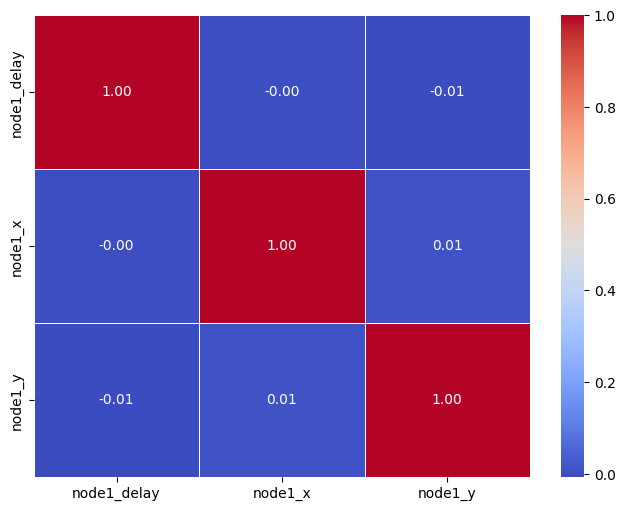

In [ ]:
correlation_matrix = df[['node1_delay', 'node1_x', 'node1_y']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.show()